In [1]:
import pandas as pd
import numpy as np
import os 
import random 
import gc
from sklearn.metrics import *
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,minmax_scale
import gc
import time
from datetime import datetime
from collections import Counter
from contextlib import contextmanager
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
root = './主表数据/'
result = './result/'
new = '../B榜数据/其他表/'

def seed_everything(seed=2020):
    seed = int(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')

seed_everything(seed=2)

In [2]:
# 不要特征穿越
# 一定要滑动窗口保证你每个做的特征可比性

In [3]:
class DataLoader:
    def __init__(self, df, feature_columns, test_id=None):
        
        self.df = df
        self.feature_columns = feature_columns
        self.test_id = test_id
        self.preprocess()
        self.sample = 0

    def setSample(self, sample):
        self.sample = sample
    
    def preprocess(self):
        self.trn = self.df[self.df['a3']!=20211201]
        self.tst = self.df[self.df['a3']==20211201]
        del self.df
        gc.collect()
        self.y = self.trn[['id', 'y']]
        self.theta = self.y['y'].mean()
        print('tst before: ', len(self.tst), end=' ')
        self.tst = self.tst.drop_duplicates(['id'])
        print('test end: ', len(self.tst))
        self.rs = pd.DataFrame()
        self.rs['id'] = self.tst['id'] if self.test_id is None else self.test_id
        self.rs['a2'] = self.tst['a2']
        self.rs['y'] = 0
        self.rs['prediction'] = 0
        
        print('feature numbers: ', len(self.feature_columns), 'x/y: ', len(self.trn), len(self.y), 'y_mean: ', self.y['y'].mean())
        
    
    def set_pre(self, y_pre, weight=None, k=1):
        y_pre = np.array(y_pre).squeeze()
        if weight is not None:
            weight = np.array(weight)
        else:
            weight = np.ones_like(y_pre)
        self.rs['prediction'] += (y_pre * weight) / k
        
    
    def reset_pre(self):
        self.rs['y'] = 0
        self.rs['prediction'] = 0
    
    def save_res(self, model='lgb', theta=None, rate=None,result = './result/'):
        v = self.theta
        if theta is not None:
            v = theta
        if rate is None:
            t = self.rs['y'].sort_values(ascending=False).iloc[int(len(self.rs)*v)]
        else:
            t = rate
        self.rs['y'] = [1 if i >=t else 0 for i in self.rs['prediction']]
        # self.rs = self.save_process(self.rs, theta)
        print(self.rs.groupby('a2')['y'].agg(['count', 'mean', 'sum']))
        name = model + '_' + str(datetime.now()).split(' ')[0]
        self.rs[['id', 'y']].to_csv(result+name+'.csv', index=None)
        print(self.rs['y'].mean())
        print('save to ', result + name + '.csv')
    
    def save_process(self, rs, v):
        
        c2 = rs[rs['a2']==2]
        other = rs[rs['a2']!=2]
        t = other['y'].sort_values(ascending=False).iloc[int(len(rs)*v)]
        t2 = c2['y'].sort_values(ascending=False).iloc[80]
        other['y'] = other['y'].map(lambda x: 1 if x >= t else 0)
        c2['y'] = c2['y'].map(lambda x: 1 if x >= t2 else 0)
        return pd.concat([c2, other])
            

    
    def _upsample(self, x):
        pos = x[x['y'] == 1]
        neg = x[x['y'] == 0]
        poses = [pos] * int(np.floor(self.sample))
        rate = self.sample - np.floor(self.sample)
        if rate > 0:
            poses + [pos.sample(frac=rate, random_state=42)]
        poses += [neg]
        data = pd.concat(poses).sample(frac=1)
        return data
        
    def _downsample(self, x):
        pos = x[x['y'] == 1]
        neg = x[x['y'] == 0].sample(frac=self.sample, random_state=42)
        data = pd.concat([pos, neg]).sample(frac=1)
        return data
    
    def get_train_val_data_by_time(self, val_time=20211001):
        #使用9.1做验证
        train = self.trn.loc[self.trn['a3']!=val_time]
        if self.sample > 0:
            if self.sample < 1:
                train = self._downsample(train)
            else:
                train = self._upsample(train)
        x_train = train[self.feature_columns]
        y_train = train['y']
        val = self.trn.loc[self.trn['a3']==val_time]
        x_val = val[self.feature_columns]
        y_val = val['y']
        return x_train, x_val, y_train, y_val
    
    def get_train_val_data(self, val_rate=0.3):
        if self.sample == 0:
            train = self.trn[self.feature_columns]
            y = self.trn['y']
        elif self.sample < 1:
            train = self._downsample(self.trn)
            y = train['y']
            train = train[self.feature_columns]
        else:
            train = self._upsample(self.trn)
            y = train['y']
            train = train[self.feature_columns]
        if val_rate > 0:
            x_train, x_val, y_train, y_val = train_test_split(train, y, test_size=val_rate, random_state=0, shuffle=False)
            return x_train, x_val, y_train, y_val
        else:
            return train, y
    def get_test(self):
        return self.tst[self.feature_columns]
    
    def get_k_fold_train_val_data(self, k):
        if self.sample == 0:
            train = self.trn[self.feature_columns]
            y = self.trn['y']
        elif self.sample < 1:
            train = self._downsample(self.trn)
            y = train['y']
            train = train[self.feature_columns]
        else:
            train = self._upsample(self.trn)
            y = train['y']
            train = train[self.feature_columns]
        sk = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        for trn_idx, val_idx in sk.split(train,y):
            trn, y_trn = train.iloc[trn_idx], y.iloc[trn_idx]
            val, y_val = train.iloc[val_idx], y.iloc[val_idx]
            yield trn, val, y_trn, y_val

In [4]:
def f2_score(y_true, y_pred):
    y_pred = np.array(y_pred).squeeze()    
    y_pre = pd.Series(y_pred)
    tmp = y_pre.copy()
    rate = tmp.sort_values(ascending=False).iloc[int(len(tmp)*y_true.mean())]
    y_pre[y_pre >= rate] = 1
    y_pre[y_pre < rate] = 0
    recall = recall_score(y_true, y_pre)
    precision = precision_score(y_true, y_pre)
    f2 = 5 * recall * precision / (4 * precision + recall)
    return f2, precision, recall

def lgb_f2_score(y_true, y_hat):
    y_hat = [1 if i >=0.072 else 0 for i in y_hat ]
    precision = precision_score(y_true,y_hat,zero_division=1)
    recall = recall_score(y_true,y_hat)
    f2 = 5*recall*precision/(4*precision+recall)
    return 'f2',f2,True

def metrics_detail(y_true, y_pred, category, rate=None):
    y_pred = np.array(y_pred).squeeze()    
    y_pre = pd.Series(y_pred)
    tmp = y_pre.copy()
    if rate is None:
        rate = tmp.sort_values(ascending=False).iloc[int(len(tmp)*y_true.mean())]
    else:
        rate = tmp.sort_values(ascending=False).iloc[int(len(tmp)*rate)]
    y_pre[y_pre >= rate] = 1
    y_pre[y_pre < rate] = 0
    rs = pd.DataFrame({'y': y_true, 'pre': y_pre.values, 'a2': category})
    recall = recall_score(rs['y'], rs['pre'])
    precision = precision_score(rs['y'], rs['pre'])
    f2 = 5 * recall * precision / (4 * precision + recall)
    print('a2: total', ' precision: ', precision, ' recall: ', recall, ' f2: ', f2)
    print(rs.groupby('a2')[['y', 'pre']].sum())
    for c in rs['a2'].unique():
        t = rs[rs['a2']==c]
        recall = recall_score(t['y'], t['pre'])
        precision = precision_score(t['y'], t['pre'])
        f2 = 5 * recall * precision / (4 * precision + recall)
        print('a2: ', c, ' precision: ', precision, ' recall: ', recall, ' f2: ', f2)

def find_best_threshold(y_valid, oof_prob):
    best_f2 = 0
    
    for th in tqdm([i/1000 for i in range(50, 200)]):
        oof_prob_copy = oof_prob.copy()
        oof_prob_copy[oof_prob_copy >= th] = 1
        oof_prob_copy[oof_prob_copy < th] = 0
        recall = recall_score(y_valid, oof_prob_copy)
        precision = precision_score(y_valid, oof_prob_copy)
        f2 = 5*recall*precision / (4*precision+recall)
        
        if f2 > best_f2:
            best_th = th
            best_f2 = f2
        
    return best_th, best_f2, oof_prob_copy.mean()

## basic feature engineering

In [5]:
test_old = pd.read_csv(root + 'x_test.csv')
test_old.rename(columns={'c2':'a2','c3':'a3'}, inplace=True)
label10 = pd.read_csv(root + 'y_test_A.csv')
label10 = label10[['id','y']]
test_old = test_old.merge(label10,on='id',how='left')
train = pd.read_csv(root + 'x_train.csv')
train_label = pd.read_csv(root + 'y_train.csv')
train = train.merge(train_label, on='id', how='left')
train = pd.concat([train,test_old])
test = pd.read_csv(new + 'x_test_B.csv')
test.rename(columns={'c2':'a2','c3':'a3'}, inplace=True)
df = pd.concat([train, test]).reset_index(drop=True)
df['a3'] = df['a3'].map(lambda x: int(str(x).replace('-', '')))
del train, test,test_old,label10
gc.collect()
print(df.shape)
def print_new_cols(new_cols,cols):
    r = []
    for i in new_cols:
        if i not in cols:
            r.append(i)
    print(r)

(3540580, 6)


In [9]:
df.corr()
# minimize correlation between features
# maximize correlation between features and labels

,a2,a3,y
a2,1.000000,-0.106737,0.026568
a3,-0.106737,1.000000,-0.027190
y,0.026568,-0.027190,1.000000


In [6]:
df_columns = df.columns
d = pd.read_csv(root + 'd.csv')
new_d = pd.read_csv(new + 'd_bc.csv')
d = pd.concat([d,new_d])
d = d.drop_duplicates(['core_cust_id'])
df = df.merge(d, on='core_cust_id', how='left')
e = pd.read_csv(root + 'e.csv')
new_e = pd.read_csv(new+'e_bc.csv')
e = pd.concat([e,new_e])
e = e.drop_duplicates(['core_cust_id', 'e2'])
e_stats = []
for end in [20211201,20211001, 20210901, 20210801, 20210701]:
    e_stat = e.loc[e['e2']<end].groupby('core_cust_id').agg(e1_mean=('e1', 'mean'), e1_cnt=('e1', 'count'), e1_last=('e1', 'last'), e2_last=('e2', 'max'), e2_first=('e2', 'min')).reset_index()
    e_stat['a3'] = end
    e_stat['eval_delta'] = end - e_stat['e2_last']
    e_stat['eval_first_delta'] = end - e_stat['e2_first']
    e_stats.append(e_stat)

####################################################################################################### e_stats hasnt been concat!
e_stats = pd.concat(e_stats)
df = df.merge(e_stat, on=['core_cust_id', 'a3'], how='left')
print_new_cols(df.columns,df_columns)
df_columns = df.columns
del d, e , e_stats
gc.collect()

['d1', 'd2', 'd3', 'e1_mean', 'e1_cnt', 'e1_last', 'e2_last', 'e2_first', 'eval_delta', 'eval_first_delta']


13

In [9]:
f = pd.read_csv(root + 'f.csv')
new_f = pd.read_csv(new+'f_bc.csv')
f = pd.concat([f,new_f])
f.fillna(0, inplace=True)
f['create_date'] = f['f1'].map(lambda x: int(str(x).replace('-', '')))
f_cols = ['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9','f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19','f20', 'f21']
for c in f_cols:
    f[c] = f[c].apply(lambda x: str(x).replace(',','')).astype('float')

f_dict = {col: (col, 'mean') for col in f_cols}
f_stat = f.groupby(['core_cust_id','f22']).agg(**f_dict).reset_index()
f_stat['f22'] = f_stat['f22'].map(lambda x: x-29+100)
df = df.merge(f_stat, left_on=['core_cust_id','a3'], right_on=['core_cust_id','f22'], how='left')
df = df.merge(f.groupby('core_cust_id')['create_date'].min().reset_index(), how='left', on='core_cust_id')
df['create_date'] = df['a3'] - df['create_date']
del f_stat, f#, ff, feature
gc.collect()
print_new_cols(df.columns,df_columns)
df_columns = df.columns
df.head()

['f22', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'create_date']


,id,core_cust_id,prod_code,a2,a3,y,d1,d2,d3,e1_mean,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,create_date
0,4e3c3d57b83e425f8087b1d6d32a50f7,6e2105d9fe,90318011,4,20210801,0.0,1,4.0,32,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20280.0
1,aa83c5fc05414c4d9727f0b32882f80e,6e2105d9fe,GRHLA20211530,1,20210901,0.0,1,4.0,32,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20380.0
2,11245458ed6446cd9f88d57a5fc1d957,6e2105d9fe,DECD21090102,2,20210901,0.0,1,4.0,32,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20380.0
3,359a03ecc46240d9bc00eef58dbc85e3,6e2105d9fe,GRHLA20211119,1,20210801,0.0,1,4.0,32,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20280.0
4,7a5d79036dfb46acb7348e741ab00d9f,6e2105d9fe,GRHLA20211125,1,20210801,0.0,1,4.0,32,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20280.0


In [7]:
# A理财产品表2
k = pd.read_csv(root + 'k.csv')
# B理财产品表2
l = pd.read_csv(root + 'l.csv')
# C理财产品表2
m = pd.read_csv(root + 'm.csv')
prod_info2 = pd.DataFrame()
prod_info2['prod_code'] = k['prod_code'].to_list() + l['prod_code'].to_list() + m['prod_code'].to_list()
prod_info2['prod_date2'] = k['k11'].to_list() + l['l7'].to_list() + m['m9'].to_list()
prod_info2['k1'] = k['k1'].to_list() + l['l1'].to_list() + m['m1'].to_list()
prod_info2['k2'] = k['k2'].to_list() + l['l2'].to_list() + m['m2'].to_list()
prod_info2['k3'] = k['k3'].to_list() + l['l3'].to_list() + m['m3'].to_list()
prod_info2['k4'] = k['k4'].to_list() + l['l4'].to_list() + m['m4'].to_list()
prod_info2['k5'] = k['k5'].to_list() + l['l5'].to_list() + m['m5'].to_list()
prod_info2['k6'] = k['k6'].to_list() + l['l6'].to_list() + m['m6'].to_list()
# prod_info2['k7'] = k['k7'].to_list() + [np.nan]*len(l) + m['m7'].to_list()
prod_info2['k10'] = k['k10'].to_list() + [np.nan]*len(l) + m['m8'].to_list()
# prod_info2['k8'] = k['k8'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
# prod_info2['k9'] = k['k9'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
prod_info2['a2'] = [1] * len(k) + [3] * len(l) + [2] * len(m)

drop_cols = [c for c in prod_info2.columns if prod_info2[c].dtype != 'object' and prod_info2[c].std() == 0]
print(drop_cols)
prod_info2.drop(drop_cols, axis=1, inplace=True)
prod_info2 = prod_info2.drop_duplicates(['prod_code', 'a2'])
df = df.merge(prod_info2, how='left', on=['prod_code', 'a2'])
print_new_cols(df.columns,df_columns)
df_columns = df.columns
df.head()

[]
['prod_date2', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k10']


,id,core_cust_id,prod_code,a2,a3,y,d1,d2,d3,e1_mean,...,f21,create_date,prod_date2,k1,k2,k3,k4,k5,k6,k10
0,4e3c3d57b83e425f8087b1d6d32a50f7,6e2105d9fe,90318011,4,20210801,0.0,1,4.0,32,NaN,...,0.0,20280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aa83c5fc05414c4d9727f0b32882f80e,6e2105d9fe,GRHLA20211530,1,20210901,0.0,1,4.0,32,NaN,...,0.0,20380.0,209912.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN
2,11245458ed6446cd9f88d57a5fc1d957,6e2105d9fe,DECD21090102,2,20210901,0.0,1,4.0,32,NaN,...,0.0,20380.0,209912.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0
3,359a03ecc46240d9bc00eef58dbc85e3,6e2105d9fe,GRHLA20211119,1,20210801,0.0,1,4.0,32,NaN,...,0.0,20280.0,209912.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN
4,7a5d79036dfb46acb7348e741ab00d9f,6e2105d9fe,GRHLA20211125,1,20210801,0.0,1,4.0,32,NaN,...,0.0,20280.0,209912.0,NaN,NaN,NaN,2.0,5.0,1.0,NaN


In [8]:
# A理财产品表1
g = pd.read_csv(root + 'g.csv')
# B理财产品表1
h = pd.read_csv(root + 'h.csv')
# C理财产品表1
i = pd.read_csv(root + 'i.csv')
# D理财产品表1
j = pd.read_csv(root + 'j.csv')
prod_info1 = pd.DataFrame()
prod_info1['prod_code'] = g['prod_code'].to_list() + h['prod_code'].to_list() + i['prod_code'].to_list() + j['prod_code'].to_list()
prod_info1['prod_date1'] = g['g9'].to_list() + h['h8'].to_list() + i['i9'].to_list() + j['j13'].to_list()
prod_info1['bid_type'] = g['g1'].to_list() + h['h1'].to_list() + i['i1'].to_list() + j['j1'].to_list()
prod_info1['recur_type'] = g['g2'].to_list() + h['h2'].to_list() + i['i2'].to_list() + j['j2'].to_list()
prod_info1['prod_type'] = g['g3'].to_list() + h['h3'].to_list() + i['i3'].to_list() + j['j3'].to_list()
prod_info1['exp_level'] = g['g4'].to_list() + h['h4'].to_list() + i['i4'].to_list() + j['j4'].to_list()
prod_info1['is_guncun'] = g['g5'].to_list() + [np.nan] * len(h) + [np.nan] * len(i) + [np.nan] * len(j)################## why?
prod_info1['hold_days'] = g['g8'].to_list() + [np.nan] * len(h) + i['i8'].to_list() + [np.nan] * len(j)
prod_info1['prod_type2'] = [np.nan]*len(g) + h['h7'].to_list() + [np.nan] * len(i) + [np.nan] * len(j)
prod_info1['j6'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j6'].to_list()
prod_info1['j9'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j9'].to_list()
prod_info1['j10'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j10'].to_list()
prod_info1['a2'] = [1] * len(g) + [3] * len(h) + [2] * len(i) + [4] * len(j)
drop_cols = [c for c in prod_info1.columns if prod_info1[c].dtype != 'object' and prod_info1[c].std() == 0]
print(drop_cols)
prod_info1.drop(drop_cols, axis=1, inplace=True)

prod_info1 = prod_info1.drop_duplicates(['prod_code', 'a2'])

df = df.merge(prod_info1, how='left', on=['prod_code', 'a2'])
print_new_cols(df.columns,df_columns)
df_columns = df.columns

df.head()

[]
['prod_date1', 'bid_type', 'recur_type', 'prod_type', 'exp_level', 'is_guncun', 'hold_days', 'prod_type2', 'j6', 'j9', 'j10']


,id,core_cust_id,prod_code,a2,a3,y,d1,d2,d3,e1_mean,...,bid_type,recur_type,prod_type,exp_level,is_guncun,hold_days,prod_type2,j6,j9,j10
0,4e3c3d57b83e425f8087b1d6d32a50f7,6e2105d9fe,90318011,4,20210801,0.0,1,4.0,32,NaN,...,1,0,1.0,2.0,NaN,NaN,NaN,0.0,1.0,1.0
1,aa83c5fc05414c4d9727f0b32882f80e,6e2105d9fe,GRHLA20211530,1,20210901,0.0,1,4.0,32,NaN,...,0,1,1.0,1.0,0.0,115.0,NaN,NaN,NaN,NaN
2,11245458ed6446cd9f88d57a5fc1d957,6e2105d9fe,DECD21090102,2,20210901,0.0,1,4.0,32,NaN,...,0,0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,359a03ecc46240d9bc00eef58dbc85e3,6e2105d9fe,GRHLA20211119,1,20210801,0.0,1,4.0,32,NaN,...,0,1,1.0,1.0,0.0,7.0,NaN,NaN,NaN,NaN
4,7a5d79036dfb46acb7348e741ab00d9f,6e2105d9fe,GRHLA20211125,1,20210801,0.0,1,4.0,32,NaN,...,0,1,1.0,1.0,0.0,146.0,NaN,NaN,NaN,NaN


In [9]:
#收益率
profit = pd.DataFrame()
profit['prod_code'] = g['prod_code'].to_list() + h['prod_code'].to_list() + i['prod_code'].to_list() + j['prod_code'].to_list() + k['prod_code'].to_list() + l['prod_code'].to_list() + m['prod_code'].to_list()
profit['profit_rate'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j11'].to_list() + k['k7'].to_list() + [np.nan]*len(l) + m['m7'].to_list()
profit['max_profit_rate'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j7'].to_list() + k['k8'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['min_profit_rate'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j8'].to_list() + k['k9'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['a2'] = [1] * len(g) + [3] * len(h) + [2] * len(i) + [4] * len(j) + [1] * len(k) + [3] * len(l) + [2] * len(m)
profit = profit.groupby(['prod_code', 'a2']).mean().reset_index()

drop_cols = [c for c in profit.columns if profit[c].dtype != 'object' and profit[c].std() == 0]
print(drop_cols)
profit.drop(drop_cols, axis=1, inplace=True)

df = df.merge(profit, how='left', on=['prod_code', 'a2'])
df.head()


del k, l, m
del g, h, i, j
gc.collect()
print_new_cols(df.columns,df_columns)
df_columns = df.columns

[]
['profit_rate', 'max_profit_rate', 'min_profit_rate']


In [10]:
window = 7
skip = 0 #跳过月提取特征
months = [20210701, 20210801, 20210901, 20211001,20211201]
# A类产品交易流水表
n = pd.read_csv(root + 'n.csv')
new_n = pd.read_csv(new + 'n_bc.csv')
n=pd.concat([n,new_n])
# #B类产品交易流水表
o = pd.read_csv(root + 'o.csv')
new_o = pd.read_csv(new + 'o_bc.csv')
o=pd.concat([o,new_o])
# C类产品交易流水表
q = pd.read_csv(root + 'q.csv')
new_q = pd.read_csv(new + 'q_bc.csv')
q=pd.concat([q,new_q])
# D类产品流水表
p = pd.read_csv(root + 'p.csv')
new_p = pd.read_csv(new + 'p_bc.csv')
p=pd.concat([p,new_p])

bid = pd.DataFrame()
bid['core_cust_id'] = n['core_cust_id'].to_list() + o['core_cust_id'].to_list() + q['core_cust_id'].to_list() + p['core_cust_id'].to_list()
bid['prod_code'] = n['prod_code'].to_list() + o['prod_code'].to_list() + q['prod_code'].to_list() + p['prod_code'].to_list()
bid['date'] = n['n11'].to_list() + o['o12'].to_list() + q['q10'].to_list() + p['p12'].to_list()
bid['a2'] = [1] * len(n) + [3] * len(o) + [2] * len(q) + [4] * len(p)
bid['n1'] = n['n1'].to_list() + o['o1'].to_list() + q['q1'].to_list() + p['p1'].to_list()
bid['n2'] = n['n2'].to_list() + o['o2'].to_list() + q['q2'].to_list() + p['p2'].to_list()
bid['n3'] = n['n3'].to_list() + o['o3'].to_list() + q['q3'].to_list() + p['p3'].to_list()
bid['n6'] = n['n6'].to_list() + o['o6'].to_list() + q['q6'].to_list() + p['p6'].to_list()
bid['n7'] = n['n7'].to_list() + o['o7'].to_list() + q['q7'].to_list() + p['p7'].to_list()
bid['n8'] = n['n8'].to_list() + o['o9'].to_list() + q['q8'].to_list() + p['p10'].to_list()
bid['n9'] = n['n9'].to_list() + o['o8'].to_list() + q['q9'].to_list() + p['p9'].to_list()
bid['n10'] = n['n10'].to_list() + o['o10'].to_list() + [np.nan]*len(q) + [np.nan]*len(p)
bid['n11'] = [np.nan]*len(n) + o['o11'].to_list() + [np.nan]*len(q) + [np.nan]*len(p)
bid['n12'] = [np.nan]*len(n) + [np.nan]*len(o) + [np.nan]*len(q) + p['p8'].to_list()
bid['n13'] = [np.nan]*len(n) + [np.nan]*len(o) + [np.nan]*len(q) + p['p11'].to_list()

bid['n7'] = bid['n7'].map(lambda x: str(x).replace(',', '') if x is not np.nan else np.nan).astype(float)
bid['n11'] = bid['n11'].map(lambda x: str(x).replace(',', '') if x is not np.nan else np.nan).astype(float)
bid['n10'] = bid['n10'].map(lambda x: str(x).replace(',', '') if x is not np.nan else np.nan).astype(float)

bid_stats = []
for date in months:
    start = date - skip * 100 - window * 100
    bid_dict = {'prod_code_nunique_in_uid': ('prod_code', 'nunique'), 
                'n1_cnt_in_uid': ('n1', 'count'),
                'n_nunique_in_uid': ('n2', 'nunique'),
                'n3_nunique_in_uid': ('n3', 'nunique'),
                'n6_mean': ('n6', 'mean'),
                'n7_mean': ('n7', 'mean'), 
                'n8_nunique': ('n8', 'nunique'),
                'n9_nunique': ('n9', 'nunique'),
                'n10_mean': ('n10', 'mean'),
                'u_first_buy': ('date', 'min'), 
                'u_last_buy': ('date', 'max'), 
                'u_buy_days': ('date', 'nunique'), 
                'n8_last': ('n8', 'last'),
                'n9_last': ('n9', 'last'),
                'exp_level_mean': ('exp_level', 'mean'), 
                'hold_days_mean': ('hold_days', 'mean'),
                'k10_mean': ('k10', 'mean'),
                'profit_rate_mean': ('profit_rate', 'mean'),
                'max_profit_rate_mean': ('max_profit_rate', 'mean'), 
                'min_profit_rate_mean': ('min_profit_rate', 'mean'),}
    tmp_bid = bid.loc[(bid['date']>=start)&(bid['date']<date)]
    tmp_bid = tmp_bid.drop_duplicates(['core_cust_id', 'prod_code', 'date'], keep='last')
    tmp_bid = tmp_bid.merge(prod_info1.drop(columns=['a2']), how='left', on='prod_code')
    tmp_bid = tmp_bid.merge(prod_info2.drop(columns=['a2']), how='left', on='prod_code')
    tmp_bid = tmp_bid.merge(profit.drop(columns=['a2']), how='left', on='prod_code')
    bid_stat = tmp_bid.groupby('core_cust_id').agg(**bid_dict).reset_index()
    bid_stat['a3'] = date
    bid_stat['u_first_buy_delta'] = bid_stat['a3'] - bid_stat['u_first_buy']
    bid_stat['u_last_buy_delta'] = bid_stat['a3'] - bid_stat['u_last_buy']
    bid_stat['u_first_last_buy_delta'] = bid_stat['u_last_buy'] - bid_stat['u_first_buy']
    bid_stat.drop(columns=['u_first_buy', 'u_last_buy'], inplace=True)
    #最大交易次数在某天
    tmp = tmp_bid.groupby(['core_cust_id', 'date'])['prod_code'].nunique().reset_index()\
        .sort_values(by=['core_cust_id', 'prod_code']).drop_duplicates(['core_cust_id'], keep='last')[['core_cust_id', 'date']]\
            .rename(columns={'date': 'user_max_buy_date'})
    bid_stat = bid_stat.merge(tmp, how='left', on='core_cust_id')
    bid_stat['user_max_buy_date'] = bid_stat['a3'] - bid_stat['user_max_buy_date']
    bid_stats.append(bid_stat)
    
df = df.merge(pd.concat(bid_stats), how='left', on=['core_cust_id', 'a3'])


bid_stats = []
for date in months:
    start = date - skip * 100 - window * 100
    bid_dict = {'prod_code_nunique_in_uid_a2': ('prod_code', 'nunique'),
                'n1_cnt_in_uid_a2': ('n1', 'count'), 
                'n_nunique_in_uid_a2': ('n2', 'nunique'),
                'n3_nunique_in_uid_a2': ('n3', 'nunique'),
                'n6_mean_a2': ('n6', 'mean'),
                'n7_mean_a2': ('n7', 'mean'), 
                'n8_nunique_a2': ('n8', 'nunique'),
                'n9_nunique_a2': ('n9', 'nunique'),
                'n10_mean_a2': ('n10', 'mean'),
                'u_first_buy_a2': ('date', 'min'), 
                'u_last_buy_a2': ('date', 'max'),
                'u_buy_days_a2': ('date', 'nunique'), 
                'n8_last': ('n8', 'last'),
                'n9_last': ('n9', 'last'),
                'exp_level_mean_a2': ('exp_level', 'mean'),
                'hold_days_mean_a2': ('hold_days', 'mean'),
                'k10_mean_a2': ('k10', 'mean'), 
                'profit_rate_mean_a2': ('profit_rate', 'mean'),
                'max_profit_rate_mean_a2': ('max_profit_rate', 'mean'),
                'min_profit_rate_mean_a2': ('min_profit_rate', 'mean')}
    tmp_bid = bid.loc[(bid['date']>=start)&(bid['date']<date)]
    tmp_bid = tmp_bid.drop_duplicates(['core_cust_id', 'prod_code', 'date'], keep='last')
    tmp_bid = tmp_bid.merge(prod_info1.drop(columns=['a2']), how='left', on='prod_code')
    tmp_bid = tmp_bid.merge(prod_info2.drop(columns=['a2']), how='left', on='prod_code')
    tmp_bid = tmp_bid.merge(profit.drop(columns=['a2']), how='left', on='prod_code')
    bid_stat = tmp_bid.groupby(['core_cust_id', 'a2']).agg(**bid_dict).reset_index()
    bid_stat['a3'] = date
    bid_stat['u_first_buy_delta_a2'] = bid_stat['a3'] - bid_stat['u_first_buy_a2']
    bid_stat['u_last_buy_delta_a2'] = bid_stat['a3'] - bid_stat['u_last_buy_a2']
    bid_stat['u_first_last_buy_delta_a2'] = bid_stat['u_last_buy_a2'] - bid_stat['u_first_buy_a2']
    bid_stat.drop(columns=['u_first_buy_a2', 'u_last_buy_a2'], inplace=True)
    #最大交易次数在某天
    tmp = tmp_bid.groupby(['core_cust_id', 'a2', 'date'])['prod_code'].nunique().reset_index()\
        .sort_values(by=['core_cust_id', 'a2', 'prod_code']).drop_duplicates(['core_cust_id', 'a2'], keep='last')[['core_cust_id', 'a2', 'date']]\
            .rename(columns={'date': 'user_max_buy_date_a2'})
    bid_stat = bid_stat.merge(tmp, how='left', on=['core_cust_id', 'a2'])
    bid_stat['user_max_buy_date_a2'] = bid_stat['a3'] - bid_stat['user_max_buy_date_a2']
    bid_stats.append(bid_stat)
df = df.merge(pd.concat(bid_stats), how='left', on=['core_cust_id', 'a3', 'a2'])
del bid_stat, o, p, q,new_o,new_q,new_p,n,new_n
print_new_cols(df.columns,df_columns)
df_columns = df.columns
gc.collect()

['prod_code_nunique_in_uid', 'n1_cnt_in_uid', 'n_nunique_in_uid', 'n3_nunique_in_uid', 'n6_mean', 'n7_mean', 'n8_nunique', 'n9_nunique', 'n10_mean', 'u_buy_days', 'n8_last_x', 'n9_last_x', 'exp_level_mean', 'hold_days_mean', 'k10_mean', 'profit_rate_mean', 'max_profit_rate_mean', 'min_profit_rate_mean', 'u_first_buy_delta', 'u_last_buy_delta', 'u_first_last_buy_delta', 'user_max_buy_date', 'prod_code_nunique_in_uid_a2', 'n1_cnt_in_uid_a2', 'n_nunique_in_uid_a2', 'n3_nunique_in_uid_a2', 'n6_mean_a2', 'n7_mean_a2', 'n8_nunique_a2', 'n9_nunique_a2', 'n10_mean_a2', 'u_buy_days_a2', 'n8_last_y', 'n9_last_y', 'exp_level_mean_a2', 'hold_days_mean_a2', 'k10_mean_a2', 'profit_rate_mean_a2', 'max_profit_rate_mean_a2', 'min_profit_rate_mean_a2', 'u_first_buy_delta_a2', 'u_last_buy_delta_a2', 'u_first_last_buy_delta_a2', 'user_max_buy_date_a2']


0

In [11]:
# APP点击行为表
r = pd.read_csv(root + 'r.csv')
new_r = pd.read_csv(new+'r_bc.csv')
r = pd.concat([r,new_r])
r['date'] = r['r5'].map(lambda x: str(x).split(' ')[0].replace('-','')).astype(int)
window = 7
skip = 0 #跳过月提取特征
months = [20210701, 20210801, 20210901, 20211001,20211201]
r_dict = {'prod_code_nunique_grp_uid_in_app_action': ('prod_code', 'nunique'), 
          'r5_nunique_grp_uid_in_app_action': ('r5', 'count'),
          'user_click_days': ('date', 'nunique'),
          'first_click': ('date', 'min'),
          'last_click': ('date', 'max'),
          'exp_level_mean_click': ('exp_level', 'mean'), 
          'hold_days_mean_click': ('hold_days', 'mean'), 
          'k10_mean_click': ('k10', 'mean'),
          'profit_rate_mean_click': ('profit_rate', 'mean'), 
          'max_profit_rate_mean_click': ('max_profit_rate', 'mean'),
          'min_profit_rate_mean_click': ('min_profit_rate', 'mean'),}
pivots = []
pivots1 = []
pivots2 = []
r_stats = []
r_prod_aggs = []
r_cust_prod_aggs = []
for date in months:
    start = date - skip * 100 - window * 100
    rr = r.loc[(r['date']>=start) & (r['date']<date)]
    rr = rr.merge(prod_info1, how='left', on='prod_code')
    rr = rr.merge(prod_info2.drop(columns=['a2']), how='left', on='prod_code')
    rr = rr.merge(profit.drop(columns=['a2']), how='left', on='prod_code')
    r_stat = rr.groupby(['core_cust_id']).agg(**r_dict).reset_index()
    r_stat['a3'] = date
    r_stat['first_click_delta'] = r_stat['a3'] - r_stat['first_click']
    r_stat['last_click_delta'] = r_stat['a3'] - r_stat['last_click']
    r_stat['first_last_delta'] = r_stat['last_click'] - r_stat['first_click']
    r_stat.drop(columns=['first_click', 'last_click'], inplace=True)
    ##最大点击次数
    tmp = rr.groupby(['core_cust_id', 'date'])['prod_code'].nunique().reset_index()\
        .sort_values(by=['core_cust_id', 'prod_code']).drop_duplicates(['core_cust_id'], keep='last')[['core_cust_id', 'date']]\
            .rename(columns={'date': 'user_max_click_prod'})
    r_stat = r_stat.merge(tmp, how='left', on=['core_cust_id'])
    r_stat['user_max_click_prod'] = r_stat['a3'] - r_stat['user_max_click_prod']
    tmp = rr.groupby(['core_cust_id', 'date'])['prod_code'].count().reset_index()\
        .sort_values(by=['core_cust_id', 'prod_code']).drop_duplicates(['core_cust_id'], keep='last')[['core_cust_id', 'date']]\
            .rename(columns={'date': 'user_max_click_prod_cnt'})
    r_stat = r_stat.merge(tmp, how='left', on=['core_cust_id'])
    r_stat['user_max_click_prod_cnt'] = r_stat['a3'] - r_stat['user_max_click_prod_cnt']
    r_stats.append(r_stat)
    
    r_pivot_stat = pd.pivot_table(rr, index='core_cust_id', columns=['r3'], values=['r1'], aggfunc='count').fillna(0)
    r_pivot_stat = r_pivot_stat.reset_index()
    r_pivot_stat.columns = ['core_cust_id', 'uid_cnt_in_r3_equal_1', 'uid_cnt_in_r3_equal_2']
    
    r_pivot_stat1 = pd.pivot_table(rr, index='prod_code', columns=['r3'], values=['r1'], aggfunc='count').fillna(0)
    r_pivot_stat1 = r_pivot_stat1.reset_index()
    r_pivot_stat1.columns = ['prod_code', 'pid_cnt_in_r3_equal_1', 'pid_cnt_in_r3_equal_2']
    
    r_pivot_stat2 = pd.pivot_table(rr, index=['core_cust_id','prod_code'], columns=['r3'], values=['r1'], aggfunc='count').fillna(0)
    r_pivot_stat2 =  r_pivot_stat2.reset_index()
    r_pivot_stat2.columns = ['core_cust_id','prod_code','cust_prod_r1_1_count','cust_prod_r1_2_count']
    
    r_pivot_stat['a3'] = date
    r_pivot_stat1['a3'] = date
    r_pivot_stat2['a3'] = date
    
    pivots.append(r_pivot_stat)
    pivots1.append(r_pivot_stat1)
    pivots2.append(r_pivot_stat2)
    
    r_prod_agg = rr.groupby('prod_code').agg(cust_id_count = ('r1','count')).reset_index()
    r_prod_agg['a3'] = date
    r_prod_aggs.append(r_prod_agg)
    r_cust_prod_agg = rr.groupby(['prod_code','core_cust_id']).agg(
                                            cust_id_prod_code_count = ('r1','count')).reset_index()
    r_cust_prod_agg['a3'] = date
    r_cust_prod_aggs.append(r_cust_prod_agg)
    
r_pivot_stat = pd.concat(pivots)
df = df.merge(r_pivot_stat, on=['core_cust_id', 'a3'], how='left')
r_stat = pd.concat(r_stats)
df = df.merge(r_stat, on=['core_cust_id', 'a3'], how='left')
## new features
'''r_pivot_stat1 = pd.concat(pivots1)
df = df.merge(r_pivot_stat1, on=['prod_code', 'a3'], how='left')
r_pivot_stat2 = pd.concat(pivots2)
df = df.merge(r_pivot_stat2, on=['core_cust_id','prod_code', 'a3'], how='left')
r_stat = pd.concat(r_prod_aggs)
df = df.merge(r_stat, on=['prod_code', 'a3'], how='left')
r_stat = pd.concat(r_cust_prod_aggs)
df = df.merge(r_stat, on=['core_cust_id','prod_code', 'a3'], how='left')
df['cust_id_prod_code_count_div_cust_id_count'] = df['cust_id_prod_code_count'] / df['cust_id_count']
df['cust_id_prod_code_count_div_prod_code_count'] = df['cust_id_prod_code_count'] / df['r5_nunique_grp_uid_in_app_action']'''

del r_prod_aggs,r_cust_prod_aggs,r_stats,r_pivot_stat1,r_pivot_stat2,r_stat,pivots,pivots1,pivots2
gc.collect()
for col in ['a2']:
    r_dict = {'prod_code_nunique_grp_uid_in_app_action_'+col: ('prod_code', 'nunique'),
              'r5_nunique_grp_uid_in_app_action_'+col: ('r5', 'count'),
              'user_click_days_'+col: ('date', 'nunique'),
            'first_click': ('date', 'min'),
              'last_click': ('date', 'max'),
            'exp_level_mean_click_'+col: ('exp_level', 'mean'),
              'hold_days_mean_click_'+col: ('hold_days', 'mean'), 
              'k10_mean_click_'+col: ('k10', 'mean'),
            'profit_rate_mean_click_'+col: ('profit_rate', 'mean'),
              'max_profit_rate_mean_click_'+col: ('max_profit_rate', 'mean'),
              'min_profit_rate_mean_click_'+col: ('min_profit_rate', 'mean'),
            }
    r_stats = []
    for date in months:
        start = date - skip * 100 - window * 100
        rr = r.loc[(r['date']>=start) & (r['date']<date)]
        rr = rr.merge(prod_info1, how='left', on='prod_code')
        rr = rr.merge(prod_info2.drop(columns=['a2']), how='left', on='prod_code')
        rr = rr.merge(profit.drop(columns=['a2']), how='left', on='prod_code')
        r_stat = rr.groupby(['core_cust_id', col]).agg(**r_dict).reset_index()
        r_stat['a3'] = date
        r_stat['first_click_delta'+col] = r_stat['a3'] - r_stat['first_click']
        r_stat['last_click_delta'+col] = r_stat['a3'] - r_stat['last_click']
        r_stat['first_last_delta'+col] = r_stat['last_click'] - r_stat['first_click']
        r_stat.drop(columns=['first_click', 'last_click'], inplace=True)
        ##最大点击次数
        tmp = rr.groupby(['core_cust_id', col, 'date'])['prod_code'].nunique().reset_index()\
            .sort_values(by=['core_cust_id', col, 'prod_code']).drop_duplicates(['core_cust_id', col], keep='last')[['core_cust_id', col, 'date']]\
                .rename(columns={'date': 'user_max_click_prod_'+col})
        r_stat = r_stat.merge(tmp, how='left', on=['core_cust_id', col])
        r_stat['user_max_click_prod_'+col] = r_stat['a3'] - r_stat['user_max_click_prod_'+col]
        tmp = rr.groupby(['core_cust_id', col, 'date'])['prod_code'].count().reset_index()\
            .sort_values(by=['core_cust_id', col, 'prod_code']).drop_duplicates(['core_cust_id', col], keep='last')[['core_cust_id', col, 'date']]\
                .rename(columns={'date': 'user_max_click_prod_cnt_'+col})
        r_stat = r_stat.merge(tmp, how='left', on=['core_cust_id', col])
        r_stat['user_max_click_prod_cnt_'+col] = r_stat['a3'] - r_stat['user_max_click_prod_cnt_'+col]
        
        r_stats.append(r_stat)
    r_stat = pd.concat(r_stats)
    df = df.merge(r_stat, on=['core_cust_id', col, 'a3'], how='left')

print_new_cols(df.columns,df_columns)
df_columns = df.columns
del r, r_pivot_stat, r_stat
gc.collect()
df.head()

['uid_cnt_in_r3_equal_1', 'uid_cnt_in_r3_equal_2', 'prod_code_nunique_grp_uid_in_app_action', 'r5_nunique_grp_uid_in_app_action', 'user_click_days', 'exp_level_mean_click', 'hold_days_mean_click', 'k10_mean_click', 'profit_rate_mean_click', 'max_profit_rate_mean_click', 'min_profit_rate_mean_click', 'first_click_delta', 'last_click_delta', 'first_last_delta', 'user_max_click_prod', 'user_max_click_prod_cnt', 'prod_code_nunique_grp_uid_in_app_action_a2', 'r5_nunique_grp_uid_in_app_action_a2', 'user_click_days_a2', 'exp_level_mean_click_a2', 'hold_days_mean_click_a2', 'k10_mean_click_a2', 'profit_rate_mean_click_a2', 'max_profit_rate_mean_click_a2', 'min_profit_rate_mean_click_a2', 'first_click_deltaa2', 'last_click_deltaa2', 'first_last_deltaa2', 'user_max_click_prod_a2', 'user_max_click_prod_cnt_a2']


,id,core_cust_id,prod_code,a2,a3,y,d1,d2,d3,e1_mean,...,hold_days_mean_click_a2,k10_mean_click_a2,profit_rate_mean_click_a2,max_profit_rate_mean_click_a2,min_profit_rate_mean_click_a2,first_click_deltaa2,last_click_deltaa2,first_last_deltaa2,user_max_click_prod_a2,user_max_click_prod_cnt_a2
0,4e3c3d57b83e425f8087b1d6d32a50f7,6e2105d9fe,90318011,4,20210801,0.0,1,4.0,32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aa83c5fc05414c4d9727f0b32882f80e,6e2105d9fe,GRHLA20211530,1,20210901,0.0,1,4.0,32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11245458ed6446cd9f88d57a5fc1d957,6e2105d9fe,DECD21090102,2,20210901,0.0,1,4.0,32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,359a03ecc46240d9bc00eef58dbc85e3,6e2105d9fe,GRHLA20211119,1,20210801,0.0,1,4.0,32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7a5d79036dfb46acb7348e741ab00d9f,6e2105d9fe,GRHLA20211125,1,20210801,0.0,1,4.0,32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 账户交易流水表
s = pd.read_csv(root + 's.csv')
new_s = pd.read_csv(new + 's_bc.csv')
s = pd.concat([s,new_s])
s['date'] = s['s5'].map(lambda x: str(x).replace('-', '')).astype(int)
s['s4'] = s['s4'].apply(lambda x: str(x).replace(',','')).astype('float')  

window = 7
skip = 0 #跳过月提取特征
months = [20210701, 20210801, 20210901, 20211001,20211201]

feature1 = []
feature2 = []
for date in months:
    start = date - skip * 100 - window * 100
    ss = s.loc[(s['date']>=start) & (s['date']<date)]
    tmp = ss.groupby('s3').size().reset_index()
    tmp.columns = ['core_cust_id','borrow_cnt']
    tmp['borrow_amt_mean_grp_uid'] = ss.groupby('s3')['s4'].agg('mean').values
    tmp['borrow_amt_max_grp_uid'] = ss.groupby('s3')['s4'].agg('max').values
    tmp['borrow_amt_last_grp_uid'] = ss.sort_values(by=['s3', 'date']).groupby('s3')['s4'].agg('last').values
    tmp['first_borrow'] = ss.groupby('s3')['date'].agg('min').values
    tmp['last_borrow'] = ss.groupby('s3')['date'].agg('max').values
    tmp['a3'] = date
    tmp['first_borrow_delta'] = tmp['a3'] - tmp['first_borrow']
    tmp['last_borrow_delta'] = tmp['a3'] - tmp['last_borrow']
    tmp['first_last_borrow_delta'] = tmp['last_borrow'] - tmp['first_borrow']
    tmp.drop(columns=['first_borrow', 'last_borrow'], inplace=True)
    t = ss.groupby(['s3', 'date'])['s4'].sum().reset_index().sort_values(by=['s3', 's4']).drop_duplicates(['s3'], keep='last')[['s3', 's4', 'date']]\
            .rename(columns={'date': 'user_max_borrow_date', 's4': 'user_max_borrow_v'})
    tmp = tmp.merge(t, how='left', left_on='core_cust_id', right_on='s3')
    tmp['user_max_borrow_date'] = tmp['a3'] - tmp['user_max_borrow_date']
    
    feature1.append(tmp)
    
    tmp = ss.groupby('s6').size().reset_index()
    tmp.columns = ['core_cust_id','loan_cnt']
    tmp['loan_amt_mean_grp_uid'] = ss.groupby('s6')['s4'].agg('mean').values
    tmp['loan_amt_max_grp_uid'] = ss.groupby('s6')['s4'].agg('max').values
    tmp['loan_amt_last_grp_uid'] = ss.sort_values(by=['s6', 'date']).groupby('s6')['s4'].agg('last').values
    tmp['first_loan'] = ss.groupby('s6')['date'].agg('min').values
    tmp['last_loan'] = ss.groupby('s6')['date'].agg('max').values
    
    tmp['a3'] = date
    tmp['first_loan_delta'] = tmp['a3'] - tmp['first_loan']
    tmp['last_loan_delta'] = tmp['a3'] - tmp['last_loan']
    tmp['first_last_loan_delta'] = tmp['last_loan'] - tmp['first_loan']
    tmp.drop(columns=['first_loan', 'last_loan'], inplace=True)
    t = ss.groupby(['s6', 'date'])['s4'].sum().reset_index().sort_values(by=['s6', 's4']).drop_duplicates(['s6'], keep='last')[['s6', 's4', 'date']]\
            .rename(columns={'date': 'user_max_loan_date', 's4': 'user_max_loan_v'})
    tmp = tmp.merge(t, how='left', left_on='core_cust_id', right_on='s6')
    tmp['user_max_loan_date'] = tmp['a3'] - tmp['user_max_loan_date']
    feature2.append(tmp)
feature1 = pd.concat(feature1)
feature2 = pd.concat(feature2)

df = df.merge(feature1, how='left', on=['core_cust_id', 'a3'])
del feature1,tmp ,s,t,new_s
gc.collect()
df = df.merge(feature2, how='left', on=['core_cust_id', 'a3'])
del feature2
gc.collect()
print('new columns:',df.columns[-(len(df.columns)-len(df_columns)):])
df_columns = df.columns

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


new columns: Index(['borrow_cnt', 'borrow_amt_mean_grp_uid', 'borrow_amt_max_grp_uid',
       'borrow_amt_last_grp_uid', 'first_borrow_delta', 'last_borrow_delta',
       'first_last_borrow_delta', 's3', 'user_max_borrow_v',
       'user_max_borrow_date', 'loan_cnt', 'loan_amt_mean_grp_uid',
       'loan_amt_max_grp_uid', 'loan_amt_last_grp_uid', 'first_loan_delta',
       'last_loan_delta', 'first_last_loan_delta', 's6', 'user_max_loan_v',
       'user_max_loan_date'],
      dtype='object')


In [29]:
# 保存数据
drop_cols = ['prod_date1', 'prod_date2', 's3', 's6']
df.drop(drop_cols, axis=1,inplace=True)

sp_cols = [c for c in df.columns if df[c].dtype != 'object' and df[c].std() == 0]
print(sp_cols)
df.drop(sp_cols, axis=1,inplace=True)

['k1', 'k2', 'k3', 'prod_type2', 'j9', 'j10']


## this knn features

In [5]:
'''g = pd.read_csv(root + 'g.csv')
# B理财产品表1
h = pd.read_csv(root + 'h.csv')
# C理财产品表1
i = pd.read_csv(root + 'i.csv')
# D理财产品表1
j = pd.read_csv(root + 'j.csv')
prod_info1 = pd.DataFrame()
prod_info1['prod_code'] = g['prod_code'].to_list() + h['prod_code'].to_list() + i['prod_code'].to_list() + j['prod_code'].to_list()
prod_info1['prod_date1'] = g['g9'].to_list() + h['h8'].to_list() + i['i9'].to_list() + j['j13'].to_list()
prod_info1['bid_type'] = g['g1'].to_list() + h['h1'].to_list() + i['i1'].to_list() + j['j1'].to_list()
prod_info1['recur_type'] = g['g2'].to_list() + h['h2'].to_list() + i['i2'].to_list() + j['j2'].to_list()
prod_info1['prod_type'] = g['g3'].to_list() + h['h3'].to_list() + i['i3'].to_list() + j['j3'].to_list()
prod_info1['exp_level'] = g['g4'].to_list() + h['h4'].to_list() + i['i4'].to_list() + j['j4'].to_list()
prod_info1['is_guncun'] = g['g5'].to_list() + [np.nan] * len(h) + [np.nan] * len(i) + [np.nan] * len(j)################## why?
prod_info1['hold_days'] = g['g8'].to_list() + [np.nan] * len(h) + i['i8'].to_list() + [np.nan] * len(j)
prod_info1['prod_type2'] = [np.nan]*len(g) + h['h7'].to_list() + [np.nan] * len(i) + [np.nan] * len(j)
prod_info1['j6'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j6'].to_list()
prod_info1['j9'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j9'].to_list()
prod_info1['j10'] = [np.nan]*len(g) + [np.nan]*len(h) + [np.nan] * len(i) + j['j10'].to_list()
prod_info1['a2'] = [1] * len(g) + [3] * len(h) + [2] * len(i) + [4] * len(j)
prod_info1['prod_date1'] = prod_info1['prod_date1'].replace(209912,202112)
pivot = prod_info1.loc[:,['prod_date1','bid_type','recur_type','exp_level','is_guncun','hold_days','a2']]
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
print('start knn')
N_NEIGHBORS_MAX = 100
class Neighbors:
    def __init__(self, pivot, p, metric='minkowski', metric_params=None):
        nn = NearestNeighbors(n_neighbors=N_NEIGHBORS_MAX, p=p, metric=metric, metric_params=metric_params)
        nn.fit(pivot)
        self.distances, self.neighbors = nn.kneighbors(pivot, return_distance=True)
with timer('k_neighbors_cust_prod_c'):
    k_neighbors_cust_prod_c = Neighbors(pivot, 2, metric='canberra')
    #k_neighbors_cust_prod_m = Neighbors(pivot, 2, metric='mahalanobis', metric_params={'V':np.cov(pivot.values.T)})
cols_agg = {
    'hold_days': [np.mean, np.min, np.max],
}

neighbor_sizes = [30,40]
def make_knn_features(df,neighbor_sizes,all_neighbors,cols_agg):
    result = np.zeros([len(neighbor_sizes),len(all_neighbors),len(cols_agg.keys())*3])
    for i,size in enumerate(neighbor_sizes):
        neighbors = all_neighbors[:,:size]
        agg_values = np.zeros([len(all_neighbors),len(cols_agg.keys())*3])
        for row in tqdm(range(len(all_neighbors))):
            part_df = df.iloc[neighbors[row]]
            for index,col in enumerate(cols_agg.keys()):
                mean = np.mean(part_df[col])
                amin = np.min(part_df[col])
                amax = np.max(part_df[col])
                agg_values[row,index*3:(index+1)*3] = np.array([mean,amin,amax])
        result[i] = agg_values
    return result
a = make_knn_features(prod_info1,neighbor_sizes,k_neighbors_cust_prod_c.neighbors,cols_agg)
knn_hold = pd.DataFrame()
knn_hold['prod_code'] = prod_info1['prod_code']
for i,col in enumerate(cols_agg.keys()):
    for j,agg in enumerate(['mean','min','max']):
        for k,size in enumerate(neighbor_sizes):
            knn_hold[col+'_'+str(size)+'nn_'+agg] = a[k,:,i*3+j]
df = df.merge(knn_hold,on='prod_code',how='left')
for i in tqdm(df.columns):
    if '0nn' in i:
        df[i] = df['hold_days'] - df[i] '''

### profit rate knn features

In [160]:
'''k = pd.read_csv(root + 'k.csv')
# B理财产品表2
l = pd.read_csv(root + 'l.csv')
# C理财产品表2
m = pd.read_csv(root + 'm.csv')
j = pd.read_csv(root + 'j.csv')
profit = pd.DataFrame()
profit['prod_code'] = j['prod_code'].to_list() + k['prod_code'].to_list() + l['prod_code'].tolist() + m['prod_code'].to_list()
profit['profit_rate'] =  j['j11'].to_list() + k['k7'].to_list() + [np.nan]*len(l) + m['m7'].to_list()
profit['max_profit_rate'] =j['j7'].to_list() + k['k8'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['min_profit_rate'] =  j['j8'].to_list() + k['k9'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['a2'] = [4] * len(j) + [1] * len(k) + [3] * len(l) + [2] * len(m)

pivot = profit.loc[:,['profit_rate','max_profit_rate','min_profit_rate','a2']]
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
N_NEIGHBORS_MAX = 40
class Neighbors:
    def __init__(self, pivot, p, metric='minkowski', metric_params=None):
        nn = NearestNeighbors(n_neighbors=N_NEIGHBORS_MAX, p=p, metric=metric, metric_params=metric_params)
        nn.fit(pivot)
        self.distances, self.neighbors = nn.kneighbors(pivot, return_distance=True)
with timer('k_neighbors_cust_prod_c'):
    k_neighbors_cust_prod_c = Neighbors(pivot, 2, metric='canberra')
a = np.zeros([10000,100])
with timer('k_neighbors_cust_prod_c'):
    k_neighbors_cust_prod_c = Neighbors(a, 2, metric='canberra')
cols_agg = {
    'profit_rate': [np.mean, np.min, np.max],
    'max_profit_rate':[np.mean, np.min, np.max],
    'min_profit_rate':[np.mean, np.min, np.max]
}

neighbor_sizes = [40,500]
def make_knn_features(df,neighbor_sizes,all_neighbors,cols_agg):
    result = np.zeros([len(neighbor_sizes),len(all_neighbors),len(cols_agg.keys())*3])
    for i,size in enumerate(neighbor_sizes):
        neighbors = all_neighbors[:,:size]
        agg_values = np.zeros([len(all_neighbors),len(cols_agg.keys())*3])
        for row in tqdm(range(len(all_neighbors))):
            part_df = df.iloc[neighbors[row]]
            for index,col in enumerate(cols_agg.keys()):
                mean = np.mean(part_df[col])
                amin = np.min(part_df[col])
                amax = np.max(part_df[col])
                agg_values[row,index*3:(index+1)*3] = np.array([mean,amin,amax])
        result[i] = agg_values
    return result
a = make_knn_features(profit,neighbor_sizes,k_neighbors_cust_prod_c.neighbors,cols_agg)
knn_hold = pd.DataFrame()
knn_hold['prod_code'] = profit['prod_code']
for i,col in enumerate(cols_agg.keys()):
    for j,agg in enumerate(['mean','min','max']):
        for k,size in enumerate(neighbor_sizes):
            knn_hold[col+'_'+str(size)+'nn_'+agg] = a[k,:,i*3+j]
df = df.merge(knn_hold,on='prod_code',how='left')
for i in tqdm(df.columns):
    if 'nn' in i:
        if 'max_profit_rate' in i:
            df[i] = df[i] = df['max_profit_rate']
        elif 'min_profit_rate'in i:
            df[i] = df[i] = df['min_profit_rate']
        elif 'profit_rate' in i:
            df[i] = df[i] = df['profit_rate']'''

## second level features

### diff features

In [13]:
count_cols = ['e1_last','d2','age_level']
df['age_level'] = np.floor(df['d3'] / 10)
yes = df[df['y']==1]
for i in tqdm(count_cols):
    '''cnts = df[i].value_counts(normalize=True).reset_index()
    cnts.columns=[i,i+'_cnts_all']
    df = df.merge(cnts,how='left',on=i)'''
    gc.collect()
    cnts = yes[i].value_counts(normalize=True).reset_index()
    cnts.columns=[i,i+'_cnts_yes']
    df = df.merge(cnts,how='left',on=i)
    del cnts
    gc.collect()
df.drop(columns=['age_level'],inplace=True)

del yes
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.21s/it]


26

In [15]:
g = pd.read_csv(root + 'g.csv')
# B理财产品表1
h = pd.read_csv(root + 'h.csv')
# C理财产品表1
i = pd.read_csv(root + 'i.csv')
# D理财产品表1
j = pd.read_csv(root + 'j.csv')
prod_info1 = pd.DataFrame()
prod_info1['exp_level'] = g['g4'].to_list() + h['h4'].to_list() + i['i4'].to_list() + j['j4'].to_list()
prod_info1['hold_days'] = g['g8'].to_list() + [np.nan] * len(h) + i['i8'].to_list() + [np.nan] * len(j)
prod_info1['a2'] = [1] * len(g) + [3] * len(h) + [2] * len(i) + [4] * len(j)
prod_agg_dict={
    'exp_level':[np.min,np.max,np.mean],
    'hold_days':[np.min,np.max,np.mean],
}
prod_agg = prod_info1.groupby(['a2']).agg(prod_agg_dict)
prod_agg.columns = ['_'.join(i) + '_ina2' for i in prod_agg.columns]
prod_agg = prod_agg.reset_index()
df = df.merge(prod_agg,how='left',on=['a2'])
prod_cols = ['exp_level','hold_days']
agg_cols = ['amin','amax','mean']
for i in prod_cols:
    for j in agg_cols:
        df[i+'_'+j+'_a2_diff'] = df[i] - df[i+'_'+j+'_ina2']
df.drop(columns = ['exp_level_amin_ina2', 'exp_level_amax_ina2',
       'exp_level_mean_ina2', 'hold_days_amin_ina2', 'hold_days_amax_ina2',
       'hold_days_mean_ina2'],inplace=True)
del g,h,i,j, prod_info1,prod_agg
gc.collect()

35

In [16]:
k = pd.read_csv(root + 'k.csv')
# B理财产品表2
l = pd.read_csv(root + 'l.csv')
# C理财产品表2
m = pd.read_csv(root + 'm.csv')
j = pd.read_csv(root + 'j.csv')
profit = pd.DataFrame()
profit['profit_rate'] =  j['j11'].to_list() + k['k7'].to_list() + [np.nan]*len(l) + m['m7'].to_list()
profit['max_profit_rate'] =j['j7'].to_list() + k['k8'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['min_profit_rate'] =  j['j8'].to_list() + k['k9'].to_list() + [np.nan]*len(l) + [np.nan]*len(m)
profit['a2'] = [4] * len(j) + [1] * len(k) + [3] * len(l) + [2] * len(m)
prod_agg_dict={
    'profit_rate':[np.min,np.max,np.mean],
    'max_profit_rate':[np.min,np.max,np.mean],
    'min_profit_rate':[np.min,np.max,np.mean]
}
prod_agg = profit.groupby(['a2']).agg(prod_agg_dict)
prod_agg.columns = ['_'.join(i) + '_ina2' for i in prod_agg.columns]
prod_agg = prod_agg.reset_index()
df = df.merge(prod_agg,how='left',on=['a2'])
prod_cols = ['profit_rate','max_profit_rate','min_profit_rate']
agg_cols = ['amin','amax','mean']
for i in prod_cols:
    for j in agg_cols:
        df[i+'_'+j+'_a2_diff'] = df[i] - df[i+'_'+j+'_ina2']
df.drop(columns = ['profit_rate_amin_ina2', 'profit_rate_amax_ina2',
       'profit_rate_mean_ina2', 'max_profit_rate_amin_ina2', 'max_profit_rate_amax_ina2',
       'max_profit_rate_mean_ina2','min_profit_rate_amin_ina2', 'min_profit_rate_amax_ina2',
       'min_profit_rate_mean_ina2'],inplace=True)
del k,l,m,j, profit,prod_agg
gc.collect()

0

In [17]:
'''n = pd.read_csv(root + 'n.csv')
new_n = pd.read_csv(new + 'n_bc.csv')
n=pd.concat([n,new_n])
# #B类产品交易流水表
o = pd.read_csv(root + 'o.csv')
new_o = pd.read_csv(new + 'o_bc.csv')
o=pd.concat([o,new_o])
# C类产品交易流水表
q = pd.read_csv(root + 'q.csv')
new_q = pd.read_csv(new + 'q_bc.csv')
q=pd.concat([q,new_q])
# D类产品流水表
p = pd.read_csv(root + 'p.csv')
new_p = pd.read_csv(new + 'p_bc.csv')
p=pd.concat([p,new_p])

bid = pd.DataFrame()
bid['a2'] = [1] * len(n) + [3] * len(o) + [2] * len(q) + [4] * len(p)
bid['n6'] = n['n6'].to_list() + o['o6'].to_list() + q['q6'].to_list() + p['p6'].to_list()
bid['n7'] = n['n7'].to_list() + o['o7'].to_list() + q['q7'].to_list() + p['p7'].to_list()
bid['n10'] = n['n10'].to_list() + o['o10'].to_list() + [np.nan]*len(q) + [np.nan]*len(p)
bid['n12'] = [np.nan]*len(n) + [np.nan]*len(o) + [np.nan]*len(q) + p['p8'].to_list()
bid['n13'] = [np.nan]*len(n) + [np.nan]*len(o) + [np.nan]*len(q) + p['p11'].to_list()

bid['n7'] = bid['n7'].map(lambda x: str(x).replace(',', '') if x is not np.nan else np.nan).astype(float)
bid['n10'] = bid['n10'].map(lambda x: str(x).replace(',', '') if x is not np.nan else np.nan).astype(float)
bid.head()
prod_agg_dict={
    'n6':[np.min,np.max,np.mean],
    'n7':[np.min,np.max,np.mean],
    'n10':[np.min,np.max,np.mean],
    #'n12':[np.min,np.max,np.mean],
    #'n13':[np.min,np.max,np.mean],
}
prod_agg = bid.groupby(['a2']).agg(prod_agg_dict)
prod_agg.columns = ['_'.join(i) + '_ina2' for i in prod_agg.columns]
prod_agg = prod_agg.reset_index()
df = df.merge(prod_agg,how='left',on=['a2'])
prod_cols = ['n6','n7','n10']#,'n12','n13']
agg_cols = ['amin','amax','mean']
drop_agg = []
for i in prod_cols:
    for j in agg_cols:
        agg_col = i+'_'+j+'_ina2'
        drop_agg.append(agg_col)
        df[i+'_'+j+'_a2_diff'] = df[i+'_mean'] - df[agg_col]

df.drop(columns = drop_agg,inplace=True)
del n,o,p,q,new_n,new_o,new_p,new_q, bid,prod_agg
gc.collect()'''

0

### more analysis

In [ ]:
'''all_buy = df[['core_cust_id','prod_code','a3','y']]
all_buy = all_buy.sort_values('a3',ascending=True)
buy_again = all_buy[all_buy.duplicated(['core_cust_id','prod_code'],keep=False)]
prod_cust = buy_again.groupby(['core_cust_id','prod_code']).agg(sdas = ('y','sum')).reset_index()
last_buys = []
last_record_deltas = []
last_cust = None
last_prod = None
buy_again = buy_again.sort_values(['core_cust_id','prod_code','a3'],ascending=True)
for index,row in tqdm(buy_again.iterrows()):
    cust = row['core_cust_id']
    prod = row['prod_code']
    a3 = row['a3']
    if cust == last_cust and prod==last_prod:
        last_buys.append(last_y)
        last_record_deltas.append(a3-last_a3)
    else:
        last_buys.append(np.NaN)
        last_record_deltas.append(np.NaN)
    last_cust = cust
    last_prod = prod
    last_a3 = a3
    last_y = row['y']
buy_again['last_buy'] = last_buys
buy_again['last_record_delta'] = last_record_deltas
tmp = buy_again[buy_again['last_buy'].notna()]
tmp.drop(columns='y',inplace=True)
df = df.merge(tmp,on=['core_cust_id','prod_code','a3'],how='left')'''

### final analysis

In [24]:
'''s = pd.read_csv(root + 's.csv')
new_s = pd.read_csv(new + 's_bc.csv')
s = pd.concat([s,new_s])
s['date'] = s['s5'].map(lambda x: str(x).replace('-', '')).astype(int)
s['s4'] = s['s4'].apply(lambda x: str(x).replace(',','')).astype('float')  

window = 7
skip = 0 #跳过月提取特征
months = [20210701, 20210801, 20210901, 20211001,20211201]

feature1 = []
feature2 = []
for date in months:
    start = date - skip * 100 - window * 100
    ss = s.loc[(s['date']>=start) & (s['date']<date)]
    tmp = ss.groupby('s3').size().reset_index()
    tmp.columns = ['core_cust_id','borrow_cnt']
    
    tmp['borrow_amt_sum_grp_uid'] = ss.groupby('s3')['s4'].agg('sum').values
    tmp['a3'] = date
    tmp = tmp[['core_cust_id','borrow_amt_sum_grp_uid','a3']]
    feature1.append(tmp)
    
    tmp = ss.groupby('s6').size().reset_index()
    tmp.columns = ['core_cust_id','loan_cnt']
    tmp['loan_amt_sum_grp_uid'] = ss.groupby('s6')['s4'].agg('sum').values
    
    tmp['a3'] = date
    tmp = tmp[['core_cust_id','loan_amt_sum_grp_uid','a3']]
    feature2.append(tmp)
feature1 = pd.concat(feature1)
feature2 = pd.concat(feature2)
feature1['borrow_amt_sum_grp_uid'] = feature1['borrow_amt_sum_grp_uid'].fillna(0)
feature2['loan_amt_sum_grp_uid'] = feature2['loan_amt_sum_grp_uid'].fillna(0)
feature1 = feature1.sort_values(['core_cust_id','a3'],ascending=True)
feature2 = feature2.sort_values(['core_cust_id','a3'],ascending=True)
feature1['borrow_sum_diff'] = feature1.groupby('core_cust_id')['borrow_amt_sum_grp_uid'].apply(lambda x:x.diff())
feature2['loan_sum_diff'] = feature2.groupby('core_cust_id')['loan_amt_sum_grp_uid'].apply(lambda x:x.diff())
df = df.merge(feature1, how='left', on=['core_cust_id', 'a3'])
del feature1,tmp ,s,new_s
gc.collect()
df = df.merge(feature2, how='left', on=['core_cust_id', 'a3'])
del feature2
gc.collect()
df['borrow_load_diff'] = df['borrow_amt_sum_grp_uid'] - df['loan_amt_sum_grp_uid'] 
df['borrow_load_ratio'] =df['borrow_amt_sum_grp_uid'] /( df['loan_amt_sum_grp_uid'] +1)
df['borrow_amt_sum_grp_uid'] = df['borrow_amt_sum_grp_uid'].fillna(0)
df['loan_amt_sum_grp_uid'] = df['loan_amt_sum_grp_uid'].fillna(0)


f = pd.read_csv(root + 'f.csv')
new_f = pd.read_csv(new+'f_bc.csv')
f = pd.concat([f,new_f])
f.fillna(0, inplace=True)
f['create_date'] = f['f1'].map(lambda x: int(str(x).replace('-', '')))
f_cols = ['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9','f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19','f20', 'f21']
for c in f_cols:
    f[c] = f[c].apply(lambda x: str(x).replace(',','')).astype('float')
f_dict = {col: (col, 'mean') for col in f_cols}
f_stat = f.groupby(['core_cust_id','f22']).agg(**f_dict).reset_index()
f_stat['f22'] = f_stat['f22'].map(lambda x: x-29+100)
new_stat = f_stat[['core_cust_id','f22']]
new_stat['season_assets'] = f_stat['f2'] +f_stat['f3'] +f_stat['f4']+f_stat['f5']+f_stat['f6']
new_stat['month_assets'] = f_stat['f12'] +f_stat['f13']+f_stat['f14']+f_stat['f15']+f_stat['f16']
new_stat['year_assets'] = f_stat['f17']+f_stat['f18']+f_stat['f19']+f_stat['f20']+f_stat['f21']
new_stat['all_assets'] = new_stat['season_assets']+new_stat['month_assets']+new_stat['year_assets']
new_stat['hour_assets'] = f_stat['f7']+f_stat['f8']+f_stat['f9']+f_stat['f10']+f_stat['f11']
new_stat['season_assets_diff'] = new_stat.groupby('core_cust_id')['season_assets'].apply(lambda x:x.diff())
new_stat['month_assets_diff'] = new_stat.groupby('core_cust_id')['month_assets'].apply(lambda x:x.diff())
new_stat['year_assets_diff'] = new_stat.groupby('core_cust_id')['year_assets'].apply(lambda x:x.diff())
new_stat['all_assets_diff'] = new_stat.groupby('core_cust_id')['all_assets'].apply(lambda x:x.diff())
new_stat['hour_assets_diff'] = new_stat.groupby('core_cust_id')['hour_assets'].apply(lambda x:x.diff())
df = df.merge(new_stat,left_on=['core_cust_id','a3'],right_on=['core_cust_id','f22'], how='left')
df['all_assets_include_hour_loan'] = df['all_assets']  + df['hour_assets']
df['all_assets_include_hour_loan_div_loan'] = df['all_assets_include_hour_loan'] /( df['loan_amt_sum_grp_uid'] +1)
df['loan_cnt'] = df['loan_cnt'].fillna(0)
df['borrow_cnt'] =df['borrow_cnt'].fillna(0)
df['n1_cnt_in_uid'] = df['n1_cnt_in_uid'].fillna(0)
df['borrow&loan_count'] = df['loan_cnt'] + df['borrow_cnt'] 
df['all_trade_count'] = df['borrow&loan_count'] + df['n1_cnt_in_uid']
df['cash_ratio'] = df['hour_assets'] / (df['loan_amt_sum_grp_uid']+1)

def fenxiang(a,bins):
    for i in range(len(bins)):
        if i==len(bins)-1:
            return i
        elif a>=bins[i] and a<bins[i+1]:
            return i
df['e1_mean_bin'] = df['e1_mean'].apply(lambda x:fenxiang(x,[1,2,3,4]))
df['eval_first_delta_bin'] = df['eval_first_delta'].apply(lambda x:fenxiang(x,[0,10000,20000
                                                                           ,30000,40000]))
df['creat_date_bin'] = df['create_date'].apply(lambda x:fenxiang(x,[0,5000,15000,25000]))
df['hold_days_bin'] = df['hold_days'].apply(lambda x:fenxiang(x,[0,1,50,220,310]))
df['max_profit_rate_bin'] = df['max_profit_rate'].apply(lambda x:fenxiang(x,[0,0.005,0.027,0.05]))
df['min_profit_rate_bin'] = df['min_profit_rate'].apply(lambda x:fenxiang(x,[0,0.005,0.014,0.018,0.037]))
df['n8_last_bin'] = df['n8_last_x'].apply(lambda x:fenxiang(x,[0,1.5,2.5,5.5,6.5]))
df['exp_level_mean_bin'] = df['exp_level_mean'].apply(lambda x:fenxiang(x,[0,1.01,1.9,2.03]))
df['k10_mean_bin'] = df['k10_mean'].apply(lambda x:fenxiang(x,[0,1.1,1.8,2.1,4.8]))
df['profit_rate_mean_bin'] = df['profit_rate_mean'].apply(lambda x:fenxiang(x,[0,0.1,3,3.3]))
df['max_profit_rate_mean_bin'] = df['max_profit_rate_mean'].apply(lambda x:fenxiang(x,[0,0.003,0.04,0.46]))
df['min_profit_rate_mean_bin'] = df['min_profit_rate_mean'].apply(lambda x:fenxiang(x,[0,0.003,0.01,0.016]))
df['n8_nunique_a2_bin'] = df['n8_nunique_a2'].apply(lambda x:fenxiang(x,[0,0.5,3.5,5.5]))
df['hold_days_mean_a2_bin'] = df['hold_days_mean_a2'].apply(lambda x:fenxiang(x,[0,1,30]))
df['hold_days_mean_click_bin'] = df['hold_days_mean_click'].apply(lambda x:fenxiang(x,[0,1,350]))

pianchas = []
profit_cha = []
hold_cha = []
for i in df.columns:
    if 'piancha' in i:
        pianchas.append(i)
        if 'profit_rate' in i:
            profit_cha.append(i)
        elif 'hold_days' in i:
            hold_cha.append(i)
for i in pianchas:
    df[i] = minmax_scale(df[i])
for i,j in zip([pianchas,profit_cha,hold_cha],['','profit_rate_','hold_days_']):
    piancha = df[i].values
    piancha = np.nan_to_num(piancha,nan=1)
    piancha = piancha.shape[1]-piancha.sum(axis=1)
    df[j+'piancha_all_energy'] = piancha
drop_piancha = ['piancha_145_hold_days_mean_click_a2','piancha_m256_hold_days_amax_a2_diff','piancha_3_n8_nunique','piancha_4_n_nunique_in_uid','piancha_3.5_n_nunique_in_uid_a2',
                'piancha_0.42_d2_cnts_yes','piancha_134_hold_days_mean','piancha_115_hold_days_mean_a2','piancha_2.5_d2', 'piancha_60_d3',
'piancha_2018_e2_first', 'piancha_145_hold_days_mean_click', 'piancha_30000_eval_first_delta', 'piancha_3_e1_cnt']
df.drop(columns = drop_piancha,inplace=True)
tmps = []
tmp_all = df[['core_cust_id','a3','y']]
for i in [20210801,20210901,20211001,20211201]:
    tmp = tmp_all.loc[tmp_all['a3'] <i ]
    tmp = tmp.groupby('core_cust_id').agg(pre_buy_all=('y','sum')).reset_index()
    tmp['a3'] = i
    tmps.append(tmp)
tmps = pd.concat(tmps)
df = df.merge(tmps,on=['core_cust_id','a3'],how='left')'''

df['piancha_m256_hold_days_amax_a2_diff'] = abs(df['hold_days_amax_a2_diff']+256)
df['piancha_145_hold_days_mean_click'] = abs(df['hold_days_mean_click']-145)
df['piancha_m0.9_profit_rate_mean_a2_diff'] = abs(df['profit_rate_mean_a2_diff']+0.986191)

### read df

In [ ]:
df.to_csv('new_df.csv',index=False)

In [27]:
old_df = pd.read_csv('new_df.csv')

In [ ]:
'''def encode_cust_prod(train_df,test_df):
    ''' use buy rate to encode cust_id and prod_code'''
    label = 'y'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
    enc_list = ['core_cust_id','prod_code']
    for f in tqdm(enc_list):
        train_df[f + '_target_enc'] = 0
        test_df[f + '_target_enc'] = 0
        for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df[label])):
            trn_x = train_df[[f, label]].iloc[trn_idx].reset_index(drop=True)
            val_x = train_df[[f]].iloc[val_idx].reset_index(drop=True)
            enc_df = trn_x.groupby(f, as_index=False)[label].agg({f + '_target_enc': 'mean'})
            val_x = val_x.merge(enc_df, on=f, how='left')
            test_x = test_df[[f]].merge(enc_df, on=f, how='left')
            val_x[f + '_target_enc'] = val_x[f + '_target_enc'].fillna(train_df[label].mean())
            test_x[f + '_target_enc'] = test_x[f + '_target_enc'].fillna(train_df[label].mean())
            train_df.loc[val_idx, f + '_target_enc'] = val_x[f + '_target_enc'].values
            test_df[f + '_target_enc'] += test_x[f + '_target_enc'].values / skf.n_splits
    return train_df,test_df


train_df = df[df['a3']<20211001]
test_df = df[df['a3']==20211001]
train_df,test_df = encode_cust_prod(train_df,test_df)
df = pd.concat([train_df,test_df])
del train_df,test_df
gc.collect()'''

In [33]:
drop_fea = ['a2','id','a3','y','core_cust_id','prod_code','f22', 's3', 's6', 'total', 'k1', 'k2', 'k3', 'k4', 'k6', 'bid_type', 'recur_type', 'prod_type', 'prod_type2']
feature= [x for x in df.columns if x not in drop_fea]
print(feature)
gc.collect()

['d1', 'd2', 'd3', 'e1_mean', 'e1_cnt', 'e1_last', 'e2_last', 'e2_first', 'eval_delta', 'eval_first_delta', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'create_date', 'k5', 'k10', 'exp_level', 'is_guncun', 'hold_days', 'j6', 'profit_rate', 'max_profit_rate', 'min_profit_rate', 'prod_code_nunique_in_uid', 'n1_cnt_in_uid', 'n_nunique_in_uid', 'n3_nunique_in_uid', 'n6_mean', 'n7_mean', 'n8_nunique', 'n9_nunique', 'n10_mean', 'u_buy_days', 'n8_last_x', 'n9_last_x', 'exp_level_mean', 'hold_days_mean', 'k10_mean', 'profit_rate_mean', 'max_profit_rate_mean', 'min_profit_rate_mean', 'u_first_buy_delta', 'u_last_buy_delta', 'u_first_last_buy_delta', 'user_max_buy_date', 'prod_code_nunique_in_uid_a2', 'n1_cnt_in_uid_a2', 'n_nunique_in_uid_a2', 'n3_nunique_in_uid_a2', 'n6_mean_a2', 'n7_mean_a2', 'n8_nunique_a2', 'n9_nunique_a2', 'n10_mean_a2', 'u_buy_days_a2', 'n8_last_y', 'n9_last_y', 'exp_level_mean_a2', 'ho

22

In [34]:
dataloader = DataLoader(df, feature)
gc.collect()

tst before:  587085 test end:  587085
feature numbers:  153 x/y:  2953495 2953495 y_mean:  0.010249890384104256


0

In [ ]:
#dataloader.feature_columns.remove('a2')
pool = ['piancha_m0.9_profit_rate_mean_a2_diff','piancha_145_hold_days_mean_click']#'profit_rate*hold_days']
pool_xgb = ['piancha_m256_hold_days_amax_a2_diff']#'profit_rate*hold_days']
feature = feature[:150]
dataloader.feature_columns = feature + pool
dataloader.setSample(0)
X_train, X_valid, y_train, y_valid = dataloader.get_train_val_data_by_time()
gc.collect()
gc.collect()

## LGB, CAT and XGB

In [ ]:
%%time
seed0 = 42
from lightgbm import LGBMClassifier
params1 = {'n_estimators': 500, 
           'learning_rate': 0.04223859360499718, 
           'num_leaves': 96, 
           'max_depth': 6,
           'metric':'auc',
           'min_data_in_leaf': 1300,
           'lambda_l1': 0,
           'lambda_l2': 7, 
           'min_gain_to_split': 0.28816893721038017,
           'bagging_fraction': 0.5,
           'bagging_freq': 1,
           'feature_fraction': 0.8,
            'random_state':356}

params2 = {'num_leaves':128,
                     'n_estimators':450,
                     'learning_rate':0.01,
                     'verbose':-1,
                     'metric':'auc',
                     'feature_fraction':0.8, 
                     'bagging_fraction':0.8,
                     'lambda_l1':0.1,
                     'lambda_l2':0.1,
                     'min_child_weight':30,
                     'random_state':seed0,
                     'n_jobs':20}
clf = LGBMClassifier(device='gpu',**params1)
clf.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],eval_metric=[lgb_f2_score], verbose=20,early_stopping_rounds=100)
oof_prob = clf.predict_proba(X_valid)[:, 1]
oof_prob = clf.predict_proba(X_valid)[:, 1]
best_th, best_f2, rate = find_best_threshold(y_valid, oof_prob)
print(best_f2, best_th, rate)

In [10]:
!pip show lightgbm

Name: lightgbm
Version: 3.2.1
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: None
Author-email: None
License: The MIT License (Microsoft)
Location: c:\users\99298\anaconda3\envs\ai\lib\site-packages
Requires: scikit-learn, numpy, scipy, wheel
Required-by: pycaret


In [ ]:
1. class weight 
2. find hyperparameter

In [ ]:
%%time
from catboost import CatBoostClassifier
class F2Metric:
    @staticmethod
    def get_profit(y_true, y_hat):
        y_hat = [1 if i >=0.072 else 0 for i in y_hat ]
        precision = precision_score(y_true,y_hat,zero_division=1)
        recall = recall_score(y_true,y_hat)
        f2 = 5*recall*precision/(4*precision+recall)
        return f2
    
    def is_max_optimal(self):
        return True # greater is better

    def evaluate(self, approxes, target, weight):            
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        y_true = np.array(target).astype(int)
        approx = approxes[0]
        score = self.get_profit(y_true, approx)
        return score, 1
    def get_final_error(self, error, weight):
        return error
    
params_cat = {'iterations':3000,
                     'learning_rate':0.1,
                     'eval_metric':'AUC',
                     'l2_leaf_reg':0.1,
                     'task_type':"GPU",
                     'random_seed':43}
params_cat2 = {"learning_rate":0.1,
            'task_type':"GPU",
              'random_seed':43,
            'iterations':3000,
        'eval_metric':'AUC',
        'l2_leaf_reg': 13,
        'scale_pos_weight': 0.9406780584846045,
        'depth': 4,
        'bootstrap_type':'Bernoulli',
        'subsample':0.22922161698463137}
cat_clf = CatBoostClassifier(**params_cat2)
cat_clf.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=300,early_stopping_rounds=100)
result = cat_clf.predict_proba(X_valid)[:,1]
print(lgb_f2_score(y_valid,result))
best_th, best_f2, rate = find_best_threshold(y_valid, result)
print(best_f2, best_th, rate)

In [ ]:
1 - (samples this class)/all_samples_num
1:   600  : 0: 400
1:   1 - 600/1000 = 0.4
0    1-  400/1000 = 0.6

crossentropyloss([weight=[0.6,0.4]])

In [ ]:
[0.2,0.2,0.6]

In [ ]:
%%time
from xgboost import XGBClassifier
params_xgb = {'n_estimators':1000,
                     'learning_rate':0.1,
                     'verbose':-1,
                     'metrics':['auc'],
                     'reg_alpha':0.1,
                     'reg_lambda':0.1,
                     'min_child_weight':30,
                     'n_jobs':20}
params_xgb2 = {'n_estimators':450,
                     'learning_rate':0.1,
              'seed':42,
               'max_depth':5,
               'reg_alpha':16,
               'reg_lambda':0.8516218313773746,
               'colsample_bytree':0.7962234301287214,
               'gamma':5.524732779962722,
               'metrics':['auc'],
               'min_child_weight':6,
              }
xgb_clf = XGBClassifier(tree_method='gpu_hist', gpu_id=0,**params_xgb2)
xgb_clf.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        verbose=100,early_stopping_rounds=100)
result = xgb_clf.predict_proba(X_valid)[:,1]
print(lgb_f2_score(y_valid,result))
best_th, best_f2, rate = find_best_threshold(y_valid, result)
print(best_f2, best_th, rate)

## rank pruning

In [8]:
'''from __future__ import print_function

from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import StratifiedKFold

import numpy as np
import math
MIN_NUM_PER_CLASS = 10
def assert_inputs_are_valid(X, s, prob_s_eq_1 = None):
  '''Checks that X, s, and prob_s_eq_1
  are correctly formatted'''
  
  if prob_s_eq_1 is not None:
    if not isinstance(prob_s_eq_1, (np.ndarray, np.generic)):
      raise TypeError("prob_s_eq_1 should be a numpy array.")
    if len(prob_s_eq_1) != len(s):
      raise ValueError("prob_s_eq_1 and s must have same length.")
    # Check for valid probablities.
    for i in prob_s_eq_1:
      if i < 0 or i > 1:
        raise ValueError("Values in prob_s_eq_1 must be between 0 and 1.")

  if not isinstance(s, (np.ndarray, np.generic)):
    raise TypeError("s should be a numpy array.")
  if not isinstance(X, (np.ndarray, np.generic)):
    raise TypeError("X should be a numpy array.")
  for i in s:
    if i < 0 or i > 1 or (i > 0 and i < 1):
      raise ValueError("s should only contain 0 or 1 values.")
          

def compute_conf_counts_noise_rates_from_probabilities(
  s, 
  prob_s_eq_1, 
  positive_lb_threshold = None,
  negative_ub_threshold = None,
  verbose = False,
):

  # Estimate the probability thresholds for confident counting 
  if positive_lb_threshold is None:
    positive_lb_threshold = np.mean(prob_s_eq_1[s == 1]) # P(s^=1|s=1)
  
  if negative_ub_threshold is None:
    negative_ub_threshold = np.mean(prob_s_eq_1[s == 0]) # P(s^=1|s=0)
    
  # Estimate the number of confident examples having s = 0 and y = 1
  N_most_positive_size = sum((prob_s_eq_1 >= positive_lb_threshold) & (s == 0)) 

  # Estimate the number of confident examples having s = 1 and y = 1
  P_most_positive_size = sum((prob_s_eq_1 >= positive_lb_threshold) & (s == 1))

  # Estimate the number of confident examples having s = 0 and y = 0
  N_least_positive_size = sum((prob_s_eq_1 <= negative_ub_threshold) & (s == 0))

  # Estimate the number of confident examples having s = 1 and y = 0
  P_least_positive_size = sum((prob_s_eq_1 <= negative_ub_threshold) & (s == 1))
  
  if verbose:
    print("N_most_positive_size", N_most_positive_size)
    print("P_most_positive_size", P_most_positive_size)
    print("N_least_positive_size", N_least_positive_size)
    print("P_least_positive_size", P_least_positive_size)
  
  # Confident Counts Estimator for p(s=0|y=1) ~ |s=0 and y=1| / |y=1|
  # Allow np.NaN when float(N_most_positive_size + P_most_positive_size) == 0
  rh1_conf = N_most_positive_size / float(N_most_positive_size + P_most_positive_size)

  # Confident Counts Estimator for p(s=1|y=0) ~ |s=1 and y=0| / |y=0|
  # Allow np.NaN when float(N_least_positive_size + P_least_positive_size) == 0
  rh0_conf = P_least_positive_size / float(N_least_positive_size + P_least_positive_size)
  
  # Ensure that rh1, rh0 are in proper range [0,1)
  rh0_conf = min(max(rh0_conf, 0.0), 0.9999)
  rh1_conf = min(max(rh1_conf, 0.0), 0.9999)

  if verbose:
    print("Est count of s = 1 and y = 1:", P_most_positive_size)
    print("Est count of s = 0 and y = 1:", N_most_positive_size)
    print("Est count of s = 1 and y = 0:", P_least_positive_size)
    print("Est count of s = 0 and y = 0:", N_least_positive_size)
    print("rh1_conf:", rh1_conf)
    print("rh0_conf:", rh0_conf)

  return rh1_conf, rh0_conf


def compute_noise_rates_and_cv_pred_proba(
  X, 
  s, 
    X_test=None,
    y_test=None,
  clf = logreg(),
  cv_n_folds = 3,
  positive_lb_threshold = None,
  negative_ub_threshold = None,
  verbose = False,
):
  
  # Number of classes
  K = len(np.unique(s))
  # Number of training examples
  N = len(s)

  # Create cross-validation object for out-of-sample predicted probabilities.
  # CV folds preserve the fraction of noisy positive and
  # noisy negative examples in each class.
  kf = StratifiedKFold(n_splits = cv_n_folds, shuffle = True)

  # Intialize result storage and final prob_s array
  rh1_per_cv_fold = []
  rh0_per_cv_fold = []
  prob_s = np.zeros((N, K))

  # Split X and s into "cv_n_folds" stratified folds.
  for k, (cv_train_idx, cv_holdout_idx) in enumerate(kf.split(X, s)):

    # Select the training and holdout cross-validated sets.
    X_train_cv, X_holdout_cv = X[cv_train_idx], X[cv_holdout_idx]
    s_train_cv, s_holdout_cv = s[cv_train_idx], s[cv_holdout_idx]

    # Fit the clf classifier to the training set and 
    # predict on the holdout set and update prob_s. 
    clf = LGBMClassifier(num_leaves=128,
                     n_estimators=500,
                     learning_rate=0.01,
                     verbose=-1,
                     metric='auc',
                     feature_fraction=0.8, 
                     bagging_fraction=0.8,
                     lambda_l1=0.1,
                     lambda_l2=0.1, 
                     min_child_weight=30,
                     n_jobs=20)
    if X_test is None:
        clf.fit(X_train_cv, s_train_cv,eval_set=(X_holdout_cv,s_holdout_cv),early_stopping_rounds=50,eval_metric='auc',verbose=100)
    else:
        clf.fit(X_train_cv, s_train_cv,eval_set=(X_test,y_test),early_stopping_rounds=50,eval_metric='auc',verbose=100)
    prob_s_cv = clf.predict_proba(X_holdout_cv) # P(s = k|x) # [:,1]
    prob_s[cv_holdout_idx] = prob_s_cv

    # Compute and append the confident counts noise estimators
    # to estimate the positive and negative mislabeling rates.
    rh1_cv, rh0_cv = compute_conf_counts_noise_rates_from_probabilities(
      s = s_holdout_cv, 
      prob_s_eq_1 = prob_s_cv[:,1], # P(s = 1|x) 
      positive_lb_threshold = positive_lb_threshold,
      negative_ub_threshold = negative_ub_threshold,
      verbose = verbose,
    )
    rh1_per_cv_fold.append(rh1_cv)
    rh0_per_cv_fold.append(rh0_cv)

  # Return mean rh, omitting nan or inf values, and prob_s
  return (
    _mean_without_nan_inf(rh1_per_cv_fold), 
    _mean_without_nan_inf(rh0_per_cv_fold), 
    prob_s,
  )


def compute_cv_predicted_probabilities(
  X, 
  y, # labels, can be noisy (s) or not noisy (y).
  clf = logreg(),
  cv_n_folds = 3,
  verbose = False,
):

  return compute_noise_rates_and_cv_pred_proba(
    X = X, 
    s = y, 
    clf = clf,
    cv_n_folds = cv_n_folds,
    verbose = verbose,
  )[-1]


def compute_conf_counts_noise_rates(
  X, 
  s, 
  clf = logreg(),
  cv_n_folds = 3,
  positive_lb_threshold = None,
  negative_ub_threshold = None,
  verbose = False,
):
  return compute_noise_rates_and_cv_pred_proba(
    X = X, 
    s = s, 
    clf = clf,
    cv_n_folds = cv_n_folds,
    positive_lb_threshold = positive_lb_threshold,
    negative_ub_threshold = negative_ub_threshold,
    verbose = verbose,
  )[:-1]


def compute_ps1_py1_pi1_pi0(s, rh1, rh0):
  # Compute ps1 := P(s=1), py1 := P(y=1), and inverse noise rates pi1, pi0
  ps1 = sum(s) / float(len(s))
  py1 = (ps1 - rh0) / float(1 - rh1 - rh0)
  pi1 = rh0 * (1 - py1) / float(ps1)
  pi0 = (rh1 * py1) / float(1 - ps1)
    
#     # Equivalently, we can compute pi1, pi0, and py1 this way as well, but there is no need:
#     pi1 = rh0 * (1 - ps1 - rh1) / float(ps1) / float(1 - rh1 - rh0)
#     pi0 = rh1 * (ps1 - rh0) / float(1 - ps1) / float(1 - rh1 - rh0)
#     py1 = ps1 * (1 - pi1) + pi0 * (1 - ps1)
    
  # Ensure that pi1, and pi0 are in proper range [0,1)
  pi1 = min(max(pi1, 0.0), 0.9999)
  pi0 = min(max(pi0, 0.0), 0.9999)
  
  return ps1, py1, pi1, pi0
    

def get_noise_indices(
  s, 
  prob_s_eq_1, 
  frac_of_noise = 1.0,
  pi1 = None,
  pi0 = None,
  num_to_remove_per_class = None,
  verbose = False,
):
  size_P_noisy = sum(s == 1)
  size_N_noisy = sum(s == 0)
  
  if pi1 is None or pi0 is None:
    rh1, rh0 = compute_conf_counts_noise_rates_from_probabilities(s, prob_s_eq_1)
    _, _, pi1, pi0 = compute_ps1_py1_pi1_pi0(s, rh1, rh0)
  
  if num_to_remove_per_class is None:
    # Estimate k0 and k1 (number of non-confident examples to prune)
    # When frac_of_noise = 1, k1 and k0 are the number of expected mislabeling errors.
    k1 = size_P_noisy * pi1 * frac_of_noise
    k0 = size_N_noisy * pi0 * frac_of_noise
  else:
    k1 = num_to_remove_per_class[1]
    k0 = num_to_remove_per_class[0]
  
  # The number of examples to prune in P and N. Leave at least 10 examples.
  k1 = max(min(int(k1), size_P_noisy - MIN_NUM_PER_CLASS), 0)
  k0 = max(min(int(k0), size_N_noisy - MIN_NUM_PER_CLASS), 0)
  
  if verbose:
    print('k1: ', k1, ', k0: ', k0)

  # Peform Pruning with threshold probabilities from BFPRT algorithm in O(n)
  # Don't prune if pi1 = 0 or there are not MIN_NUM_PER_CLASS in P_noisy
  if (pi1 > 0 and size_P_noisy > MIN_NUM_PER_CLASS) or num_to_remove_per_class is not None:
    kth_smallest = np.partition(prob_s_eq_1[s == 1], k1)[k1]
  else:
    kth_smallest = -1.0
  # Don't prune if pi0 = 0 or there are not MIN_NUM_PER_CLASS in N_noisy
  if (pi0 > 0 and size_N_noisy > MIN_NUM_PER_CLASS) or num_to_remove_per_class is not None:
    kth_largest = -np.partition(-prob_s_eq_1[s == 0], k0)[k0] 
  else:
    kth_largest = 2.0 
  
  if verbose:
    print('kth_smallest: ', kth_smallest, ', kth_largest: ', kth_largest)

  noise_mask = ((prob_s_eq_1 > kth_largest) & (s == 0)) | ((prob_s_eq_1 < kth_smallest) & (s == 1))
  
  return noise_mask

def _mean_without_nan_inf(arr, replacement = None):
  if replacement is not None:
    return np.mean(
      [replacement if math.isnan(x) or math.isinf(x) else x for x in arr]
    )
  
  x_real = [x for x in arr if not math.isnan(x) and not math.isinf(x)]
  
  if len(x_real) == 0:
      raise ValueError("All rho_conf estimates are NaN. Check that" \
        "positive_lb_threshold and negative_ub_threshold values are not" \
        "too extreme (near 1 or 0), resulting in division by zero.")
  else:
    return np.mean(x_real)
class RankPruning(object):
  def __init__(self,
    frac_pos2neg = None,
    frac_neg2pos = None,
    clf = None,
  ):
    
    if frac_pos2neg is not None and frac_neg2pos is not None:
      # Verify that rh1 + rh0 < 1 and pi0 + pi1 < 1.
      if frac_pos2neg + frac_neg2pos >= 1:
        raise Exception("frac_pos2neg + frac_neg2pos < 1 is " + \
          "a necessary condition for Rank Pruning.")
    
    self.rh1 = frac_pos2neg
    self.rh0 = frac_neg2pos
    self.clf = logreg() if clf is None else clf
  
  
  def get_fraction_of_positives_mislabeled_as_negative(self):
    '''Accessor method for inverse positive noise rate.'''
    return self.rh1
  
  
  def get_fraction_of_negatives_mislabeled_as_positive(self):
    '''Accessor method for inverse negative noise rate.'''
    return self.rh0
    
  
  def get_fraction_mislabeling_in_positive_set(self):
    '''Accessor method for positive noise rate.'''
    return self.pi1
  
  
  def get_fraction_mislabeling_in_negative_set(self):
    '''Accessor method for negative noise rate.'''
    return self.pi0
  
  
  def fit(
    self, 
    X,
    s,
    X_test=None,
    y_test=None,
    cv_n_folds = 3,
    pulearning = None,
    prob_s_eq_1 = None,
    positive_lb_threshold = None,
    negative_ub_threshold = None,
    verbose = False,
  ):
    
    # Check if we are in the PU learning setting.
    if pulearning is None:
      pulearning = (self.rh0 == 0)
    
    assert_inputs_are_valid(X, s, prob_s_eq_1)
    
    # Compute noise rates (fraction of mislabeling) for the
    # positive and negative sets. Also compute P(s=1|x) if needed.
    if prob_s_eq_1 is None or self.rh1 is None or self.rh0 is None:
      if prob_s_eq_1 is None:
        rh1, rh0, prob_s = \
        compute_noise_rates_and_cv_pred_proba(
          X = X, 
          s = s, 
          X_test=X_test,
          y_test=y_test,
          clf = self.clf,
          cv_n_folds = cv_n_folds,
          positive_lb_threshold = positive_lb_threshold,
          negative_ub_threshold = negative_ub_threshold,
          verbose = verbose,
        )
        # Only P(s=1|x) is needed for binary case
        prob_s_eq_1 = prob_s[:,1]
        del prob_s
      else:
        rh1, rh0 = \
        compute_conf_counts_noise_rates_from_probabilities(
          s = s, 
          prob_s_eq_1 = prob_s_eq_1,
          positive_lb_threshold = positive_lb_threshold,
          negative_ub_threshold = negative_ub_threshold, 
          verbose = verbose,
        )
    
    # Set the noise rates to user-provided values, if provided.
    self.rh1 = self.rh1 if self.rh1 is not None else rh1
    self.rh0 = self.rh0 if self.rh0 is not None else rh0
    
    # Set rh0 if we are in the pulearning setting
    self.rh0 = 0.0 if pulearning else self.rh0
    
    # Compute ps1 := P(s=1), py1 := P(y=1), and inverse noise rates pi1, pi0
    self.ps1, self.py1, self.pi1, self.pi0 = compute_ps1_py1_pi1_pi0(s, self.rh1, self.rh0)
      
    # Get the indices of the examples we wish to prune
    prune_mask = get_noise_indices(s, prob_s_eq_1, pi1 = self.pi1, pi0 = self.pi0)
    
    X_mask = ~prune_mask
    #X_pruned = X[X_mask]
    #s_pruned = s[X_mask]
    
    # Re-weight examples in the loss function for the final fitting
    # s.t. the "apparent" original number of examples in P and N
    # is preserved, even though the pruned set may differ.
    #sample_weight = np.ones(np.shape(s_pruned)) / float(1 - self.rh1)
    #sample_weight[s_pruned == 0] = 1.0 / float(1 - self.rh0)
    
    #self.clf.fit(X_pruned, s_pruned, sample_weight = sample_weight,eval_set=(test_X,test_y),early_stopping_rounds=50,eval_metric=lgb_classifier_f1_score,verbose=50)
    return X_mask
    
  def predict(self, X):
    return self.clf.predict(X)
  
  
  def predict_proba(self, X):
    return self.clf.predict_proba(X)[:,1]

X_train = X_train.values
y_train = y_train.values
X_valid= X_valid.values
y_valid = y_valid.values

rp = RankPruning()
prune_index = rp.fit(X_train,y_train,X_valid,y_valid,verbose=True,cv_n_folds=5)
positive = 0
for i in range(len(prune_index)):
    if y_train[i] == 1 and prune_index[i] == False:
        prune_index[i] = True
        positive+=1
positive
X_train = X_train[prune_index]
y_train = y_train[prune_index]'''

## CNN

### model

In [6]:
'''import pickle
import random
from typing import List, Tuple, Optional, Union
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import torch.nn.functional as F
from torch.autograd import Variable

class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.y = y.astype(np.long)

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx]
        else:
            return self.x_num[idx], self.y[idx]
        

    
class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,):
        super().__init__()

        num_targets = 2

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features, hidden_size), dim=None),
            #nn.BatchNorm1d(hidden_size),
            #nn.Dropout(dropout_top),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.dense = nn.Sequential(
            nn.BatchNorm1d(cha_po_2),
            nn.Dropout(dropout_bottom),
            #_norm(nn.Linear(cha_po_2, num_targets), dim=0),
            nn.Linear(cha_po_2, num_targets),
            #nn.Sigmoid()
        )

    #def forward(self, x_num, x_cat):
    def forward(self,x):

        x = self.expand(x)
        
        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)'''

### cnn functions

In [7]:
'''class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x.size(0)
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)
        output = model(x)
        loss = focal_loss(output,y)
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg

def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x.size(0)
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.int64)
            with torch.no_grad():
                output = F.softmax(model(x))[:,1]

            loss = focal_loss(model(x),y)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)
    auc = roc_auc_score(final_targets,final_outputs)
    precision = precision_score(final_targets, np.round(final_outputs))
    recall = recall_score(final_targets, np.round(final_outputs))
    f2_score = 5*recall*precision/(4*precision+recall)

    return final_outputs, final_targets, losses.avg, auc,precision,recall,f2_score

def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             device,
             folds: List[Tuple]=None,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'cnn',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5,
             X_valid:pd.DataFrame=None,
            y_valid:pd.DataFrame=None,):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)
    best_losses = []
    best_predictions = []
    

    cur_batch = batch_size
    best_loss = 1e10
    best_prediction = None
    train_dataset = TabularDataset(X, y)
    valid_dataset = TabularDataset(X_valid, y_valid)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch*10, shuffle=False)

    
    model = CNN(X.shape[1],
                hidden_size=cnn_hidden,
                n_categories=[],
                emb_dim=emb_dim,
                dropout_cat=dropout_emb,
                channel_1=cnn_channel1,
                channel_2=cnn_channel2,
                channel_3=cnn_channel3,
                two_stage=False,
                kernel1=cnn_kernel1,
                celu=cnn_celu,
                dropout_top=cnn_dropout,
                dropout_mid=cnn_dropout,
                dropout_bottom=cnn_dropout,
                weight_norm=cnn_weight_norm)
    print(model)
    model = model.to(device)

    if optimizer_type == 'adamw':
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise NotImplementedError()

    scheduler = epoch_scheduler = None
    if scheduler_type == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                        max_lr=max_lr, epochs=epochs,
                                                        steps_per_epoch=len(train_loader))
    elif scheduler_type == 'reduce':
        epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                     mode='max',
                                                                     min_lr=1e-7,
                                                                     patience=patience,
                                                                     verbose=True,
                                                                     factor=factor)
    best_auc = 0
    for epoch in range(epochs):
        if epoch > 0 and epoch % batch_double_freq == 0:
            cur_batch = cur_batch * 2
            print(f'batch: {cur_batch}')
            train_loader = torch.utils.data.DataLoader(train_dataset,
                                                       batch_size=cur_batch,
                                                       shuffle=True,
                                                       num_workers=4)
        train_loss = train_epoch(train_loader, model, opt, scheduler, device)
        predictions, valid_targets, valid_loss, auc,precision,recall,f2_score  = evaluate(valid_loader, model, device=device)
        print(f"epoch {epoch}, train loss: {train_loss:.8f}, valid auc: {auc:.8f},precision: {precision:.8f},recall: {recall:.8f},f2: {f2_score:.8f},")

        if epoch_scheduler is not None:
            epoch_scheduler.step(auc)

        if auc > best_auc:
            print(f'new best auc:{auc}')
            best_auc = auc
            best_prediction = predictions
            torch.save(model, os.path.join(output_dir, model_path.format(epoch)))

    best_predictions.append(best_prediction)
    best_losses.append(best_loss)
    del train_dataset, valid_dataset, train_loader, valid_loader, opt
    if scheduler is not None:
        del scheduler
    gc.collect()

    return best_losses, best_prediction,model

def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = False):
    X = X.values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        X = np.nan_to_num(X, posinf=0, neginf=0)
        return X,scaler
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()'''

In [19]:
'''def fold_5_nn(threshold,X,y,X_test):
    fold = 0
    f2_scores = 0
    k = 5
    dataloader.setSample(0)
    tst_data = dataloader.get_test()
    dataloader.reset_pre()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for x_trn, x_val, y_trn, y_val in dataloader.get_k_fold_train_val_data(k=k):
        x_trn['y'] = y_trn
        x_pos = x_trn.loc[x_trn['y']==1]
        for _ in range(10):
            x_trn = pd.concat([x_trn,x_pos])
        y_trn = x_trn['y']
        x_trn.drop(columns=['y'],inplace=True)
        print(x_trn.shape)
        fold += 1
        print(f'{fold} starting ....')
        _,pred,model = train_nn(x_trn.drop(columns=['a2']),y_trn,
             device,batch_size=512,
             cnn_hidden = 64*4,cnn_channel1 = 64,cnn_channel2 = 64*2,cnn_channel3 = 64*2,
             lr= 0.0001,epochs = 3,cnn_dropout= 0.2,
             X_valid=x_val.drop(columns=['a2']),y_valid=y_val,)
        model = model.cpu()
        score = f2_score(y_val, pred)[0]
        f2_scores += score
        # weight = (tst_data['a2'] != 2).astype(int)
        weight = None
        pred = model(torch.tensor(tst_data.drop(columns=['a2']).values.astype(np.float32)))[:, 1]
        pred = pred.detach().numpy()
        dataloader.set_pre(pred, weight, k=k)
        del x_trn,x_val,y_trn,y_val,model,pred
        gc.collect()
    print('the mean f2 score is: ', f2_scores / k)
    dataloader.save_res(f'lgb_{k}_fold', 0.03,threshold) #0.977  976 977  977 978
    
def fold_5_nn(X,y,tst_data):
    fold = 0
    f2_scores = 0
    k = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sk = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    result = 0
    for trn_idx, val_idx in sk.split(X,y):
        x_trn,y_trn = X[trn_idx],y[trn_idx]
        x_val,y_val = X[val_idx],y[val_idx]
        x_pos = x_trn[y_trn==1]
        for _ in range(10):
            x_trn = np.concatenate([x_trn,x_pos])
            y_trn = np.concatenate([y_trn,np.ones(len(x_pos))])
        print(x_trn.shape)
        fold += 1
        print(f'{fold} starting ....')
        _,pred,model = train_nn(x_trn,y_trn,
             device,batch_size=512,
             cnn_hidden = 64*4,cnn_channel1 = 64,cnn_channel2 = 64*2,cnn_channel3 = 64*2,
             lr= 0.0001,epochs = 4,cnn_dropout= 0.2,
             X_valid=x_val,y_valid=y_val,)
        model = model.cpu()
        model.eval()
        pred = model(torch.tensor(tst_data.astype(np.float32)))
        pred = F.softmax(pred)[:,1]
        pred = pred.detach().numpy()
        result +=  pred / k
        del x_trn,x_val,y_trn,y_val,model,pred
        gc.collect()
    return result 
X = np.concatenate([X_train,X_valid])
y = np.concatenate([y_train,y_valid])
focal_loss = FocalLoss(gamma=2)
nn_result = fold_5_nn(X,y,X_test)    
final_nn = [1 if i>=0.5 else 0 for i in nn_result]
pred_df['y'] = final_nn
pred_df'''

### test cnn

In [56]:
'''x_pos = X_train[y_train==1]
for i in range(10):
    X_train = np.concatenate([X_train,x_pos])
    y_train = np.concatenate([y_train,np.ones(len(x_pos))])
cur_batch=512
device='cuda:0'
train_dataset = TabularDataset(X_train, y_train)
valid_dataset = TabularDataset(X_valid, y_valid)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch*10, shuffle=False)
model = CNN(X_train.shape[1],
                hidden_size=64*4,
                n_categories=[],
                channel_1=64,
                channel_2=64*2,
                channel_3=64*2,
                two_stage=False,
                celu=False,
                dropout_top=0.2,
                dropout_mid=0.2,
                dropout_bottom=0.2,
            kernel1=5,
                weight_norm=True)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
scheduler = epoch_scheduler = None
epochs=50
best_auc=0
focal_loss = FocalLoss(gamma=2)
for epoch in range(epochs):
    if epoch > 0 and epoch % 5 == 0:
        cur_batch = cur_batch * 2
        print(f'batch: {cur_batch}')
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=cur_batch,
                                                   shuffle=True,)
    train_loss = train_epoch(train_loader, model, opt, scheduler, device=device)
    predictions, valid_targets, valid_loss, auc,precision,recall,f2_score  = evaluate(valid_loader, model, device=device)
    print(f"epoch {epoch}, train loss: {train_loss:.8f}, valid auc: {auc:.8f},precision: {precision:.8f},recall: {recall:.8f},f2: {f2_score:.8f},")

    if epoch_scheduler is not None:
        epoch_scheduler.step(auc)

    if auc > best_auc:
        print(f'new best auc:{auc}')
        best_auc = auc
        best_prediction = predictions
        #torch.save(model, os.path.join('cnn', model_path.format(cv_idx)))


best_predictions.append(best_prediction)
best_losses.append(best_loss)
focal_loss = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_losses,best_predictions,scaler = train_nn(X_train,y_train,batch_size=1280,epochs=30,cnn_hidden=8*128,
                                               device=device,X_valid=X_valid,y_valid=y_valid,
                                              cnn_channel1=128,cnn_channel2=3*128,cnn_channel3=3*128,
                                              lr = 0.00038,max_lr=0.0013,weight_decay=6.5e-6,optimizer_type='adam',scheduler_type='reduce',model_path="cnn_fold.pth",cnn_dropout=0.0,
                                              cnn_weight_norm=True,cnn_leaky_relu=False,patience=8,factor=0.3)'''

## find hyperparameters

In [22]:
import optuna   
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
from lightgbm import LGBMClassifier
def lgb_f2_score(y_true, y_hat):
    y_hat = [1 if i >=0.072 else 0 for i in y_hat ]
    precision = precision_score(y_true,y_hat,zero_division=1)
    recall = recall_score(y_true,y_hat)
    f2 = 5*recall*precision/(4*precision+recall)
    return 'f2',f2,True
def objective(trial, X_train, y_train,X_test,y_test):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),   
        "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 32, 320, step=32),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 2000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 10, step=0.25), 
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 10, step=0.25),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 1, step=0.1
        ),
    }
    model = LGBMClassifier(objective="binary",metric='auc', random_state=42,**param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=[lgb_f2_score], 
        early_stopping_rounds=100,
        verbose=100,
    )
    #score= roc_auc_score(y_test, preds)
    preds = model.predict_proba(X_test)[:, 1]
    _,score,_= lgb_f2_score(y_test, preds)
    return score 
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train,X_valid,y_valid)
study.optimize(func, n_trials=100)

[I 2022-02-04 18:49:01,768] A new study created in memory with name: LGBM Classifier


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.950659	valid_0's f2: 0.375326
[200]	valid_0's auc: 0.954313	valid_0's f2: 0.385506
[300]	valid_0's auc: 0.955937	valid_0's f2: 0.391426
[400]	valid_0's auc: 0.956434	valid_0's f2: 0.39454
[500]	valid_0's auc: 0.95652	valid_0's f2: 0.394917
Did not meet early stopping. Best iteration is:
[485]	valid_0's auc: 0.956528	valid_0's f2: 0.395288


[I 2022-02-04 18:58:42,715] Trial 0 finished with value: 0.39527706963638803 and parameters: {'n_estimators': 500, 'learning_rate': 0.04621652318231738, 'num_leaves': 96, 'max_depth': 4, 'min_data_in_leaf': 1200, 'lambda_l1': 7, 'lambda_l2': 5, 'min_gain_to_split': 7.172020096410888, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.22450694986508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.22450694986508
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.94887	valid_0's f2: 0.372625
[200]	valid_0's auc: 0.952298	valid_0's f2: 0.379976
[300]	v

[I 2022-02-04 19:08:43,638] Trial 1 finished with value: 0.3894270104779751 and parameters: {'n_estimators': 500, 'learning_rate': 0.023964113729771693, 'num_leaves': 192, 'max_depth': 5, 'min_data_in_leaf': 1700, 'lambda_l1': 7, 'lambda_l2': 6, 'min_gain_to_split': 12.22450694986508, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=8.864496383838903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.864496383838903
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.944559	valid_0's f2: 0.378436
[200]	valid_0's auc: 0.951765

[I 2022-02-04 19:19:01,845] Trial 2 finished with value: 0.3913123893571485 and parameters: {'n_estimators': 500, 'learning_rate': 0.01327012602199348, 'num_leaves': 128, 'max_depth': 7, 'min_data_in_leaf': 1400, 'lambda_l1': 2, 'lambda_l2': 0, 'min_gain_to_split': 8.864496383838903, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=10.269964488368576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.269964488368576
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.937524	valid_0's f2: 0.359673
[200]	valid_0's auc: 0.94

[I 2022-02-04 19:28:40,136] Trial 3 finished with value: 0.38309132146302044 and parameters: {'n_estimators': 500, 'learning_rate': 0.01799240094625167, 'num_leaves': 288, 'max_depth': 4, 'min_data_in_leaf': 1700, 'lambda_l1': 4, 'lambda_l2': 9, 'min_gain_to_split': 10.269964488368576, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=10.659776279662912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.659776279662912
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.94721	valid_0's f2: 0.369654
[200]	valid_0's auc: 0.95147

[I 2022-02-04 19:38:12,055] Trial 4 finished with value: 0.39201340853463873 and parameters: {'n_estimators': 500, 'learning_rate': 0.0284211498903945, 'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 2000, 'lambda_l1': 3, 'lambda_l2': 1, 'min_gain_to_split': 10.659776279662912, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.040713569177653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.040713569177653
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.952784	valid_0's f2: 0.389704
[200]	valid_0's auc: 0.954653	v

[I 2022-02-04 19:47:59,359] Trial 5 finished with value: 0.39336827526274337 and parameters: {'n_estimators': 500, 'learning_rate': 0.033700662031145814, 'num_leaves': 224, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2, 'lambda_l2': 9, 'min_gain_to_split': 8.040713569177653, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.39527706963638803.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.4755799125644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4755799125644
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.947664	valid_0's f2: 0.388886
[200]	valid_0's auc: 0.952952	valid_0's f2: 0.393085
[300]	valid_

[I 2022-02-04 19:58:22,556] Trial 6 finished with value: 0.3953795913961083 and parameters: {'n_estimators': 500, 'learning_rate': 0.015446567899586117, 'num_leaves': 160, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 6, 'lambda_l2': 0, 'min_gain_to_split': 7.4755799125644, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.390455611649625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.390455611649625
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.948825	valid_0's f2: 0.377744

[I 2022-02-04 20:08:23,998] Trial 7 finished with value: 0.3883155971192088 and parameters: {'n_estimators': 500, 'learning_rate': 0.011939130314222167, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 9, 'lambda_l2': 5, 'min_gain_to_split': 7.390455611649625, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.940953973013271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.940953973013271
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.942847	valid_0's f2: 0.356024
[200]	valid_0's auc: 0.949128

[I 2022-02-04 20:18:17,336] Trial 8 finished with value: 0.38919485969053236 and parameters: {'n_estimators': 500, 'learning_rate': 0.03428540829579281, 'num_leaves': 256, 'max_depth': 3, 'min_data_in_leaf': 1200, 'lambda_l1': 8, 'lambda_l2': 1, 'min_gain_to_split': 5.940953973013271, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.00330616593756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.00330616593756
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.953943	valid_0's f2: 0.394227
[200]	valid_0's auc: 0.954854	valid_0's f2: 0.393283
Early st

[I 2022-02-04 20:22:28,591] Trial 9 finished with value: 0.3946156762905585 and parameters: {'n_estimators': 500, 'learning_rate': 0.03948968203759582, 'num_leaves': 288, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2, 'lambda_l2': 9, 'min_gain_to_split': 14.00330616593756, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=2.2696975433302864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2696975433302864
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.944409	valid_0's f2: 0.385472
[200]	valid_0's auc: 0.952914	valid_0's f2: 0.391015
[300]	

[I 2022-02-04 20:31:31,329] Trial 10 finished with value: 0.3942372424936044 and parameters: {'n_estimators': 500, 'learning_rate': 0.022274743326619634, 'num_leaves': 32, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 5, 'lambda_l2': 3, 'min_gain_to_split': 2.2696975433302864, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 1.0}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.487923112525495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.487923112525495
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.954604	valid_0's f2: 0.388955
[200]	valid_0's auc: 0.95628	va

[I 2022-02-04 20:37:38,437] Trial 11 finished with value: 0.3917063222297757 and parameters: {'n_estimators': 500, 'learning_rate': 0.04968624898913606, 'num_leaves': 128, 'max_depth': 7, 'min_data_in_leaf': 900, 'lambda_l1': 6, 'lambda_l2': 5, 'min_gain_to_split': 4.487923112525495, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.660857527731518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.660857527731518
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.953819	valid_0's f2: 0.386818
[200]	valid_0's auc: 0.955542	valid_0's f2: 0.388777
[300]	va

[I 2022-02-04 20:46:00,890] Trial 12 finished with value: 0.3887318532341722 and parameters: {'n_estimators': 500, 'learning_rate': 0.04821588333728263, 'num_leaves': 96, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 9, 'lambda_l2': 3, 'min_gain_to_split': 3.660857527731518, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 6 with value: 0.3953795913961083.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.28816893721038017, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28816893721038017
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.953636	valid_0's f2: 0.388403
[200]	valid_0's auc: 0.956552	valid_0's f2: 0.394659
[3

[I 2022-02-04 20:53:55,841] Trial 13 finished with value: 0.3967797584818861 and parameters: {'n_estimators': 500, 'learning_rate': 0.04223859360499718, 'num_leaves': 96, 'max_depth': 6, 'min_data_in_leaf': 1300, 'lambda_l1': 0, 'lambda_l2': 7, 'min_gain_to_split': 0.28816893721038017, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.5589066757465484, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5589066757465484
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.95313	valid_0's f2: 0.382915
[200]	valid_0's auc: 0.955892	valid_0's f2: 0.390042
[300]

[I 2022-02-04 21:00:26,191] Trial 14 finished with value: 0.39244935043801354 and parameters: {'n_estimators': 500, 'learning_rate': 0.04091221049405107, 'num_leaves': 192, 'max_depth': 6, 'min_data_in_leaf': 1500, 'lambda_l1': 0, 'lambda_l2': 7, 'min_gain_to_split': 0.5589066757465484, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6302294552389731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6302294552389731
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.952888	valid_0's f2: 0.381994
[200]	valid_0's auc: 0.955589	valid_0's f2: 0.383322
[300]	

[I 2022-02-04 21:08:18,817] Trial 15 finished with value: 0.3862631095779898 and parameters: {'n_estimators': 500, 'learning_rate': 0.04066554778256502, 'num_leaves': 64, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0, 'lambda_l2': 7, 'min_gain_to_split': 0.6302294552389731, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=14.788300918984916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.788300918984916
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.951748	valid_0's f2: 0.389775
[200]	valid_0's auc: 0.953346	valid_0's f2: 0.392333
[300]	

[I 2022-02-04 21:14:37,307] Trial 16 finished with value: 0.3926518773164312 and parameters: {'n_estimators': 500, 'learning_rate': 0.029352592742560333, 'num_leaves': 160, 'max_depth': 8, 'min_data_in_leaf': 900, 'lambda_l1': 5, 'lambda_l2': 3, 'min_gain_to_split': 14.788300918984916, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 1.0}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.6790965159542477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6790965159542477
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.944437	valid_0's f2: 0.379233
[200]	valid_0's auc: 0.9517

[I 2022-02-04 21:23:04,412] Trial 17 finished with value: 0.39166888474846956 and parameters: {'n_estimators': 500, 'learning_rate': 0.017719234587956517, 'num_leaves': 160, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 4, 'lambda_l2': 7, 'min_gain_to_split': 2.6790965159542477, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=5.363583554333372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.363583554333372
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.954249	valid_0's f2: 0.392596
[200]	valid_0's auc: 0.955854	valid_0's f2: 0.391955
Early 

[I 2022-02-04 21:26:33,290] Trial 18 finished with value: 0.39259560618388933 and parameters: {'n_estimators': 500, 'learning_rate': 0.03622808880151352, 'num_leaves': 224, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 6, 'lambda_l2': 4, 'min_gain_to_split': 5.363583554333372, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.987686855794954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.987686855794954
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.951901	valid_0's f2: 0.385368
[200]	valid_0's auc: 0.9554

[I 2022-02-04 21:35:40,575] Trial 19 finished with value: 0.3929329198629019 and parameters: {'n_estimators': 500, 'learning_rate': 0.025120927999012638, 'num_leaves': 96, 'max_depth': 8, 'min_data_in_leaf': 1400, 'lambda_l1': 3, 'lambda_l2': 10, 'min_gain_to_split': 1.987686855794954, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=10.508427905150782, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.508427905150782
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.952451	valid_0's f2: 0.3900

[I 2022-02-04 21:43:51,622] Trial 20 finished with value: 0.39376008606777835 and parameters: {'n_estimators': 500, 'learning_rate': 0.04405896227128796, 'num_leaves': 64, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 10, 'lambda_l2': 8, 'min_gain_to_split': 10.508427905150782, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.856748326153311, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.856748326153311
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.952562	valid_0's f2: 0.386804
[200]	valid_0's auc: 0.955315

[I 2022-02-04 21:49:33,619] Trial 21 finished with value: 0.3962218519911861 and parameters: {'n_estimators': 500, 'learning_rate': 0.04513592981805542, 'num_leaves': 96, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 6, 'lambda_l2': 5, 'min_gain_to_split': 6.856748326153311, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.295904343182834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.295904343182834
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.952972	valid_0's f2: 0.388911
[200]	valid_0's auc: 0.955089	valid_0's f2: 0.393803
[300]	

[I 2022-02-04 21:55:00,954] Trial 22 finished with value: 0.3952882394025681 and parameters: {'n_estimators': 500, 'learning_rate': 0.043568881389843134, 'num_leaves': 64, 'max_depth': 6, 'min_data_in_leaf': 1100, 'lambda_l1': 6, 'lambda_l2': 1, 'min_gain_to_split': 6.295904343182834, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=9.287684444929596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.287684444929596
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.951129	valid_0's f2: 0.381248
[200]	valid_0's auc: 0.954194	valid_0's f2: 0.388598
[300]	

[I 2022-02-04 22:02:31,677] Trial 23 finished with value: 0.3906503625148794 and parameters: {'n_estimators': 500, 'learning_rate': 0.037281740446631934, 'num_leaves': 128, 'max_depth': 5, 'min_data_in_leaf': 1600, 'lambda_l1': 7, 'lambda_l2': 6, 'min_gain_to_split': 9.287684444929596, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=4.816036553572154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.816036553572154
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.95062	valid_0's f2: 0.382171
[200]	valid_0's auc: 0.953955	valid_0's f2: 0.389392
[300]	v

[I 2022-02-04 22:11:25,698] Trial 24 finished with value: 0.3967109829675903 and parameters: {'n_estimators': 500, 'learning_rate': 0.03202039459073311, 'num_leaves': 160, 'max_depth': 5, 'min_data_in_leaf': 1300, 'lambda_l1': 1, 'lambda_l2': 2, 'min_gain_to_split': 4.816036553572154, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=4.008733693529294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.008733693529294
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.946749	valid_0's f2: 0.367073
[200]	valid_0's auc: 0.9523

[I 2022-02-04 22:19:51,231] Trial 25 finished with value: 0.3893005650922273 and parameters: {'n_estimators': 500, 'learning_rate': 0.031543769334914984, 'num_leaves': 96, 'max_depth': 5, 'min_data_in_leaf': 1300, 'lambda_l1': 1, 'lambda_l2': 4, 'min_gain_to_split': 4.008733693529294, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=5.088031804741743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.088031804741743
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.94474	valid_0's f2: 0.352551
[200]	valid_0's auc: 0.950306	

[I 2022-02-04 22:28:16,627] Trial 26 finished with value: 0.3880118787120975 and parameters: {'n_estimators': 500, 'learning_rate': 0.044098345050514166, 'num_leaves': 320, 'max_depth': 3, 'min_data_in_leaf': 2000, 'lambda_l1': 1, 'lambda_l2': 2, 'min_gain_to_split': 5.088031804741743, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 13 with value: 0.3967797584818861.


[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.1661631218050266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1661631218050266
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.953374	valid_0's f2: 0.389803


KeyboardInterrupt: 

In [14]:
'''print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")'''

	Best value (rmse): 0.96464
	Best params:
		n_estimators: 500
		learning_rate: 0.043661421086800184
		num_leaves: 128
		max_depth: 11
		min_data_in_leaf: 300
		lambda_l1: 5
		lambda_l2: 4
		min_gain_to_split: 0.3475062054695284
		bagging_fraction: 0.30000000000000004
		bagging_freq: 1
		feature_fraction: 0.30000000000000004


### find xgboost hyperparameter

In [71]:
def objective(trial, X_train, y_train,X_test,y_test):    
    param_grid={'max_depth': trial.suggest_int("max_depth", 3, 18, step=1),
        'gamma': trial.suggest_float('gamma', 0,9),
        'reg_alpha' : trial.suggest_int('reg_alpha', 0,40,step=1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0,1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10, step=1),
        'n_estimators': 450,
        'learning_rate':0.1,
        'seed': 42
    }
    model = XGBClassifier(**param_grid,tree_method='gpu_hist', gpu_id=0)
    model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        verbose=100,early_stopping_rounds=100)
    #score= roc_auc_score(y_test, preds)
    preds = model.predict_proba(X_test)[:, 1]
    _,score,_= lgb_f2_score(y_test, preds)
    return score 
study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: objective(trial, X_train, y_train,X_valid,y_valid)
study.optimize(func, n_trials=50)

[I 2022-02-05 14:37:23,082] A new study created in memory with name: XGB Classifier
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86283
[100]	validation_0-auc:0.95450
[200]	validation_0-auc:0.95515
[210]	validation_0-auc:0.95515


[I 2022-02-05 14:37:44,523] Trial 0 finished with value: 0.37873444861342287 and parameters: {'max_depth': 17, 'gamma': 2.6007395703384173, 'reg_alpha': 32, 'reg_lambda': 0.5532243950081096, 'colsample_bytree': 0.7937117733212198, 'min_child_weight': 9}. Best is trial 0 with value: 0.37873444861342287.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87003
[100]	validation_0-auc:0.95486
[200]	validation_0-auc:0.95568
[248]	validation_0-auc:0.95568


[I 2022-02-05 14:38:12,637] Trial 1 finished with value: 0.3468989993018385 and parameters: {'max_depth': 14, 'gamma': 0.8515588779032487, 'reg_alpha': 22, 'reg_lambda': 0.22258478755915845, 'colsample_bytree': 0.6776778183882639, 'min_child_weight': 7}. Best is trial 0 with value: 0.37873444861342287.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.88165
[100]	validation_0-auc:0.95398
[200]	validation_0-auc:0.95399
[203]	validation_0-auc:0.95399


[I 2022-02-05 14:38:32,645] Trial 2 finished with value: 0.34428475643529716 and parameters: {'max_depth': 12, 'gamma': 4.803063167999287, 'reg_alpha': 5, 'reg_lambda': 0.24735996049179332, 'colsample_bytree': 0.8890208737236098, 'min_child_weight': 3}. Best is trial 0 with value: 0.37873444861342287.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86820
[100]	validation_0-auc:0.95448
[200]	validation_0-auc:0.95464
[202]	validation_0-auc:0.95464


[I 2022-02-05 14:38:49,769] Trial 3 finished with value: 0.38633362366890506 and parameters: {'max_depth': 11, 'gamma': 8.305591514439136, 'reg_alpha': 26, 'reg_lambda': 0.864817087356181, 'colsample_bytree': 0.5847714960065502, 'min_child_weight': 0}. Best is trial 3 with value: 0.38633362366890506.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86246
[100]	validation_0-auc:0.95402
[200]	validation_0-auc:0.95492
[227]	validation_0-auc:0.95492


[I 2022-02-05 14:39:09,793] Trial 4 finished with value: 0.3743262968785089 and parameters: {'max_depth': 9, 'gamma': 2.557190469985019, 'reg_alpha': 39, 'reg_lambda': 0.06955669108152895, 'colsample_bytree': 0.5729533074380952, 'min_child_weight': 5}. Best is trial 3 with value: 0.38633362366890506.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86161
[100]	validation_0-auc:0.95424
[200]	validation_0-auc:0.95598
[239]	validation_0-auc:0.95598


[I 2022-02-05 14:39:29,199] Trial 5 finished with value: 0.3971380885933952 and parameters: {'max_depth': 6, 'gamma': 4.620670208616502, 'reg_alpha': 37, 'reg_lambda': 0.9480888896380527, 'colsample_bytree': 0.8399348047685429, 'min_child_weight': 5}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87377
[100]	validation_0-auc:0.95457
[199]	validation_0-auc:0.95457


[I 2022-02-05 14:39:47,188] Trial 6 finished with value: 0.3753894080996885 and parameters: {'max_depth': 13, 'gamma': 7.778757397356002, 'reg_alpha': 15, 'reg_lambda': 0.27082252824630215, 'colsample_bytree': 0.5999090205835524, 'min_child_weight': 5}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86987
[100]	validation_0-auc:0.95466
[200]	validation_0-auc:0.95473
[204]	validation_0-auc:0.95473


[I 2022-02-05 14:40:05,370] Trial 7 finished with value: 0.3754570966918956 and parameters: {'max_depth': 11, 'gamma': 7.554507396156227, 'reg_alpha': 21, 'reg_lambda': 0.5773460555799219, 'colsample_bytree': 0.5930838328737424, 'min_child_weight': 4}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85838
[100]	validation_0-auc:0.95351
[200]	validation_0-auc:0.95642
[300]	validation_0-auc:0.95709
[400]	validation_0-auc:0.95722
[449]	validation_0-auc:0.95747


[I 2022-02-05 14:40:41,500] Trial 8 finished with value: 0.3763980698965219 and parameters: {'max_depth': 5, 'gamma': 0.08661116481693476, 'reg_alpha': 34, 'reg_lambda': 0.1606745008488013, 'colsample_bytree': 0.7501548027809151, 'min_child_weight': 10}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.88518
[100]	validation_0-auc:0.95545
[200]	validation_0-auc:0.95545


[I 2022-02-05 14:41:01,721] Trial 9 finished with value: 0.37816196027389504 and parameters: {'max_depth': 10, 'gamma': 5.81015394324136, 'reg_alpha': 5, 'reg_lambda': 0.9057552289522895, 'colsample_bytree': 0.9970614527947339, 'min_child_weight': 6}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.75656
[100]	validation_0-auc:0.94887
[200]	validation_0-auc:0.95504
[300]	validation_0-auc:0.95714
[400]	validation_0-auc:0.95814
[449]	validation_0-auc:0.95815


[I 2022-02-05 14:41:28,565] Trial 10 finished with value: 0.39482139988218284 and parameters: {'max_depth': 3, 'gamma': 3.376768211500087, 'reg_alpha': 13, 'reg_lambda': 0.7702804630271328, 'colsample_bytree': 0.8592132828774112, 'min_child_weight': 1}. Best is trial 5 with value: 0.3971380885933952.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.75656
[100]	validation_0-auc:0.94874
[200]	validation_0-auc:0.95466
[300]	validation_0-auc:0.95708
[400]	validation_0-auc:0.95830
[449]	validation_0-auc:0.95842


[I 2022-02-05 14:41:55,721] Trial 11 finished with value: 0.39743658786148955 and parameters: {'max_depth': 3, 'gamma': 3.4628792822029064, 'reg_alpha': 12, 'reg_lambda': 0.7492537964055451, 'colsample_bytree': 0.8657883354483311, 'min_child_weight': 1}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87244
[100]	validation_0-auc:0.95492
[200]	validation_0-auc:0.95684
[242]	validation_0-auc:0.95684


[I 2022-02-05 14:42:16,291] Trial 12 finished with value: 0.3967665788317962 and parameters: {'max_depth': 6, 'gamma': 5.515240167153026, 'reg_alpha': 12, 'reg_lambda': 0.7357292397751968, 'colsample_bytree': 0.931326826584243, 'min_child_weight': 2}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.91309
[100]	validation_0-auc:0.95634
[200]	validation_0-auc:0.95757
[255]	validation_0-auc:0.95757


[I 2022-02-05 14:42:39,181] Trial 13 finished with value: 0.38481076962153926 and parameters: {'max_depth': 7, 'gamma': 3.883552951047914, 'reg_alpha': 0, 'reg_lambda': 0.9873742568082459, 'colsample_bytree': 0.8203877570360429, 'min_child_weight': 8}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.74521
[100]	validation_0-auc:0.94814
[200]	validation_0-auc:0.95340
[300]	validation_0-auc:0.95502
[369]	validation_0-auc:0.95502


[I 2022-02-05 14:43:02,263] Trial 14 finished with value: 0.39412139895822257 and parameters: {'max_depth': 3, 'gamma': 6.587615470476928, 'reg_alpha': 29, 'reg_lambda': 0.6892093427684659, 'colsample_bytree': 0.7022260811734344, 'min_child_weight': 0}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87679
[100]	validation_0-auc:0.95493
[200]	validation_0-auc:0.95559
[227]	validation_0-auc:0.95559


[I 2022-02-05 14:43:26,007] Trial 15 finished with value: 0.37091946232915396 and parameters: {'max_depth': 8, 'gamma': 1.7746458272679768, 'reg_alpha': 16, 'reg_lambda': 0.9897735763511334, 'colsample_bytree': 0.9500466542195904, 'min_child_weight': 3}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86146
[100]	validation_0-auc:0.95325
[200]	validation_0-auc:0.95556
[260]	validation_0-auc:0.95556


[I 2022-02-05 14:43:46,780] Trial 16 finished with value: 0.39304176581603345 and parameters: {'max_depth': 5, 'gamma': 4.401136227653103, 'reg_alpha': 40, 'reg_lambda': 0.3824724653608341, 'colsample_bytree': 0.8518100125071266, 'min_child_weight': 2}. Best is trial 11 with value: 0.39743658786148955.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.74520
[100]	validation_0-auc:0.94832
[200]	validation_0-auc:0.95453
[300]	validation_0-auc:0.95720
[400]	validation_0-auc:0.95829
[449]	validation_0-auc:0.95882


[I 2022-02-05 14:44:14,612] Trial 17 finished with value: 0.39745478901540526 and parameters: {'max_depth': 3, 'gamma': 2.9893929767985528, 'reg_alpha': 8, 'reg_lambda': 0.8172856861957523, 'colsample_bytree': 0.7867285250890631, 'min_child_weight': 7}. Best is trial 17 with value: 0.39745478901540526.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.74520
[100]	validation_0-auc:0.94862
[200]	validation_0-auc:0.95398
[300]	validation_0-auc:0.95643
[400]	validation_0-auc:0.95769
[449]	validation_0-auc:0.95812


[I 2022-02-05 14:44:42,608] Trial 18 finished with value: 0.39194745554546906 and parameters: {'max_depth': 3, 'gamma': 1.8110134098498443, 'reg_alpha': 8, 'reg_lambda': 0.4181516352236043, 'colsample_bytree': 0.7641620341175241, 'min_child_weight': 7}. Best is trial 17 with value: 0.39745478901540526.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.91214
[100]	validation_0-auc:0.95435
[163]	validation_0-auc:0.95435


[I 2022-02-05 14:45:11,976] Trial 19 finished with value: 0.3649613587611295 and parameters: {'max_depth': 16, 'gamma': 3.118649535516244, 'reg_alpha': 0, 'reg_lambda': 0.6487577775636479, 'colsample_bytree': 0.6803614640188086, 'min_child_weight': 7}. Best is trial 17 with value: 0.39745478901540526.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85796
[100]	validation_0-auc:0.95231
[200]	validation_0-auc:0.95705
[300]	validation_0-auc:0.95818
[400]	validation_0-auc:0.95816
[449]	validation_0-auc:0.95806


[I 2022-02-05 14:45:43,611] Trial 20 finished with value: 0.3899794820606665 and parameters: {'max_depth': 4, 'gamma': 1.4407777934172805, 'reg_alpha': 9, 'reg_lambda': 0.7852058823698223, 'colsample_bytree': 0.9030028995226476, 'min_child_weight': 10}. Best is trial 17 with value: 0.39745478901540526.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87189
[100]	validation_0-auc:0.95558
[200]	validation_0-auc:0.95694
[250]	validation_0-auc:0.95694


[I 2022-02-05 14:46:04,925] Trial 21 finished with value: 0.3989785271019825 and parameters: {'max_depth': 6, 'gamma': 4.782951091148435, 'reg_alpha': 18, 'reg_lambda': 0.8576498841347486, 'colsample_bytree': 0.8149817397386218, 'min_child_weight': 6}. Best is trial 21 with value: 0.3989785271019825.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85866
[100]	validation_0-auc:0.95456
[200]	validation_0-auc:0.95721
[272]	validation_0-auc:0.95721


[I 2022-02-05 14:46:27,081] Trial 22 finished with value: 0.40091638029782356 and parameters: {'max_depth': 5, 'gamma': 5.524732779962722, 'reg_alpha': 16, 'reg_lambda': 0.8516218313773746, 'colsample_bytree': 0.7962234301287214, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86985
[100]	validation_0-auc:0.95529
[200]	validation_0-auc:0.95542
[212]	validation_0-auc:0.95542


[I 2022-02-05 14:46:46,405] Trial 23 finished with value: 0.39545767377838953 and parameters: {'max_depth': 7, 'gamma': 5.665908756110859, 'reg_alpha': 19, 'reg_lambda': 0.8373528758289054, 'colsample_bytree': 0.7226758756666387, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85866
[100]	validation_0-auc:0.95423
[200]	validation_0-auc:0.95702
[258]	validation_0-auc:0.95702


[I 2022-02-05 14:47:06,969] Trial 24 finished with value: 0.39964065009664335 and parameters: {'max_depth': 5, 'gamma': 6.624311694268308, 'reg_alpha': 18, 'reg_lambda': 0.6328725517339621, 'colsample_bytree': 0.7839225452595551, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86983
[100]	validation_0-auc:0.95484
[200]	validation_0-auc:0.95488
[201]	validation_0-auc:0.95488


[I 2022-02-05 14:47:26,552] Trial 25 finished with value: 0.3862577098043593 and parameters: {'max_depth': 8, 'gamma': 6.79653546707887, 'reg_alpha': 24, 'reg_lambda': 0.6282418161828194, 'colsample_bytree': 0.6609983512673628, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85817
[100]	validation_0-auc:0.95392
[200]	validation_0-auc:0.95585
[259]	validation_0-auc:0.95585


[I 2022-02-05 14:47:47,381] Trial 26 finished with value: 0.3923766816143497 and parameters: {'max_depth': 5, 'gamma': 6.708703302547857, 'reg_alpha': 18, 'reg_lambda': 0.4907381102412772, 'colsample_bytree': 0.5230529905613849, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87172
[100]	validation_0-auc:0.95527
[200]	validation_0-auc:0.95622
[221]	validation_0-auc:0.95622


[I 2022-02-05 14:48:08,114] Trial 27 finished with value: 0.3990018099051171 and parameters: {'max_depth': 7, 'gamma': 5.123953559315507, 'reg_alpha': 26, 'reg_lambda': 0.9060968949207988, 'colsample_bytree': 0.811170587740286, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86947
[100]	validation_0-auc:0.95463
[200]	validation_0-auc:0.95488
[206]	validation_0-auc:0.95488


[I 2022-02-05 14:48:28,930] Trial 28 finished with value: 0.38036758093525186 and parameters: {'max_depth': 9, 'gamma': 6.378089632844584, 'reg_alpha': 28, 'reg_lambda': 0.6911497070950003, 'colsample_bytree': 0.7708145165095823, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86309
[100]	validation_0-auc:0.95345
[198]	validation_0-auc:0.95345


[I 2022-02-05 14:48:48,297] Trial 29 finished with value: 0.38163345275414245 and parameters: {'max_depth': 18, 'gamma': 8.812577752587783, 'reg_alpha': 32, 'reg_lambda': 0.5172834131768606, 'colsample_bytree': 0.8011554343310627, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86993
[100]	validation_0-auc:0.95535
[200]	validation_0-auc:0.95583
[209]	validation_0-auc:0.95583


[I 2022-02-05 14:49:07,167] Trial 30 finished with value: 0.39742432942334505 and parameters: {'max_depth': 7, 'gamma': 7.496306451276315, 'reg_alpha': 23, 'reg_lambda': 0.895183189163838, 'colsample_bytree': 0.7253511376639997, 'min_child_weight': 4}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86369
[100]	validation_0-auc:0.95547
[200]	validation_0-auc:0.95714
[239]	validation_0-auc:0.95714


[I 2022-02-05 14:49:28,424] Trial 31 finished with value: 0.39915219472172847 and parameters: {'max_depth': 6, 'gamma': 5.306741591836989, 'reg_alpha': 17, 'reg_lambda': 0.914866735978658, 'colsample_bytree': 0.8051702914356854, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.76743
[100]	validation_0-auc:0.95237
[200]	validation_0-auc:0.95721
[300]	validation_0-auc:0.95769
[328]	validation_0-auc:0.95769


[I 2022-02-05 14:49:51,712] Trial 32 finished with value: 0.39789911427954205 and parameters: {'max_depth': 4, 'gamma': 5.203481286495524, 'reg_alpha': 16, 'reg_lambda': 0.9453449276481976, 'colsample_bytree': 0.7958031023755353, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85864
[100]	validation_0-auc:0.95443
[200]	validation_0-auc:0.95653
[259]	validation_0-auc:0.95653


[I 2022-02-05 14:50:13,670] Trial 33 finished with value: 0.3971969050307018 and parameters: {'max_depth': 5, 'gamma': 6.115953274810677, 'reg_alpha': 20, 'reg_lambda': 0.9080932496558092, 'colsample_bytree': 0.7344156655733569, 'min_child_weight': 4}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87176
[100]	validation_0-auc:0.95552
[200]	validation_0-auc:0.95589
[215]	validation_0-auc:0.95589


[I 2022-02-05 14:50:35,231] Trial 34 finished with value: 0.3914288892596918 and parameters: {'max_depth': 8, 'gamma': 3.9835768319122518, 'reg_alpha': 27, 'reg_lambda': 0.5826071395162281, 'colsample_bytree': 0.8953316709573444, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85801
[100]	validation_0-auc:0.95177
[200]	validation_0-auc:0.95627
[300]	validation_0-auc:0.95665
[313]	validation_0-auc:0.95665


[I 2022-02-05 14:51:00,904] Trial 35 finished with value: 0.3940820443846671 and parameters: {'max_depth': 4, 'gamma': 5.117599170872984, 'reg_alpha': 25, 'reg_lambda': 0.8137851796324533, 'colsample_bytree': 0.8296085627614967, 'min_child_weight': 6}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86309
[100]	validation_0-auc:0.95513
[200]	validation_0-auc:0.95626
[227]	validation_0-auc:0.95626


[I 2022-02-05 14:51:23,895] Trial 36 finished with value: 0.3995865408154939 and parameters: {'max_depth': 6, 'gamma': 7.1120779587760445, 'reg_alpha': 22, 'reg_lambda': 0.7161543576705176, 'colsample_bytree': 0.6431616529147154, 'min_child_weight': 7}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86993
[100]	validation_0-auc:0.95381
[200]	validation_0-auc:0.95389
[202]	validation_0-auc:0.95389


[I 2022-02-05 14:51:46,523] Trial 37 finished with value: 0.3670157967032967 and parameters: {'max_depth': 15, 'gamma': 7.1552110992717965, 'reg_alpha': 22, 'reg_lambda': 0.7030001722266023, 'colsample_bytree': 0.6603756205278758, 'min_child_weight': 7}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87418
[100]	validation_0-auc:0.95562
[200]	validation_0-auc:0.95572
[209]	validation_0-auc:0.95572


[I 2022-02-05 14:52:09,655] Trial 38 finished with value: 0.3847235107250288 and parameters: {'max_depth': 9, 'gamma': 6.006899786318635, 'reg_alpha': 14, 'reg_lambda': 0.6377674110511491, 'colsample_bytree': 0.6175429297460532, 'min_child_weight': 5}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86365
[100]	validation_0-auc:0.95511
[200]	validation_0-auc:0.95668
[226]	validation_0-auc:0.95668


[I 2022-02-05 14:52:30,452] Trial 39 finished with value: 0.39964548677392964 and parameters: {'max_depth': 6, 'gamma': 8.185025960628332, 'reg_alpha': 10, 'reg_lambda': 0.4309765244650766, 'colsample_bytree': 0.6348682794755938, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87332
[100]	validation_0-auc:0.95418
[196]	validation_0-auc:0.95418


[I 2022-02-05 14:52:51,491] Trial 40 finished with value: 0.35512706644128017 and parameters: {'max_depth': 10, 'gamma': 8.18754079895795, 'reg_alpha': 10, 'reg_lambda': 0.3209921229557994, 'colsample_bytree': 0.6317883066622696, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86353
[100]	validation_0-auc:0.95492
[200]	validation_0-auc:0.95633
[226]	validation_0-auc:0.95633


[I 2022-02-05 14:53:11,542] Trial 41 finished with value: 0.3986369981115034 and parameters: {'max_depth': 6, 'gamma': 8.069518609478301, 'reg_alpha': 17, 'reg_lambda': 0.4833113885597323, 'colsample_bytree': 0.5600647221159126, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85867
[100]	validation_0-auc:0.95408
[200]	validation_0-auc:0.95571
[240]	validation_0-auc:0.95571


[I 2022-02-05 14:53:31,677] Trial 42 finished with value: 0.39465786314525814 and parameters: {'max_depth': 5, 'gamma': 8.94014022588901, 'reg_alpha': 21, 'reg_lambda': 0.5681559788431543, 'colsample_bytree': 0.70104789535126, 'min_child_weight': 10}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87265
[100]	validation_0-auc:0.95586
[200]	validation_0-auc:0.95585


[I 2022-02-05 14:53:52,878] Trial 43 finished with value: 0.3922975215911329 and parameters: {'max_depth': 13, 'gamma': 7.279715980635749, 'reg_alpha': 14, 'reg_lambda': 0.11652374331040405, 'colsample_bytree': 0.5412963673511757, 'min_child_weight': 7}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.76743
[100]	validation_0-auc:0.95212
[200]	validation_0-auc:0.95634
[286]	validation_0-auc:0.95634


[I 2022-02-05 14:54:14,456] Trial 44 finished with value: 0.39583049461779535 and parameters: {'max_depth': 4, 'gamma': 8.531559672778515, 'reg_alpha': 11, 'reg_lambda': 0.41858392288271284, 'colsample_bytree': 0.7508878341112702, 'min_child_weight': 5}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86371
[100]	validation_0-auc:0.95468
[200]	validation_0-auc:0.95575
[221]	validation_0-auc:0.95575


[I 2022-02-05 14:54:34,241] Trial 45 finished with value: 0.39595998146280287 and parameters: {'max_depth': 6, 'gamma': 7.781384593172534, 'reg_alpha': 20, 'reg_lambda': 0.7337417977839479, 'colsample_bytree': 0.643581454126479, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.87065
[100]	validation_0-auc:0.95645
[200]	validation_0-auc:0.95691
[214]	validation_0-auc:0.95691


[I 2022-02-05 14:54:55,022] Trial 46 finished with value: 0.39822276189424877 and parameters: {'max_depth': 7, 'gamma': 6.895519639739003, 'reg_alpha': 5, 'reg_lambda': 0.31795905207338593, 'colsample_bytree': 0.6876657123403321, 'min_child_weight': 7}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.86356
[100]	validation_0-auc:0.95480
[200]	validation_0-auc:0.95676
[239]	validation_0-auc:0.95676


[I 2022-02-05 14:55:16,542] Trial 47 finished with value: 0.3988779419813903 and parameters: {'max_depth': 6, 'gamma': 6.288411746784491, 'reg_alpha': 16, 'reg_lambda': 0.029387656823907093, 'colsample_bytree': 0.6044275389494818, 'min_child_weight': 8}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.88079
[100]	validation_0-auc:0.95498
[200]	validation_0-auc:0.95508
[201]	validation_0-auc:0.95508


[I 2022-02-05 14:55:35,865] Trial 48 finished with value: 0.38094971127431737 and parameters: {'max_depth': 8, 'gamma': 7.721792513461082, 'reg_alpha': 3, 'reg_lambda': 0.5329107842626725, 'colsample_bytree': 0.86973810748586, 'min_child_weight': 9}. Best is trial 22 with value: 0.40091638029782356.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.85872
[100]	validation_0-auc:0.95440
[200]	validation_0-auc:0.95743
[277]	validation_0-auc:0.95743


[I 2022-02-05 14:55:57,844] Trial 49 finished with value: 0.39656682910803265 and parameters: {'max_depth': 5, 'gamma': 5.392551945959308, 'reg_alpha': 13, 'reg_lambda': 0.7706255375844219, 'colsample_bytree': 0.7752887430693021, 'min_child_weight': 5}. Best is trial 22 with value: 0.40091638029782356.


In [ ]:
study.best_value
study.best_params.items()

In [74]:
'''print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")'''
'''Best value (rmse): 0.40092
Best params:
		max_depth: 5
		gamma: 5.524732779962722
		reg_alpha: 16
		reg_lambda: 0.8516218313773746
		colsample_bytree: 0.7962234301287214
		min_child_weight: 6'''

	Best value (rmse): 0.40092
	Best params:
		max_depth: 5
		gamma: 5.524732779962722
		reg_alpha: 16
		reg_lambda: 0.8516218313773746
		colsample_bytree: 0.7962234301287214
		min_child_weight: 6


### find catboost hyperparameter

In [23]:
import optuna  
from catboost import CatBoostClassifier
def objective(trial, X_train, y_train,X_test,y_test):
    param = {
         'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',1, 30,step=1),
         'scale_pos_weight':trial.suggest_float('scale_pos_weight',0.01, 1.0,),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "depth": trial.suggest_int("depth", 1, 12),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        "learning_rate":0.1,
            'task_type':"GPU",
              'random_seed':43,
            'iterations':3000,
        'eval_metric':'AUC',
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature',0.0, 1.0)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=300,early_stopping_rounds=100)
    #score= roc_auc_score(y_test, preds)
    preds = model.predict_proba(X_test)[:, 1]
    _,score,_= lgb_f2_score(y_test, preds)
    return score '''
'''study = optuna.create_study(direction="maximize", study_name="Cat Classifier")
func = lambda trial: objective(trial, X_train, y_train,X_valid,y_valid)
study.optimize(func, n_trials=100)

[I 2022-02-05 18:05:26,706] A new study created in memory with name: Cat Classifier
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9383047	test: 0.9078805	best: 0.9078805 (0)	total: 50.4ms	remaining: 2m 31s
300:	learn: 0.9723900	test: 0.9496141	best: 0.9496141 (300)	total: 14.7s	remaining: 2m 11s
600:	learn: 0.9745376	test: 0.9521242	best: 0.9521242 (600)	total: 29s	remaining: 1m 55s
900:	learn: 0.9760554	test: 0.9539808	best: 0.9539900 (898)	total: 43.4s	remaining: 1m 41s
1200:	learn: 0.9771058	test: 0.9549968	best: 0.9549993 (1192)	total: 57.9s	remaining: 1m 26s
1500:	learn: 0.9779561	test: 0.9555981	best: 0.9555981 (1500)	total: 1m 12s	remaining: 1m 12s
1800:	learn: 0.9787233	test: 0.9563986	best: 0.9563986 (1800)	total: 1m 26s	remaining: 57.7s
2100:	learn: 0.9793246	test: 0.9568788	best: 0.9568850 (2096)	total: 1m 41s	remaining: 43.4s
2400:	learn: 0.9799736	test: 0.9574559	best: 0.9574559 (2400)	total: 1m 56s	remaining: 29.1s
2700:	learn: 0.9805185	test: 0.9576175	best: 0.9576960 (2645)	total: 2m 12s	remaining: 14.7s
2999:	learn: 0.9810060	test: 0.9579159	best: 0.9579171 (2996)	total: 2m 28s	remain

[I 2022-02-05 18:07:58,976] Trial 0 finished with value: 0.38544852191641177 and parameters: {'l2_leaf_reg': 28, 'scale_pos_weight': 0.628044989539613, 'depth': 7, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.472128693294293}. Best is trial 0 with value: 0.38544852191641177.


0:	learn: 0.9404950	test: 0.9091239	best: 0.9091239 (0)	total: 60.7ms	remaining: 3m 1s
300:	learn: 0.9792772	test: 0.9556438	best: 0.9556475 (294)	total: 22.1s	remaining: 3m 17s
bestTest = 0.9559026659
bestIteration = 424
Shrink model to first 425 iterations.


[I 2022-02-05 18:08:41,649] Trial 1 finished with value: 0.3642671292281006 and parameters: {'l2_leaf_reg': 28, 'scale_pos_weight': 0.861363037541665, 'depth': 9, 'bootstrap_type': 'Bernoulli', 'subsample': 0.38994986123342057}. Best is trial 0 with value: 0.38544852191641177.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8723801	test: 0.8168189	best: 0.8168189 (0)	total: 41.8ms	remaining: 2m 5s
300:	learn: 0.9511320	test: 0.9122730	best: 0.9123653 (294)	total: 12.8s	remaining: 1m 54s
600:	learn: 0.9556394	test: 0.9198663	best: 0.9198663 (600)	total: 25.5s	remaining: 1m 41s
900:	learn: 0.9578657	test: 0.9235482	best: 0.9235482 (900)	total: 38.3s	remaining: 1m 29s
1200:	learn: 0.9595951	test: 0.9254091	best: 0.9254353 (1199)	total: 51.5s	remaining: 1m 17s
1500:	learn: 0.9609771	test: 0.9280076	best: 0.9280605 (1490)	total: 1m 4s	remaining: 1m 4s
1800:	learn: 0.9621436	test: 0.9300854	best: 0.9300854 (1800)	total: 1m 17s	remaining: 51.3s
2100:	learn: 0.9631027	test: 0.9317907	best: 0.9318090 (2085)	total: 1m 29s	remaining: 38.5s
2400:	learn: 0.9642254	test: 0.9330579	best: 0.9330579 (2400)	total: 1m 43s	remaining: 25.8s
2700:	learn: 0.9650365	test: 0.9347481	best: 0.9347763 (2694)	total: 1m 56s	remaining: 12.9s
2999:	learn: 0.9656646	test: 0.9355778	best: 0.9356295 (2961)	total: 2m 10s	remaini

[I 2022-02-05 18:10:56,319] Trial 2 finished with value: 0.28560319536248274 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.3573156167620832, 'depth': 4, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.858254007794361}. Best is trial 0 with value: 0.38544852191641177.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 43.8ms	remaining: 2m 11s
300:	learn: 0.9718814	test: 0.9517837	best: 0.9517837 (300)	total: 13.4s	remaining: 2m
600:	learn: 0.9748893	test: 0.9551459	best: 0.9551459 (600)	total: 26.8s	remaining: 1m 47s
900:	learn: 0.9761751	test: 0.9562134	best: 0.9562920 (876)	total: 40.7s	remaining: 1m 34s
1200:	learn: 0.9771344	test: 0.9567752	best: 0.9568502 (1148)	total: 54.6s	remaining: 1m 21s
1500:	learn: 0.9777462	test: 0.9572655	best: 0.9573060 (1419)	total: 1m 8s	remaining: 1m 8s
bestTest = 0.9573060274
bestIteration = 1419
Shrink model to first 1420 iterations.


[I 2022-02-05 18:12:10,014] Trial 3 finished with value: 0.403339978619514 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9009610516971068, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6055057774573963}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9231748	test: 0.8617755	best: 0.8617755 (0)	total: 51.7ms	remaining: 2m 35s
300:	learn: 0.9775389	test: 0.9547834	best: 0.9547882 (299)	total: 17.5s	remaining: 2m 37s
600:	learn: 0.9803807	test: 0.9561405	best: 0.9561426 (599)	total: 34.6s	remaining: 2m 18s
900:	learn: 0.9821330	test: 0.9566069	best: 0.9566156 (811)	total: 51.4s	remaining: 1m 59s
bestTest = 0.956615597
bestIteration = 811
Shrink model to first 812 iterations.


[I 2022-02-05 18:13:06,199] Trial 4 finished with value: 0.38142374488767705 and parameters: {'l2_leaf_reg': 4, 'scale_pos_weight': 0.9322282752796963, 'depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.30642892924015885}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9124908	test: 0.8469695	best: 0.8469695 (0)	total: 45.7ms	remaining: 2m 17s
300:	learn: 0.9725593	test: 0.9521618	best: 0.9521618 (300)	total: 14.6s	remaining: 2m 11s
600:	learn: 0.9749582	test: 0.9548699	best: 0.9548748 (598)	total: 28.8s	remaining: 1m 55s
900:	learn: 0.9762282	test: 0.9565999	best: 0.9565999 (898)	total: 43.4s	remaining: 1m 41s
1200:	learn: 0.9771959	test: 0.9572142	best: 0.9572142 (1200)	total: 58.2s	remaining: 1m 27s
1500:	learn: 0.9778705	test: 0.9578839	best: 0.9578852 (1499)	total: 1m 12s	remaining: 1m 12s
1800:	learn: 0.9784533	test: 0.9581473	best: 0.9581555 (1797)	total: 1m 28s	remaining: 58.6s
2100:	learn: 0.9790266	test: 0.9584874	best: 0.9585083 (2094)	total: 1m 43s	remaining: 44.3s
bestTest = 0.9585086405
bestIteration = 2143
Shrink model to first 2144 iterations.


[I 2022-02-05 18:15:01,300] Trial 5 finished with value: 0.36690572705539964 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.451206578701823, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.42278730588975777}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9486721	test: 0.7209522	best: 0.7209522 (0)	total: 79.2ms	remaining: 3m 57s
300:	learn: 0.9779766	test: 0.9516696	best: 0.9516696 (300)	total: 24.7s	remaining: 3m 41s
600:	learn: 0.9806718	test: 0.9536241	best: 0.9536267 (597)	total: 48.6s	remaining: 3m 13s
900:	learn: 0.9829330	test: 0.9550472	best: 0.9550482 (899)	total: 1m 13s	remaining: 2m 51s
1200:	learn: 0.9841569	test: 0.9554687	best: 0.9556597 (1132)	total: 1m 35s	remaining: 2m 23s
bestTest = 0.9556596577
bestIteration = 1132
Shrink model to first 1133 iterations.


[I 2022-02-05 18:16:45,412] Trial 6 finished with value: 0.27167355296354523 and parameters: {'l2_leaf_reg': 26, 'scale_pos_weight': 0.39967844288031246, 'depth': 10, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6711348364380412}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9186980	test: 0.8734945	best: 0.8734945 (0)	total: 57.8ms	remaining: 2m 53s
300:	learn: 0.9587764	test: 0.9228600	best: 0.9228703 (298)	total: 19.4s	remaining: 2m 54s
600:	learn: 0.9650919	test: 0.9338264	best: 0.9338264 (600)	total: 39.4s	remaining: 2m 37s
900:	learn: 0.9680888	test: 0.9392756	best: 0.9392756 (900)	total: 59.9s	remaining: 2m 19s
1200:	learn: 0.9702490	test: 0.9420312	best: 0.9420312 (1200)	total: 1m 19s	remaining: 1m 59s
1500:	learn: 0.9717954	test: 0.9444605	best: 0.9444642 (1499)	total: 1m 38s	remaining: 1m 38s
1800:	learn: 0.9729929	test: 0.9465525	best: 0.9465531 (1799)	total: 1m 58s	remaining: 1m 19s
2100:	learn: 0.9739666	test: 0.9478315	best: 0.9478467 (2079)	total: 2m 18s	remaining: 59.3s
2400:	learn: 0.9748915	test: 0.9488637	best: 0.9488803 (2395)	total: 2m 38s	remaining: 39.5s
2700:	learn: 0.9756508	test: 0.9495284	best: 0.9495494 (2686)	total: 2m 58s	remaining: 19.7s
2999:	learn: 0.9762882	test: 0.9500552	best: 0.9501081 (2983)	total: 3m 18s	re

[I 2022-02-05 18:20:12,241] Trial 7 finished with value: 0.009716682008796154 and parameters: {'l2_leaf_reg': 7, 'scale_pos_weight': 0.02140442272888058, 'depth': 9, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.634850799348895}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9268969	test: 0.8644270	best: 0.8644270 (0)	total: 49.2ms	remaining: 2m 27s
300:	learn: 0.9700393	test: 0.9478284	best: 0.9478713 (299)	total: 15s	remaining: 2m 14s
600:	learn: 0.9722914	test: 0.9517802	best: 0.9517802 (600)	total: 30.5s	remaining: 2m 1s
900:	learn: 0.9735001	test: 0.9531423	best: 0.9531766 (868)	total: 45.6s	remaining: 1m 46s
1200:	learn: 0.9743291	test: 0.9541377	best: 0.9541387 (1189)	total: 1m	remaining: 1m 30s
1500:	learn: 0.9752927	test: 0.9554609	best: 0.9554609 (1500)	total: 1m 16s	remaining: 1m 16s
1800:	learn: 0.9759579	test: 0.9561088	best: 0.9561088 (1800)	total: 1m 31s	remaining: 1m 1s
bestTest = 0.956284374
bestIteration = 1963
Shrink model to first 1964 iterations.


[I 2022-02-05 18:22:02,765] Trial 8 finished with value: 0.1802299867315347 and parameters: {'l2_leaf_reg': 30, 'scale_pos_weight': 0.17003132681925934, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9914529935613907}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8690594	test: 0.7805253	best: 0.7805253 (0)	total: 40.2ms	remaining: 2m
300:	learn: 0.9638224	test: 0.9367700	best: 0.9367700 (300)	total: 11.5s	remaining: 1m 43s
600:	learn: 0.9680242	test: 0.9448644	best: 0.9448644 (600)	total: 24s	remaining: 1m 35s
900:	learn: 0.9699377	test: 0.9479533	best: 0.9479559 (899)	total: 35.9s	remaining: 1m 23s
1200:	learn: 0.9710989	test: 0.9500408	best: 0.9500518 (1183)	total: 47s	remaining: 1m 10s
1500:	learn: 0.9719256	test: 0.9510427	best: 0.9510427 (1500)	total: 58.1s	remaining: 58s
1800:	learn: 0.9724985	test: 0.9523019	best: 0.9523045 (1798)	total: 1m 9s	remaining: 46.1s
2100:	learn: 0.9729177	test: 0.9529253	best: 0.9529253 (2100)	total: 1m 20s	remaining: 34.4s
2400:	learn: 0.9733339	test: 0.9534128	best: 0.9534128 (2399)	total: 1m 31s	remaining: 22.8s
2700:	learn: 0.9737122	test: 0.9536759	best: 0.9536759 (2700)	total: 1m 42s	remaining: 11.3s
2999:	learn: 0.9739925	test: 0.9538997	best: 0.9538997 (2999)	total: 1m 53s	remaining: 0us
be

[I 2022-02-05 18:24:00,493] Trial 9 finished with value: 0.34601514605120814 and parameters: {'l2_leaf_reg': 23, 'scale_pos_weight': 0.41616100440162335, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.22062918225391426}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8091967	test: 0.7391798	best: 0.7391798 (0)	total: 31.8ms	remaining: 1m 35s
300:	learn: 0.9523212	test: 0.9092963	best: 0.9092963 (300)	total: 9.37s	remaining: 1m 23s
600:	learn: 0.9560592	test: 0.9198000	best: 0.9198000 (600)	total: 19s	remaining: 1m 15s
900:	learn: 0.9592434	test: 0.9283349	best: 0.9283650 (896)	total: 29s	remaining: 1m 7s
1200:	learn: 0.9606769	test: 0.9308850	best: 0.9308850 (1200)	total: 38.9s	remaining: 58.3s
1500:	learn: 0.9617177	test: 0.9329996	best: 0.9330128 (1496)	total: 48.7s	remaining: 48.7s
1800:	learn: 0.9621883	test: 0.9338849	best: 0.9338883 (1799)	total: 58.4s	remaining: 38.9s
2100:	learn: 0.9629606	test: 0.9351722	best: 0.9351785 (2097)	total: 1m 8s	remaining: 29.2s
2400:	learn: 0.9633404	test: 0.9357499	best: 0.9357504 (2399)	total: 1m 18s	remaining: 19.5s
2700:	learn: 0.9644926	test: 0.9377073	best: 0.9377359 (2687)	total: 1m 28s	remaining: 9.75s
2999:	learn: 0.9647015	test: 0.9381563	best: 0.9381723 (2986)	total: 1m 37s	remaining: 0us

[I 2022-02-05 18:25:42,438] Trial 10 finished with value: 0.31213445792033495 and parameters: {'l2_leaf_reg': 12, 'scale_pos_weight': 0.7060985628631367, 'depth': 1, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.41537368051137147}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.7968594	test: 0.7473409	best: 0.7473409 (0)	total: 33.9ms	remaining: 1m 41s
300:	learn: 0.9531856	test: 0.9179721	best: 0.9179721 (300)	total: 9.29s	remaining: 1m 23s
bestTest = 0.9185156822
bestIteration = 353
Shrink model to first 354 iterations.


[I 2022-02-05 18:26:00,094] Trial 11 finished with value: 0.30325138342097296 and parameters: {'l2_leaf_reg': 20, 'scale_pos_weight': 0.7004414835576124, 'depth': 1, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.913098292670402}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9492289	test: 0.9004785	best: 0.9004785 (0)	total: 151ms	remaining: 7m 33s
300:	learn: 0.9775206	test: 0.9465613	best: 0.9465912 (299)	total: 40.5s	remaining: 6m 3s
600:	learn: 0.9830128	test: 0.9511880	best: 0.9511880 (600)	total: 1m 19s	remaining: 5m 17s
900:	learn: 0.9862580	test: 0.9530253	best: 0.9530448 (897)	total: 1m 58s	remaining: 4m 37s
1200:	learn: 0.9885214	test: 0.9544064	best: 0.9544064 (1200)	total: 2m 38s	remaining: 3m 57s
bestTest = 0.9546605647
bestIteration = 1297
Shrink model to first 1298 iterations.


[I 2022-02-05 18:29:10,941] Trial 12 finished with value: 0.36127353338045365 and parameters: {'l2_leaf_reg': 10, 'scale_pos_weight': 0.720243933392453, 'depth': 12, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.865725062449464}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9235438	test: 0.8712027	best: 0.8712027 (0)	total: 46ms	remaining: 2m 17s
300:	learn: 0.9771159	test: 0.9553779	best: 0.9553779 (300)	total: 15s	remaining: 2m 14s
600:	learn: 0.9796405	test: 0.9571879	best: 0.9571879 (600)	total: 30s	remaining: 1m 59s
900:	learn: 0.9811214	test: 0.9580457	best: 0.9580457 (900)	total: 45.2s	remaining: 1m 45s
1200:	learn: 0.9823010	test: 0.9586350	best: 0.9586350 (1200)	total: 1m	remaining: 1m 30s
1500:	learn: 0.9833334	test: 0.9589009	best: 0.9589119 (1492)	total: 1m 15s	remaining: 1m 15s
bestTest = 0.9589523673
bestIteration = 1605
Shrink model to first 1606 iterations.


[I 2022-02-05 18:30:41,128] Trial 13 finished with value: 0.3811115383477772 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.9877028692875568, 'depth': 7, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6713382090783904}. Best is trial 3 with value: 0.403339978619514.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8939064	test: 0.8347275	best: 0.8347275 (0)	total: 38.1ms	remaining: 1m 54s
bestTest = 0.9095520973
bestIteration = 186
Shrink model to first 187 iterations.


[I 2022-02-05 18:30:54,899] Trial 14 finished with value: 0.2915146116490906 and parameters: {'l2_leaf_reg': 22, 'scale_pos_weight': 0.5737782561948421, 'depth': 3, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.1321452451939}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9031663	test: 0.8337291	best: 0.8337291 (0)	total: 45.4ms	remaining: 2m 16s
300:	learn: 0.9739637	test: 0.9533029	best: 0.9533110 (299)	total: 13.1s	remaining: 1m 57s
600:	learn: 0.9763149	test: 0.9555849	best: 0.9555874 (599)	total: 26.3s	remaining: 1m 44s
900:	learn: 0.9775365	test: 0.9568621	best: 0.9568621 (900)	total: 39.6s	remaining: 1m 32s
1200:	learn: 0.9783575	test: 0.9574763	best: 0.9574808 (1198)	total: 52.9s	remaining: 1m 19s
1500:	learn: 0.9790584	test: 0.9577966	best: 0.9578047 (1436)	total: 1m 6s	remaining: 1m 6s
bestTest = 0.9580512643
bestIteration = 1682
Shrink model to first 1683 iterations.


[I 2022-02-05 18:32:17,454] Trial 15 finished with value: 0.39766381938365886 and parameters: {'l2_leaf_reg': 24, 'scale_pos_weight': 0.8048768215101039, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7227599401952391}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 39.3ms	remaining: 1m 57s
300:	learn: 0.9684142	test: 0.9437290	best: 0.9437290 (300)	total: 11.6s	remaining: 1m 44s
600:	learn: 0.9719974	test: 0.9499758	best: 0.9499758 (600)	total: 23.4s	remaining: 1m 33s
900:	learn: 0.9736522	test: 0.9523065	best: 0.9523070 (899)	total: 34.9s	remaining: 1m 21s
1200:	learn: 0.9747583	test: 0.9534873	best: 0.9535313 (1192)	total: 46.8s	remaining: 1m 10s
1500:	learn: 0.9754552	test: 0.9541425	best: 0.9541955 (1482)	total: 58.4s	remaining: 58.4s
1800:	learn: 0.9759056	test: 0.9547099	best: 0.9547153 (1795)	total: 1m 10s	remaining: 46.6s
2100:	learn: 0.9763322	test: 0.9553065	best: 0.9553088 (2098)	total: 1m 21s	remaining: 34.9s
2400:	learn: 0.9766865	test: 0.9555533	best: 0.9556524 (2317)	total: 1m 33s	remaining: 23.3s
bestTest = 0.9556524158
bestIteration = 2317
Shrink model to first 2318 iterations.


[I 2022-02-05 18:33:55,388] Trial 16 finished with value: 0.39124727782584057 and parameters: {'l2_leaf_reg': 24, 'scale_pos_weight': 0.8345027811893638, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7073583079365747}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9031663	test: 0.8337291	best: 0.8337291 (0)	total: 46ms	remaining: 2m 17s
300:	learn: 0.9741412	test: 0.9530020	best: 0.9530020 (300)	total: 13.2s	remaining: 1m 58s
600:	learn: 0.9764947	test: 0.9555367	best: 0.9555845 (594)	total: 26.4s	remaining: 1m 45s
900:	learn: 0.9778891	test: 0.9566969	best: 0.9567854 (887)	total: 39.7s	remaining: 1m 32s
1200:	learn: 0.9787891	test: 0.9577678	best: 0.9577737 (1195)	total: 52.8s	remaining: 1m 19s
1500:	learn: 0.9794961	test: 0.9581258	best: 0.9581288 (1496)	total: 1m 6s	remaining: 1m 5s
1800:	learn: 0.9800625	test: 0.9583187	best: 0.9583233 (1793)	total: 1m 19s	remaining: 52.8s
bestTest = 0.9585483372
bestIteration = 1958
Shrink model to first 1959 iterations.


[I 2022-02-05 18:35:30,082] Trial 17 finished with value: 0.39397168518800424 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.8398127028914811, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8196695279756145}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9126584	test: 0.8442071	best: 0.8442071 (0)	total: 47.3ms	remaining: 2m 21s
300:	learn: 0.9742554	test: 0.9542650	best: 0.9542650 (300)	total: 13.4s	remaining: 2m
600:	learn: 0.9767866	test: 0.9561091	best: 0.9561091 (600)	total: 26.7s	remaining: 1m 46s
900:	learn: 0.9781841	test: 0.9572151	best: 0.9572151 (900)	total: 40.2s	remaining: 1m 33s
bestTest = 0.9578187168
bestIteration = 1066
Shrink model to first 1067 iterations.


[I 2022-02-05 18:36:26,229] Trial 18 finished with value: 0.3981923861111957 and parameters: {'l2_leaf_reg': 1, 'scale_pos_weight': 0.7801392939068643, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5545422225579054}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 36.2ms	remaining: 1m 48s
300:	learn: 0.9623030	test: 0.9326842	best: 0.9326842 (300)	total: 10.5s	remaining: 1m 33s
600:	learn: 0.9680128	test: 0.9429638	best: 0.9429638 (600)	total: 21.2s	remaining: 1m 24s
900:	learn: 0.9700526	test: 0.9461168	best: 0.9461168 (900)	total: 31.9s	remaining: 1m 14s
1200:	learn: 0.9713302	test: 0.9483443	best: 0.9483895 (1196)	total: 42.6s	remaining: 1m 3s
1500:	learn: 0.9722239	test: 0.9491735	best: 0.9491735 (1500)	total: 53.3s	remaining: 53.2s
1800:	learn: 0.9729783	test: 0.9503165	best: 0.9503228 (1797)	total: 1m 4s	remaining: 42.7s
2100:	learn: 0.9735557	test: 0.9508321	best: 0.9508321 (2100)	total: 1m 14s	remaining: 32s
2400:	learn: 0.9740325	test: 0.9513144	best: 0.9513275 (2390)	total: 1m 25s	remaining: 21.3s
2700:	learn: 0.9744275	test: 0.9515960	best: 0.9516268 (2698)	total: 1m 36s	remaining: 10.7s
bestTest = 0.9520988762
bestIteration = 2793
Shrink model to first 2794 iterations.


[I 2022-02-05 18:38:13,723] Trial 19 finished with value: 0.38454028118723493 and parameters: {'l2_leaf_reg': 1, 'scale_pos_weight': 0.9947628214609485, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.524752157917973}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9234194	test: 0.8709854	best: 0.8709854 (0)	total: 49.1ms	remaining: 2m 27s
300:	learn: 0.9750254	test: 0.9543995	best: 0.9543995 (300)	total: 14.3s	remaining: 2m 7s
600:	learn: 0.9776910	test: 0.9568758	best: 0.9568758 (600)	total: 28.6s	remaining: 1m 54s
900:	learn: 0.9789410	test: 0.9574718	best: 0.9575833 (840)	total: 42.8s	remaining: 1m 39s
bestTest = 0.9575833082
bestIteration = 840
Shrink model to first 841 iterations.


[I 2022-02-05 18:39:02,144] Trial 20 finished with value: 0.37623893658633606 and parameters: {'l2_leaf_reg': 8, 'scale_pos_weight': 0.5514477967583212, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5266568833766512}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9126584	test: 0.8442002	best: 0.8442002 (0)	total: 48.2ms	remaining: 2m 24s
300:	learn: 0.9741456	test: 0.9537828	best: 0.9537828 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9768635	test: 0.9568025	best: 0.9568120 (596)	total: 26.6s	remaining: 1m 46s
900:	learn: 0.9780979	test: 0.9577454	best: 0.9577546 (896)	total: 39.8s	remaining: 1m 32s
bestTest = 0.9581074119
bestIteration = 1093
Shrink model to first 1094 iterations.


[I 2022-02-05 18:39:58,659] Trial 21 finished with value: 0.39676285160038793 and parameters: {'l2_leaf_reg': 2, 'scale_pos_weight': 0.7836537103169178, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6761493121111896}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 43.3ms	remaining: 2m 9s
300:	learn: 0.9723355	test: 0.9504046	best: 0.9504046 (300)	total: 12.4s	remaining: 1m 50s
600:	learn: 0.9751162	test: 0.9543611	best: 0.9543611 (600)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9764574	test: 0.9556984	best: 0.9557732 (889)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9772571	test: 0.9562605	best: 0.9563404 (1132)	total: 49.3s	remaining: 1m 13s
bestTest = 0.9563403726
bestIteration = 1132
Shrink model to first 1133 iterations.


[I 2022-02-05 18:40:53,116] Trial 22 finished with value: 0.3977321048901489 and parameters: {'l2_leaf_reg': 5, 'scale_pos_weight': 0.9112214129020194, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7783806178175924}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 43.2ms	remaining: 2m 9s
300:	learn: 0.9723364	test: 0.9516361	best: 0.9516361 (300)	total: 12.4s	remaining: 1m 51s
600:	learn: 0.9751289	test: 0.9546374	best: 0.9546374 (600)	total: 24.6s	remaining: 1m 38s
900:	learn: 0.9765677	test: 0.9561885	best: 0.9561885 (900)	total: 37.1s	remaining: 1m 26s
1200:	learn: 0.9773665	test: 0.9567185	best: 0.9567429 (1153)	total: 49.4s	remaining: 1m 13s
1500:	learn: 0.9780781	test: 0.9572171	best: 0.9572560 (1494)	total: 1m 1s	remaining: 1m 1s
bestTest = 0.9577786326
bestIteration = 1676
Shrink model to first 1677 iterations.


[I 2022-02-05 18:42:10,330] Trial 23 finished with value: 0.40140148871830655 and parameters: {'l2_leaf_reg': 5, 'scale_pos_weight': 0.9110859189449863, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8684403874667421}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 40.4ms	remaining: 2m 1s
300:	learn: 0.9722524	test: 0.9507123	best: 0.9507123 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9751447	test: 0.9547627	best: 0.9547818 (598)	total: 24.9s	remaining: 1m 39s
900:	learn: 0.9765602	test: 0.9563880	best: 0.9563919 (897)	total: 37.4s	remaining: 1m 27s
1200:	learn: 0.9774079	test: 0.9571216	best: 0.9571301 (1192)	total: 49.9s	remaining: 1m 14s
1500:	learn: 0.9780905	test: 0.9576007	best: 0.9576072 (1488)	total: 1m 2s	remaining: 1m 2s
bestTest = 0.9576071799
bestIteration = 1488
Shrink model to first 1489 iterations.


[I 2022-02-05 18:43:20,026] Trial 24 finished with value: 0.40024790291430057 and parameters: {'l2_leaf_reg': 4, 'scale_pos_weight': 0.915210464006596, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9471568404883854}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 36.1ms	remaining: 1m 48s
300:	learn: 0.9621427	test: 0.9333911	best: 0.9333911 (300)	total: 10.5s	remaining: 1m 33s
600:	learn: 0.9677955	test: 0.9433400	best: 0.9433400 (600)	total: 21.2s	remaining: 1m 24s
900:	learn: 0.9699895	test: 0.9461085	best: 0.9461093 (899)	total: 31.9s	remaining: 1m 14s
1200:	learn: 0.9712375	test: 0.9475465	best: 0.9475473 (1199)	total: 42.6s	remaining: 1m 3s
1500:	learn: 0.9721440	test: 0.9487515	best: 0.9487790 (1490)	total: 53.4s	remaining: 53.3s
1800:	learn: 0.9728138	test: 0.9495914	best: 0.9495928 (1799)	total: 1m 4s	remaining: 42.7s
2100:	learn: 0.9734197	test: 0.9502938	best: 0.9502969 (2093)	total: 1m 14s	remaining: 32.1s
2400:	learn: 0.9739312	test: 0.9507554	best: 0.9507774 (2374)	total: 1m 25s	remaining: 21.4s
2700:	learn: 0.9742430	test: 0.9511957	best: 0.9512025 (2696)	total: 1m 36s	remaining: 10.7s
bestTest = 0.9512025118
bestIteration = 2696
Shrink model to first 2697 iterations.


[I 2022-02-05 18:45:03,937] Trial 25 finished with value: 0.38138921618133875 and parameters: {'l2_leaf_reg': 10, 'scale_pos_weight': 0.9316481645770593, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9749305446858303}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9078657	test: 0.8416031	best: 0.8416031 (0)	total: 41.5ms	remaining: 2m 4s
300:	learn: 0.9686506	test: 0.9458995	best: 0.9458995 (300)	total: 12.2s	remaining: 1m 49s
600:	learn: 0.9721776	test: 0.9513946	best: 0.9514304 (593)	total: 24.5s	remaining: 1m 37s
900:	learn: 0.9736682	test: 0.9531564	best: 0.9531599 (899)	total: 36.9s	remaining: 1m 25s
1200:	learn: 0.9746760	test: 0.9544419	best: 0.9544475 (1186)	total: 49.2s	remaining: 1m 13s
1500:	learn: 0.9753589	test: 0.9555641	best: 0.9555815 (1470)	total: 1m 1s	remaining: 1m 1s
bestTest = 0.9557237625
bestIteration = 1624
Shrink model to first 1625 iterations.


[I 2022-02-05 18:46:18,540] Trial 26 finished with value: 0.3005334914048607 and parameters: {'l2_leaf_reg': 5, 'scale_pos_weight': 0.26130133268505906, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8923564271078923}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8690594	test: 0.7805253	best: 0.7805253 (0)	total: 37.8ms	remaining: 1m 53s
300:	learn: 0.9675920	test: 0.9436608	best: 0.9436799 (299)	total: 11.4s	remaining: 1m 42s
600:	learn: 0.9719376	test: 0.9501185	best: 0.9501198 (594)	total: 23s	remaining: 1m 31s
900:	learn: 0.9737245	test: 0.9519578	best: 0.9520224 (848)	total: 34.6s	remaining: 1m 20s
1200:	learn: 0.9747250	test: 0.9539067	best: 0.9539126 (1198)	total: 46.1s	remaining: 1m 9s
1500:	learn: 0.9753564	test: 0.9547300	best: 0.9547346 (1496)	total: 57.6s	remaining: 57.6s
1800:	learn: 0.9758318	test: 0.9551554	best: 0.9551667 (1796)	total: 1m 9s	remaining: 46s
2100:	learn: 0.9762147	test: 0.9555243	best: 0.9555298 (2093)	total: 1m 20s	remaining: 34.4s
2400:	learn: 0.9765720	test: 0.9559504	best: 0.9559506 (2399)	total: 1m 32s	remaining: 23s
bestTest = 0.9561118484
bestIteration = 2585
Shrink model to first 2586 iterations.


[I 2022-02-05 18:48:05,590] Trial 27 finished with value: 0.3858029553546111 and parameters: {'l2_leaf_reg': 8, 'scale_pos_weight': 0.6510569297124121, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8853862400040974}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 31.6ms	remaining: 1m 34s
300:	learn: 0.9602008	test: 0.9307922	best: 0.9308051 (298)	total: 8.94s	remaining: 1m 20s
600:	learn: 0.9633960	test: 0.9356607	best: 0.9356607 (600)	total: 18.1s	remaining: 1m 12s
900:	learn: 0.9650497	test: 0.9389119	best: 0.9389119 (900)	total: 27.2s	remaining: 1m 3s
1200:	learn: 0.9665207	test: 0.9411603	best: 0.9411676 (1188)	total: 36.3s	remaining: 54.4s
1500:	learn: 0.9671418	test: 0.9419917	best: 0.9419956 (1497)	total: 45.6s	remaining: 45.5s
bestTest = 0.9420061707
bestIteration = 1513
Shrink model to first 1514 iterations.


[I 2022-02-05 18:48:58,669] Trial 28 finished with value: 0.36787663236771373 and parameters: {'l2_leaf_reg': 13, 'scale_pos_weight': 0.8860180128345473, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.12146661239566131}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9234123	test: 0.8721794	best: 0.8721794 (0)	total: 51.4ms	remaining: 2m 34s
300:	learn: 0.9752705	test: 0.9555877	best: 0.9555877 (300)	total: 14.2s	remaining: 2m 7s
600:	learn: 0.9775762	test: 0.9571674	best: 0.9571674 (600)	total: 28.2s	remaining: 1m 52s
bestTest = 0.9573537707
bestIteration = 754
Shrink model to first 755 iterations.


[I 2022-02-05 18:49:42,502] Trial 29 finished with value: 0.36513928664410306 and parameters: {'l2_leaf_reg': 11, 'scale_pos_weight': 0.610065970453477, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8773723481715814}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9474549	test: 0.8808801	best: 0.8808801 (0)	total: 59.5ms	remaining: 2m 58s
300:	learn: 0.9790711	test: 0.9565106	best: 0.9566727 (271)	total: 16.9s	remaining: 2m 31s
bestTest = 0.9572156966
bestIteration = 406
Shrink model to first 407 iterations.


[I 2022-02-05 18:50:14,695] Trial 30 finished with value: 0.37872248597324126 and parameters: {'l2_leaf_reg': 3, 'scale_pos_weight': 0.7542115273492197, 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.606652305957555}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 39.9ms	remaining: 1m 59s
300:	learn: 0.9722773	test: 0.9510470	best: 0.9510470 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9752444	test: 0.9547423	best: 0.9547423 (600)	total: 24.7s	remaining: 1m 38s
900:	learn: 0.9766501	test: 0.9557819	best: 0.9557819 (900)	total: 36.9s	remaining: 1m 25s
1200:	learn: 0.9775977	test: 0.9563539	best: 0.9563845 (1191)	total: 49.2s	remaining: 1m 13s
bestTest = 0.956438154
bestIteration = 1212
Shrink model to first 1213 iterations.


[I 2022-02-05 18:51:12,203] Trial 31 finished with value: 0.39605247948214084 and parameters: {'l2_leaf_reg': 1, 'scale_pos_weight': 0.9521391757076286, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5757363779036562}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9031668	test: 0.8318245	best: 0.8318245 (0)	total: 44.8ms	remaining: 2m 14s
300:	learn: 0.9743621	test: 0.9525697	best: 0.9526048 (297)	total: 13.1s	remaining: 1m 57s
600:	learn: 0.9768650	test: 0.9559979	best: 0.9560320 (592)	total: 26.5s	remaining: 1m 45s
900:	learn: 0.9781062	test: 0.9565623	best: 0.9565957 (868)	total: 39.7s	remaining: 1m 32s
1200:	learn: 0.9790033	test: 0.9576885	best: 0.9576945 (1195)	total: 52.9s	remaining: 1m 19s
bestTest = 0.9578019083
bestIteration = 1341
Shrink model to first 1342 iterations.


[I 2022-02-05 18:52:19,575] Trial 32 finished with value: 0.38988236692015205 and parameters: {'l2_leaf_reg': 7, 'scale_pos_weight': 0.869569539962804, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4677548971739798}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.8922141	test: 0.8233845	best: 0.8233845 (0)	total: 43.1ms	remaining: 2m 9s
300:	learn: 0.9723225	test: 0.9504712	best: 0.9504883 (296)	total: 12.6s	remaining: 1m 52s
600:	learn: 0.9750633	test: 0.9537535	best: 0.9537736 (596)	total: 25.2s	remaining: 1m 40s
900:	learn: 0.9763017	test: 0.9550937	best: 0.9551060 (895)	total: 37.6s	remaining: 1m 27s
1200:	learn: 0.9772082	test: 0.9561139	best: 0.9561139 (1200)	total: 49.9s	remaining: 1m 14s
1500:	learn: 0.9779179	test: 0.9566689	best: 0.9567060 (1494)	total: 1m 2s	remaining: 1m 2s
bestTest = 0.9567059875
bestIteration = 1494
Shrink model to first 1495 iterations.


[I 2022-02-05 18:53:29,563] Trial 33 finished with value: 0.39542435424354244 and parameters: {'l2_leaf_reg': 5, 'scale_pos_weight': 0.8092043313648272, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8019857986441689}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9222296	test: 0.8548630	best: 0.8548630 (0)	total: 49.1ms	remaining: 2m 27s
300:	learn: 0.9760650	test: 0.9566808	best: 0.9566808 (300)	total: 14.2s	remaining: 2m 7s
600:	learn: 0.9786882	test: 0.9579427	best: 0.9581991 (551)	total: 28.3s	remaining: 1m 53s
bestTest = 0.9581990838
bestIteration = 551
Shrink model to first 552 iterations.


[I 2022-02-05 18:54:04,009] Trial 34 finished with value: 0.39776222137605804 and parameters: {'l2_leaf_reg': 2, 'scale_pos_weight': 0.8896754613631772, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9387810240769976}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9079262	test: 0.8416031	best: 0.8416031 (0)	total: 46.3ms	remaining: 2m 18s
300:	learn: 0.9716860	test: 0.9502002	best: 0.9502002 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9744521	test: 0.9540983	best: 0.9541184 (595)	total: 24.7s	remaining: 1m 38s
900:	learn: 0.9759482	test: 0.9554111	best: 0.9554206 (887)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9767732	test: 0.9557026	best: 0.9557230 (1143)	total: 49.3s	remaining: 1m 13s
bestTest = 0.9557229578
bestIteration = 1143
Shrink model to first 1144 iterations.


[I 2022-02-05 18:54:58,947] Trial 35 finished with value: 0.39305386985342167 and parameters: {'l2_leaf_reg': 4, 'scale_pos_weight': 0.6576206874749891, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.598927499911905}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9471604	test: 0.8991181	best: 0.8991181 (0)	total: 61.9ms	remaining: 3m 5s
300:	learn: 0.9780105	test: 0.9554234	best: 0.9554234 (300)	total: 16.9s	remaining: 2m 31s
600:	learn: 0.9808482	test: 0.9574448	best: 0.9574448 (600)	total: 33.7s	remaining: 2m 14s
900:	learn: 0.9825958	test: 0.9582906	best: 0.9584593 (873)	total: 50.6s	remaining: 1m 57s
bestTest = 0.9584592879
bestIteration = 873
Shrink model to first 874 iterations.


[I 2022-02-05 18:55:57,553] Trial 36 finished with value: 0.3827156609828226 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.7535941583088897, 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7543252482353681}. Best is trial 3 with value: 0.403339978619514.


0:	learn: 0.9031668	test: 0.8318245	best: 0.8318245 (0)	total: 45ms	remaining: 2m 15s
300:	learn: 0.9746592	test: 0.9552747	best: 0.9552747 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9770817	test: 0.9578783	best: 0.9578783 (600)	total: 26.6s	remaining: 1m 46s
900:	learn: 0.9784050	test: 0.9586794	best: 0.9586904 (853)	total: 39.8s	remaining: 1m 32s
1200:	learn: 0.9793416	test: 0.9591722	best: 0.9591750 (1198)	total: 53.2s	remaining: 1m 19s
1500:	learn: 0.9800884	test: 0.9592142	best: 0.9592844 (1437)	total: 1m 6s	remaining: 1m 6s
bestTest = 0.9592843652
bestIteration = 1437
Shrink model to first 1438 iterations.


[I 2022-02-05 18:57:09,337] Trial 37 finished with value: 0.4035458732871751 and parameters: {'l2_leaf_reg': 6, 'scale_pos_weight': 0.953249576216302, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6381586108274898}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 40.5ms	remaining: 2m 1s
300:	learn: 0.9692340	test: 0.9463817	best: 0.9463817 (300)	total: 11.5s	remaining: 1m 42s
600:	learn: 0.9727551	test: 0.9511705	best: 0.9511932 (597)	total: 23.1s	remaining: 1m 32s
900:	learn: 0.9743642	test: 0.9531913	best: 0.9531913 (900)	total: 34.7s	remaining: 1m 20s
1200:	learn: 0.9752013	test: 0.9539354	best: 0.9539654 (1190)	total: 46.1s	remaining: 1m 9s
bestTest = 0.9539723694
bestIteration = 1208
Shrink model to first 1209 iterations.


[I 2022-02-05 18:58:03,499] Trial 38 finished with value: 0.3937996908127208 and parameters: {'l2_leaf_reg': 9, 'scale_pos_weight': 0.9549006833510368, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8301004474649415}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 34.5ms	remaining: 1m 43s
300:	learn: 0.9595287	test: 0.9265143	best: 0.9265299 (299)	total: 10.2s	remaining: 1m 31s
600:	learn: 0.9661079	test: 0.9378435	best: 0.9378435 (600)	total: 20.9s	remaining: 1m 23s
900:	learn: 0.9686990	test: 0.9423993	best: 0.9424033 (899)	total: 31.5s	remaining: 1m 13s
1200:	learn: 0.9698711	test: 0.9443145	best: 0.9443181 (1199)	total: 42.2s	remaining: 1m 3s
1500:	learn: 0.9707444	test: 0.9456522	best: 0.9456522 (1500)	total: 52.9s	remaining: 52.9s
1800:	learn: 0.9715089	test: 0.9465412	best: 0.9466041 (1771)	total: 1m 3s	remaining: 42.5s
2100:	learn: 0.9720902	test: 0.9470581	best: 0.9470682 (2086)	total: 1m 14s	remaining: 31.9s
2400:	learn: 0.9724753	test: 0.9473977	best: 0.9474394 (2387)	total: 1m 25s	remaining: 21.3s
2700:	learn: 0.9728307	test: 0.9477313	best: 0.9477330 (2669)	total: 1m 36s	remaining: 10.6s
bestTest = 0.9481016397
bestIteration = 2850
Shrink model to first 2851 iterations.


[I 2022-02-05 18:59:52,795] Trial 39 finished with value: 0.2682471532574202 and parameters: {'l2_leaf_reg': 6, 'scale_pos_weight': 0.48253676581485755, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6371132004986494}. Best is trial 37 with value: 0.4035458732871751.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9240405	test: 0.8729766	best: 0.8729766 (0)	total: 53.1ms	remaining: 2m 39s
300:	learn: 0.9616202	test: 0.9292141	best: 0.9292243 (297)	total: 14.5s	remaining: 2m 10s
600:	learn: 0.9661467	test: 0.9360988	best: 0.9360988 (600)	total: 29.1s	remaining: 1m 55s
900:	learn: 0.9690855	test: 0.9397675	best: 0.9397867 (896)	total: 43.8s	remaining: 1m 42s
1200:	learn: 0.9710106	test: 0.9416650	best: 0.9416650 (1200)	total: 58.6s	remaining: 1m 27s
1500:	learn: 0.9728581	test: 0.9447950	best: 0.9447950 (1500)	total: 1m 13s	remaining: 1m 13s
1800:	learn: 0.9738930	test: 0.9461004	best: 0.9461004 (1800)	total: 1m 27s	remaining: 58.6s
2100:	learn: 0.9749322	test: 0.9474562	best: 0.9474926 (2078)	total: 1m 42s	remaining: 44s
2400:	learn: 0.9762064	test: 0.9484024	best: 0.9484158 (2396)	total: 1m 57s	remaining: 29.4s
2700:	learn: 0.9769590	test: 0.9491304	best: 0.9491403 (2699)	total: 2m 12s	remaining: 14.7s
2999:	learn: 0.9776399	test: 0.9498031	best: 0.9498064 (2987)	total: 2m 27s	remain

[I 2022-02-05 19:02:24,430] Trial 40 finished with value: 0.36766075181569075 and parameters: {'l2_leaf_reg': 20, 'scale_pos_weight': 0.8604209123936365, 'depth': 7, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.324971139818878}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9019926	test: 0.8310483	best: 0.8310483 (0)	total: 46.6ms	remaining: 2m 19s
300:	learn: 0.9747801	test: 0.9553004	best: 0.9554002 (293)	total: 13.9s	remaining: 2m 4s
600:	learn: 0.9772222	test: 0.9574465	best: 0.9574541 (598)	total: 27.3s	remaining: 1m 48s
bestTest = 0.9579055011
bestIteration = 728
Shrink model to first 729 iterations.


[I 2022-02-05 19:03:05,570] Trial 41 finished with value: 0.3952636998055143 and parameters: {'l2_leaf_reg': 3, 'scale_pos_weight': 0.995512216616084, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3561677605063057}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9222277	test: 0.8610519	best: 0.8610519 (0)	total: 48.3ms	remaining: 2m 24s
300:	learn: 0.9762215	test: 0.9554547	best: 0.9554700 (299)	total: 14.5s	remaining: 2m 10s
600:	learn: 0.9787607	test: 0.9575038	best: 0.9575038 (600)	total: 28.7s	remaining: 1m 54s
900:	learn: 0.9801094	test: 0.9580351	best: 0.9580351 (900)	total: 42.7s	remaining: 1m 39s
bestTest = 0.9581897259
bestIteration = 986
Shrink model to first 987 iterations.


[I 2022-02-05 19:04:00,976] Trial 42 finished with value: 0.37966557181248134 and parameters: {'l2_leaf_reg': 6, 'scale_pos_weight': 0.9276179588518458, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.48845925015292274}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9031668	test: 0.8318245	best: 0.8318245 (0)	total: 45.7ms	remaining: 2m 17s
300:	learn: 0.9744244	test: 0.9555635	best: 0.9556108 (298)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9769803	test: 0.9576249	best: 0.9576249 (600)	total: 26.5s	remaining: 1m 45s
900:	learn: 0.9783891	test: 0.9586103	best: 0.9586103 (900)	total: 39.8s	remaining: 1m 32s
bestTest = 0.9588854313
bestIteration = 1045
Shrink model to first 1046 iterations.


[I 2022-02-05 19:04:55,375] Trial 43 finished with value: 0.4000936576228525 and parameters: {'l2_leaf_reg': 3, 'scale_pos_weight': 0.9063436719401089, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9444774389996989}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 40.8ms	remaining: 2m 2s
300:	learn: 0.9718594	test: 0.9499253	best: 0.9499253 (300)	total: 12.4s	remaining: 1m 51s
600:	learn: 0.9748358	test: 0.9543685	best: 0.9543685 (600)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9763868	test: 0.9555514	best: 0.9555514 (900)	total: 37.1s	remaining: 1m 26s
1200:	learn: 0.9772923	test: 0.9564668	best: 0.9564960 (1189)	total: 49.6s	remaining: 1m 14s
1500:	learn: 0.9779846	test: 0.9567901	best: 0.9568457 (1423)	total: 1m 2s	remaining: 1m 1s
bestTest = 0.9568456709
bestIteration = 1423
Shrink model to first 1424 iterations.


[I 2022-02-05 19:06:02,228] Trial 44 finished with value: 0.3953737789501145 and parameters: {'l2_leaf_reg': 3, 'scale_pos_weight': 0.9060720732034824, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9340816629748437}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 40.1ms	remaining: 2m
300:	learn: 0.9686305	test: 0.9433201	best: 0.9433201 (300)	total: 11.4s	remaining: 1m 42s
600:	learn: 0.9726603	test: 0.9498477	best: 0.9498477 (600)	total: 22.9s	remaining: 1m 31s
900:	learn: 0.9742284	test: 0.9519725	best: 0.9519744 (899)	total: 34.4s	remaining: 1m 20s
1200:	learn: 0.9751942	test: 0.9527956	best: 0.9527962 (1198)	total: 46s	remaining: 1m 8s
1500:	learn: 0.9758283	test: 0.9533050	best: 0.9533287 (1450)	total: 57.4s	remaining: 57.3s
1800:	learn: 0.9763748	test: 0.9539039	best: 0.9539088 (1782)	total: 1m 8s	remaining: 45.9s
2100:	learn: 0.9767956	test: 0.9543494	best: 0.9543494 (2100)	total: 1m 20s	remaining: 34.4s
bestTest = 0.9543857872
bestIteration = 2127
Shrink model to first 2128 iterations.


[I 2022-02-05 19:07:31,573] Trial 45 finished with value: 0.3932505140989887 and parameters: {'l2_leaf_reg': 7, 'scale_pos_weight': 0.9582652003840286, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9309723484223692}. Best is trial 37 with value: 0.4035458732871751.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8818070	test: 0.7988023	best: 0.7988023 (0)	total: 39.1ms	remaining: 1m 57s
300:	learn: 0.9538257	test: 0.9181370	best: 0.9181370 (300)	total: 12s	remaining: 1m 47s
600:	learn: 0.9590169	test: 0.9259096	best: 0.9259210 (599)	total: 23.9s	remaining: 1m 35s
900:	learn: 0.9620432	test: 0.9312397	best: 0.9312397 (900)	total: 35.9s	remaining: 1m 23s
1200:	learn: 0.9635933	test: 0.9334068	best: 0.9334068 (1200)	total: 48s	remaining: 1m 11s
1500:	learn: 0.9648915	test: 0.9354429	best: 0.9354429 (1500)	total: 1m	remaining: 1m
1800:	learn: 0.9660380	test: 0.9369898	best: 0.9370225 (1778)	total: 1m 12s	remaining: 48.2s
2100:	learn: 0.9668163	test: 0.9382371	best: 0.9382437 (2099)	total: 1m 24s	remaining: 36.1s
2400:	learn: 0.9677294	test: 0.9400242	best: 0.9400285 (2399)	total: 1m 36s	remaining: 24.1s
2700:	learn: 0.9682520	test: 0.9409259	best: 0.9409304 (2699)	total: 1m 48s	remaining: 12s
2999:	learn: 0.9688214	test: 0.9416094	best: 0.9416094 (2999)	total: 2m	remaining: 0us
bestTes

[I 2022-02-05 19:09:36,300] Trial 46 finished with value: 0.1984126984126984 and parameters: {'l2_leaf_reg': 28, 'scale_pos_weight': 0.32613614002141844, 'depth': 4, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.8894176065400083}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8416063	test: 0.6852033	best: 0.6852033 (0)	total: 78.2ms	remaining: 3m 54s
bestTest = 0.9297709763
bestIteration = 49
Shrink model to first 50 iterations.


[I 2022-02-05 19:09:49,919] Trial 47 finished with value: 0.0010309809784009485 and parameters: {'l2_leaf_reg': 4, 'scale_pos_weight': 0.021045966988906484, 'depth': 11, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8516845893016309}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9362343	test: 0.8847980	best: 0.8847980 (0)	total: 55.4ms	remaining: 2m 46s
300:	learn: 0.9730535	test: 0.9500906	best: 0.9500906 (300)	total: 16.7s	remaining: 2m 29s
600:	learn: 0.9752775	test: 0.9530715	best: 0.9530715 (600)	total: 32.3s	remaining: 2m 9s
900:	learn: 0.9766948	test: 0.9546154	best: 0.9546389 (898)	total: 48.9s	remaining: 1m 53s
1200:	learn: 0.9776418	test: 0.9556015	best: 0.9556015 (1200)	total: 1m 4s	remaining: 1m 37s
bestTest = 0.9558785558
bestIteration = 1266
Shrink model to first 1267 iterations.


[I 2022-02-05 19:11:07,988] Trial 48 finished with value: 0.09978034303874375 and parameters: {'l2_leaf_reg': 12, 'scale_pos_weight': 0.12364035256225347, 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9803100801062515}. Best is trial 37 with value: 0.4035458732871751.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8977554	test: 0.8524145	best: 0.8524145 (0)	total: 45.7ms	remaining: 2m 16s
300:	learn: 0.9573283	test: 0.9235373	best: 0.9235381 (298)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9612657	test: 0.9293688	best: 0.9293688 (600)	total: 25.2s	remaining: 1m 40s
900:	learn: 0.9636500	test: 0.9328597	best: 0.9328928 (897)	total: 37.9s	remaining: 1m 28s
1200:	learn: 0.9658331	test: 0.9355671	best: 0.9355967 (1188)	total: 50.8s	remaining: 1m 16s
1500:	learn: 0.9670745	test: 0.9377960	best: 0.9377960 (1500)	total: 1m 3s	remaining: 1m 3s
1800:	learn: 0.9679058	test: 0.9394138	best: 0.9394214 (1790)	total: 1m 16s	remaining: 50.9s
2100:	learn: 0.9690158	test: 0.9411293	best: 0.9411361 (2094)	total: 1m 29s	remaining: 38.4s
2400:	learn: 0.9702446	test: 0.9423236	best: 0.9423236 (2400)	total: 1m 42s	remaining: 25.6s
2700:	learn: 0.9710617	test: 0.9439106	best: 0.9439221 (2697)	total: 1m 55s	remaining: 12.8s
2999:	learn: 0.9717907	test: 0.9449902	best: 0.9450129 (2979)	total: 2m 8s	remaini

[I 2022-02-05 19:13:20,539] Trial 49 finished with value: 0.3646547486611647 and parameters: {'l2_leaf_reg': 9, 'scale_pos_weight': 0.8294757595344665, 'depth': 5, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.512926340724212}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9235290	test: 0.8729623	best: 0.8729623 (0)	total: 50.6ms	remaining: 2m 31s
300:	learn: 0.9751712	test: 0.9530806	best: 0.9530980 (299)	total: 14.4s	remaining: 2m 9s
600:	learn: 0.9776957	test: 0.9557438	best: 0.9557444 (593)	total: 28.5s	remaining: 1m 53s
bestTest = 0.9561280012
bestIteration = 686
Shrink model to first 687 iterations.


[I 2022-02-05 19:14:01,689] Trial 50 finished with value: 0.3805693069306931 and parameters: {'l2_leaf_reg': 19, 'scale_pos_weight': 0.7209078146767627, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9976342870450038}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9126590	test: 0.8442071	best: 0.8442071 (0)	total: 48.3ms	remaining: 2m 24s
300:	learn: 0.9742553	test: 0.9540207	best: 0.9540207 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9770101	test: 0.9569846	best: 0.9570742 (586)	total: 26.8s	remaining: 1m 46s
900:	learn: 0.9783211	test: 0.9578910	best: 0.9578910 (900)	total: 40s	remaining: 1m 33s
bestTest = 0.9580859542
bestIteration = 1023
Shrink model to first 1024 iterations.


[I 2022-02-05 19:14:55,327] Trial 51 finished with value: 0.39404869251578 and parameters: {'l2_leaf_reg': 1, 'scale_pos_weight': 0.7880075569243141, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4242566569033805}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.9031668	test: 0.8318245	best: 0.8318245 (0)	total: 46ms	remaining: 2m 17s
300:	learn: 0.9744668	test: 0.9540381	best: 0.9540743 (296)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9770462	test: 0.9560096	best: 0.9561003 (585)	total: 26.5s	remaining: 1m 45s
900:	learn: 0.9783386	test: 0.9567928	best: 0.9567940 (899)	total: 39.8s	remaining: 1m 32s
1200:	learn: 0.9793136	test: 0.9572567	best: 0.9572749 (1186)	total: 53.1s	remaining: 1m 19s
1500:	learn: 0.9801169	test: 0.9574711	best: 0.9574896 (1479)	total: 1m 6s	remaining: 1m 6s
1800:	learn: 0.9808904	test: 0.9577799	best: 0.9577840 (1797)	total: 1m 19s	remaining: 53.1s
bestTest = 0.9578051567
bestIteration = 1812
Shrink model to first 1813 iterations.


[I 2022-02-05 19:16:24,076] Trial 52 finished with value: 0.38350721824578426 and parameters: {'l2_leaf_reg': 2, 'scale_pos_weight': 0.8631355539589337, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6619810649012684}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 40.3ms	remaining: 2m
300:	learn: 0.9691012	test: 0.9463080	best: 0.9463080 (300)	total: 11.4s	remaining: 1m 42s
600:	learn: 0.9726427	test: 0.9514466	best: 0.9514559 (598)	total: 22.9s	remaining: 1m 31s
900:	learn: 0.9744032	test: 0.9533229	best: 0.9533533 (892)	total: 34.5s	remaining: 1m 20s
1200:	learn: 0.9752676	test: 0.9539772	best: 0.9539772 (1200)	total: 46.1s	remaining: 1m 9s
1500:	learn: 0.9760187	test: 0.9545747	best: 0.9546398 (1442)	total: 57.7s	remaining: 57.6s
1800:	learn: 0.9765355	test: 0.9553410	best: 0.9553642 (1788)	total: 1m 9s	remaining: 46.1s
2100:	learn: 0.9769788	test: 0.9554935	best: 0.9554935 (2100)	total: 1m 20s	remaining: 34.6s
2400:	learn: 0.9773656	test: 0.9557627	best: 0.9557678 (2395)	total: 1m 32s	remaining: 23s
bestTest = 0.9558359087
bestIteration = 2517
Shrink model to first 2518 iterations.


[I 2022-02-05 19:18:08,765] Trial 53 finished with value: 0.39357897127285113 and parameters: {'l2_leaf_reg': 4, 'scale_pos_weight': 0.9683941618667313, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7315305102289144}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 42.6ms	remaining: 2m 7s
300:	learn: 0.9726887	test: 0.9508294	best: 0.9508387 (298)	total: 12.5s	remaining: 1m 51s
600:	learn: 0.9752005	test: 0.9550800	best: 0.9550800 (600)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9764967	test: 0.9563939	best: 0.9564174 (864)	total: 37.3s	remaining: 1m 26s
1200:	learn: 0.9773038	test: 0.9571871	best: 0.9572004 (1169)	total: 49.6s	remaining: 1m 14s
1500:	learn: 0.9780114	test: 0.9578364	best: 0.9578387 (1498)	total: 1m 1s	remaining: 1m 1s
1800:	learn: 0.9785631	test: 0.9580591	best: 0.9580633 (1798)	total: 1m 14s	remaining: 49.6s
2100:	learn: 0.9791185	test: 0.9583544	best: 0.9584495 (2002)	total: 1m 26s	remaining: 37.2s
bestTest = 0.9584495127
bestIteration = 2002
Shrink model to first 2003 iterations.


[I 2022-02-05 19:19:39,621] Trial 54 finished with value: 0.40156794425087106 and parameters: {'l2_leaf_reg': 6, 'scale_pos_weight': 0.9125567636686751, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.553511807592026}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 38.7ms	remaining: 1m 55s
300:	learn: 0.9723896	test: 0.9509584	best: 0.9509584 (300)	total: 12.4s	remaining: 1m 50s
600:	learn: 0.9749384	test: 0.9539059	best: 0.9539059 (600)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9762396	test: 0.9550233	best: 0.9550578 (882)	total: 37.2s	remaining: 1m 26s
1200:	learn: 0.9772332	test: 0.9559153	best: 0.9559410 (1165)	total: 49.7s	remaining: 1m 14s
1500:	learn: 0.9779502	test: 0.9569583	best: 0.9569629 (1499)	total: 1m 2s	remaining: 1m 2s
1800:	learn: 0.9784346	test: 0.9572023	best: 0.9572070 (1799)	total: 1m 14s	remaining: 49.9s
2100:	learn: 0.9788836	test: 0.9576406	best: 0.9576618 (2078)	total: 1m 27s	remaining: 37.4s
2400:	learn: 0.9793107	test: 0.9579835	best: 0.9580014 (2386)	total: 1m 39s	remaining: 24.9s
2700:	learn: 0.9797167	test: 0.9582451	best: 0.9582620 (2609)	total: 1m 52s	remaining: 12.4s
bestTest = 0.9582620263
bestIteration = 2609
Shrink model to first 2610 iterations

[I 2022-02-05 19:21:36,447] Trial 55 finished with value: 0.4029574326475099 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9131729451434367, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2888476586478748}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 45.9ms	remaining: 2m 17s
300:	learn: 0.9721160	test: 0.9511660	best: 0.9511660 (300)	total: 12.4s	remaining: 1m 51s
600:	learn: 0.9745872	test: 0.9545484	best: 0.9546058 (597)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9760629	test: 0.9559516	best: 0.9559516 (900)	total: 37.1s	remaining: 1m 26s
1200:	learn: 0.9769351	test: 0.9569374	best: 0.9569630 (1190)	total: 49.7s	remaining: 1m 14s
bestTest = 0.9573870599
bestIteration = 1395
Shrink model to first 1396 iterations.


[I 2022-02-05 19:22:42,792] Trial 56 finished with value: 0.402955401916857 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.8319865685259543, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2915142016254011}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 39ms	remaining: 1m 57s
300:	learn: 0.9680701	test: 0.9446489	best: 0.9446489 (300)	total: 11s	remaining: 1m 38s
600:	learn: 0.9716770	test: 0.9496136	best: 0.9496449 (598)	total: 22.4s	remaining: 1m 29s
900:	learn: 0.9729752	test: 0.9521376	best: 0.9521376 (900)	total: 33.8s	remaining: 1m 18s
1200:	learn: 0.9741839	test: 0.9538154	best: 0.9538154 (1200)	total: 45.1s	remaining: 1m 7s
1500:	learn: 0.9749159	test: 0.9542772	best: 0.9543261 (1471)	total: 56.4s	remaining: 56.3s
1800:	learn: 0.9754509	test: 0.9553690	best: 0.9553966 (1782)	total: 1m 7s	remaining: 45s
2100:	learn: 0.9758170	test: 0.9556850	best: 0.9557411 (2037)	total: 1m 18s	remaining: 33.8s
bestTest = 0.9561297596
bestIteration = 2259
Shrink model to first 2260 iterations.


[I 2022-02-05 19:24:15,720] Trial 57 finished with value: 0.3951452330756618 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.8392488916514589, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.25557136326633056}. Best is trial 37 with value: 0.4035458732871751.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8922818	test: 0.8317626	best: 0.8317626 (0)	total: 38.7ms	remaining: 1m 56s
300:	learn: 0.9515701	test: 0.9130679	best: 0.9131977 (277)	total: 10.8s	remaining: 1m 36s
600:	learn: 0.9547032	test: 0.9183296	best: 0.9183792 (582)	total: 21.8s	remaining: 1m 27s
900:	learn: 0.9571121	test: 0.9236591	best: 0.9236591 (899)	total: 32.9s	remaining: 1m 16s
bestTest = 0.9238544703
bestIteration = 910
Shrink model to first 911 iterations.


[I 2022-02-05 19:24:56,586] Trial 58 finished with value: 0.3350459772874601 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9956848798301475, 'depth': 3, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.048474179797383}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 38ms	remaining: 1m 54s
300:	learn: 0.9607416	test: 0.9315295	best: 0.9315606 (296)	total: 10.5s	remaining: 1m 34s
600:	learn: 0.9667174	test: 0.9418316	best: 0.9418316 (600)	total: 21.2s	remaining: 1m 24s
900:	learn: 0.9692225	test: 0.9450510	best: 0.9450510 (900)	total: 32s	remaining: 1m 14s
1200:	learn: 0.9707187	test: 0.9469303	best: 0.9469427 (1194)	total: 42.8s	remaining: 1m 4s
1500:	learn: 0.9715580	test: 0.9480846	best: 0.9480925 (1475)	total: 53.6s	remaining: 53.5s
1800:	learn: 0.9722326	test: 0.9489099	best: 0.9489138 (1799)	total: 1m 4s	remaining: 42.9s
2100:	learn: 0.9729631	test: 0.9497558	best: 0.9498328 (2074)	total: 1m 15s	remaining: 32.1s
2400:	learn: 0.9734081	test: 0.9502739	best: 0.9503282 (2350)	total: 1m 26s	remaining: 21.5s
bestTest = 0.9503282309
bestIteration = 2350
Shrink model to first 2351 iterations.


[I 2022-02-05 19:26:28,494] Trial 59 finished with value: 0.3749218912726516 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.7577131433106707, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.29816922412765506}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8091967	test: 0.7391798	best: 0.7391798 (0)	total: 28.5ms	remaining: 1m 25s
300:	learn: 0.9518926	test: 0.9081248	best: 0.9082766 (294)	total: 8.56s	remaining: 1m 16s
600:	learn: 0.9542862	test: 0.9138976	best: 0.9139154 (589)	total: 17.1s	remaining: 1m 8s
900:	learn: 0.9553777	test: 0.9163103	best: 0.9163103 (900)	total: 25.7s	remaining: 59.8s
1200:	learn: 0.9568039	test: 0.9211833	best: 0.9212710 (1189)	total: 34.4s	remaining: 51.6s
1500:	learn: 0.9578178	test: 0.9243392	best: 0.9243499 (1481)	total: 43.2s	remaining: 43.1s
1800:	learn: 0.9581579	test: 0.9250999	best: 0.9251074 (1793)	total: 52s	remaining: 34.6s
2100:	learn: 0.9587223	test: 0.9265446	best: 0.9265446 (2100)	total: 1m	remaining: 26.1s
2400:	learn: 0.9594154	test: 0.9276764	best: 0.9276764 (2400)	total: 1m 9s	remaining: 17.4s
2700:	learn: 0.9599511	test: 0.9286693	best: 0.9286704 (2693)	total: 1m 18s	remaining: 8.69s
2999:	learn: 0.9600469	test: 0.9291423	best: 0.9291437 (2998)	total: 1m 27s	remaining: 0us
be

[I 2022-02-05 19:27:59,694] Trial 60 finished with value: 0.3118352760997193 and parameters: {'l2_leaf_reg': 16, 'scale_pos_weight': 0.8125200513489428, 'depth': 1, 'bootstrap_type': 'Bernoulli', 'subsample': 0.14214651575727058}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 40.5ms	remaining: 2m 1s
300:	learn: 0.9711972	test: 0.9498668	best: 0.9498668 (300)	total: 11.2s	remaining: 1m 40s
600:	learn: 0.9736428	test: 0.9528915	best: 0.9529323 (599)	total: 22.6s	remaining: 1m 30s
900:	learn: 0.9749887	test: 0.9543374	best: 0.9543374 (900)	total: 34.2s	remaining: 1m 19s
1200:	learn: 0.9758182	test: 0.9549828	best: 0.9550048 (1165)	total: 45.8s	remaining: 1m 8s
1500:	learn: 0.9764475	test: 0.9555571	best: 0.9555676 (1473)	total: 57.2s	remaining: 57.2s
1800:	learn: 0.9768973	test: 0.9559039	best: 0.9559039 (1800)	total: 1m 8s	remaining: 45.8s
2100:	learn: 0.9773699	test: 0.9565690	best: 0.9565730 (2097)	total: 1m 20s	remaining: 34.3s
2400:	learn: 0.9778727	test: 0.9568408	best: 0.9568641 (2385)	total: 1m 31s	remaining: 22.9s
bestTest = 0.9569293857
bestIteration = 2499
Shrink model to first 2500 iterations.


[I 2022-02-05 19:29:43,249] Trial 61 finished with value: 0.4004275850114119 and parameters: {'l2_leaf_reg': 13, 'scale_pos_weight': 0.9341113356029045, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.19940304501850786}. Best is trial 37 with value: 0.4035458732871751.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 40ms	remaining: 2m
300:	learn: 0.9716436	test: 0.9496541	best: 0.9496541 (300)	total: 11.8s	remaining: 1m 45s
600:	learn: 0.9740191	test: 0.9525420	best: 0.9525838 (598)	total: 23.5s	remaining: 1m 33s
900:	learn: 0.9752805	test: 0.9549328	best: 0.9549328 (900)	total: 35.2s	remaining: 1m 22s
1200:	learn: 0.9761682	test: 0.9561870	best: 0.9561897 (1199)	total: 47.1s	remaining: 1m 10s
1500:	learn: 0.9768398	test: 0.9568648	best: 0.9568648 (1500)	total: 59s	remaining: 58.9s
1800:	learn: 0.9773871	test: 0.9574220	best: 0.9574220 (1800)	total: 1m 10s	remaining: 47.1s
2100:	learn: 0.9778942	test: 0.9578457	best: 0.9578494 (2063)	total: 1m 22s	remaining: 35.4s
bestTest = 0.9579004347
bestIteration = 2146
Shrink model to first 2147 iterations.


[I 2022-02-05 19:31:15,835] Trial 62 finished with value: 0.40479134911276643 and parameters: {'l2_leaf_reg': 13, 'scale_pos_weight': 0.9406780584846045, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.22922161698463137}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 44.6ms	remaining: 2m 13s
300:	learn: 0.9721303	test: 0.9518550	best: 0.9518788 (298)	total: 12.2s	remaining: 1m 49s
600:	learn: 0.9748081	test: 0.9548526	best: 0.9548680 (597)	total: 24.6s	remaining: 1m 38s
900:	learn: 0.9763304	test: 0.9555670	best: 0.9556093 (898)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9771384	test: 0.9562173	best: 0.9562209 (1198)	total: 49.4s	remaining: 1m 14s
bestTest = 0.9563596249
bestIteration = 1320
Shrink model to first 1321 iterations.


[I 2022-02-05 19:32:18,215] Trial 63 finished with value: 0.4001112640178023 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.869494308583954, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3568768750562912}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 39.3ms	remaining: 1m 57s
300:	learn: 0.9708790	test: 0.9490451	best: 0.9490904 (298)	total: 11.6s	remaining: 1m 43s
600:	learn: 0.9736475	test: 0.9522673	best: 0.9522730 (595)	total: 23.2s	remaining: 1m 32s
900:	learn: 0.9750039	test: 0.9540878	best: 0.9540987 (892)	total: 34.6s	remaining: 1m 20s
1200:	learn: 0.9758056	test: 0.9551027	best: 0.9551241 (1185)	total: 45.9s	remaining: 1m 8s
1500:	learn: 0.9764340	test: 0.9557112	best: 0.9557130 (1499)	total: 57.3s	remaining: 57.3s
bestTest = 0.9559998214
bestIteration = 1650
Shrink model to first 1651 iterations.


[I 2022-02-05 19:33:28,969] Trial 64 finished with value: 0.3994319939262717 and parameters: {'l2_leaf_reg': 16, 'scale_pos_weight': 0.9632669037682801, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.19123375459517422}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 41.4ms	remaining: 2m 4s
300:	learn: 0.9689334	test: 0.9444166	best: 0.9444640 (299)	total: 11.6s	remaining: 1m 44s
600:	learn: 0.9727400	test: 0.9501149	best: 0.9501245 (599)	total: 23.2s	remaining: 1m 32s
900:	learn: 0.9742053	test: 0.9517429	best: 0.9517432 (898)	total: 34.8s	remaining: 1m 21s
1200:	learn: 0.9751390	test: 0.9524184	best: 0.9524692 (1168)	total: 46.4s	remaining: 1m 9s
1500:	learn: 0.9757586	test: 0.9527826	best: 0.9527943 (1497)	total: 57.9s	remaining: 57.8s
1800:	learn: 0.9762893	test: 0.9533100	best: 0.9533469 (1784)	total: 1m 9s	remaining: 46.2s
2100:	learn: 0.9767067	test: 0.9531415	best: 0.9535066 (2046)	total: 1m 21s	remaining: 34.7s
bestTest = 0.9535065591
bestIteration = 2046
Shrink model to first 2047 iterations.


[I 2022-02-05 19:34:55,654] Trial 65 finished with value: 0.3715237096873651 and parameters: {'l2_leaf_reg': 11, 'scale_pos_weight': 0.897137985662151, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2835250728063079}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 47.7ms	remaining: 2m 23s
300:	learn: 0.9744214	test: 0.9547085	best: 0.9547085 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9765528	test: 0.9567601	best: 0.9567611 (599)	total: 26.4s	remaining: 1m 45s
900:	learn: 0.9777949	test: 0.9577124	best: 0.9577375 (891)	total: 39.8s	remaining: 1m 32s
bestTest = 0.9578486085
bestIteration = 1059
Shrink model to first 1060 iterations.


[I 2022-02-05 19:35:50,538] Trial 66 finished with value: 0.4029775646717575 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.840317414261468, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.34156269120706145}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 47.3ms	remaining: 2m 22s
300:	learn: 0.9739952	test: 0.9533972	best: 0.9533972 (300)	total: 13.4s	remaining: 1m 59s
600:	learn: 0.9764495	test: 0.9563113	best: 0.9563113 (600)	total: 26.5s	remaining: 1m 45s
bestTest = 0.9572671056
bestIteration = 781
Shrink model to first 782 iterations.


[I 2022-02-05 19:36:33,285] Trial 67 finished with value: 0.40334900117508815 and parameters: {'l2_leaf_reg': 19, 'scale_pos_weight': 0.8411496872697333, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3177188863807054}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9235219	test: 0.8729598	best: 0.8729598 (0)	total: 47.2ms	remaining: 2m 21s
300:	learn: 0.9750116	test: 0.9539302	best: 0.9539302 (300)	total: 14.4s	remaining: 2m 9s
600:	learn: 0.9775461	test: 0.9568389	best: 0.9568510 (597)	total: 28.6s	remaining: 1m 54s
bestTest = 0.9574445784
bestIteration = 746
Shrink model to first 747 iterations.


[I 2022-02-05 19:37:17,155] Trial 68 finished with value: 0.3943114703139571 and parameters: {'l2_leaf_reg': 20, 'scale_pos_weight': 0.6768953464420279, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.34409433190753813}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9125850	test: 0.8471319	best: 0.8471319 (0)	total: 45ms	remaining: 2m 15s
300:	learn: 0.9724871	test: 0.9514713	best: 0.9514713 (300)	total: 12.8s	remaining: 1m 55s
600:	learn: 0.9749267	test: 0.9543419	best: 0.9543419 (600)	total: 25.7s	remaining: 1m 42s
900:	learn: 0.9764013	test: 0.9560716	best: 0.9560716 (900)	total: 38.5s	remaining: 1m 29s
1200:	learn: 0.9773339	test: 0.9566674	best: 0.9566952 (1173)	total: 51.5s	remaining: 1m 17s
1500:	learn: 0.9780418	test: 0.9572731	best: 0.9572845 (1494)	total: 1m 4s	remaining: 1m 4s
1800:	learn: 0.9787031	test: 0.9577503	best: 0.9577503 (1800)	total: 1m 17s	remaining: 51.4s
2100:	learn: 0.9792562	test: 0.9579382	best: 0.9579595 (2023)	total: 1m 30s	remaining: 38.6s
2400:	learn: 0.9797750	test: 0.9582187	best: 0.9582257 (2391)	total: 1m 42s	remaining: 25.7s
2700:	learn: 0.9802630	test: 0.9583808	best: 0.9584018 (2617)	total: 1m 55s	remaining: 12.8s
2999:	learn: 0.9807264	test: 0.9588103	best: 0.9588334 (2984)	total: 2m 8s	remaining

[I 2022-02-05 19:39:30,061] Trial 69 finished with value: 0.382451654147355 and parameters: {'l2_leaf_reg': 22, 'scale_pos_weight': 0.7237729931861356, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2475929604911316}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9231345	test: 0.8741489	best: 0.8741489 (0)	total: 53.2ms	remaining: 2m 39s
300:	learn: 0.9768606	test: 0.9528003	best: 0.9528003 (300)	total: 15.4s	remaining: 2m 18s
600:	learn: 0.9795706	test: 0.9559385	best: 0.9559415 (599)	total: 30.8s	remaining: 2m 2s
900:	learn: 0.9810293	test: 0.9565111	best: 0.9565111 (900)	total: 45.9s	remaining: 1m 46s
bestTest = 0.9566080868
bestIteration = 968
Shrink model to first 969 iterations.


[I 2022-02-05 19:40:28,315] Trial 70 finished with value: 0.37411800030025516 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.8396105956232204, 'depth': 7, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4191240559096807}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 42.7ms	remaining: 2m 8s
300:	learn: 0.9741486	test: 0.9542454	best: 0.9542454 (300)	total: 13.4s	remaining: 2m
600:	learn: 0.9764992	test: 0.9562329	best: 0.9562785 (572)	total: 26.8s	remaining: 1m 47s
900:	learn: 0.9777969	test: 0.9570994	best: 0.9571048 (899)	total: 40.1s	remaining: 1m 33s
1200:	learn: 0.9787447	test: 0.9578716	best: 0.9578732 (1198)	total: 53.5s	remaining: 1m 20s
1500:	learn: 0.9794796	test: 0.9581148	best: 0.9581971 (1402)	total: 1m 6s	remaining: 1m 6s
bestTest = 0.9581971169
bestIteration = 1402
Shrink model to first 1403 iterations.


[I 2022-02-05 19:41:38,954] Trial 71 finished with value: 0.39958865873365645 and parameters: {'l2_leaf_reg': 19, 'scale_pos_weight': 0.874124348391873, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5241095656106636}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 38.9ms	remaining: 1m 56s
300:	learn: 0.9723838	test: 0.9501105	best: 0.9501105 (300)	total: 12.4s	remaining: 1m 51s
600:	learn: 0.9751418	test: 0.9544029	best: 0.9544029 (600)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9764258	test: 0.9552312	best: 0.9552351 (899)	total: 37.2s	remaining: 1m 26s
1200:	learn: 0.9772993	test: 0.9563626	best: 0.9564000 (1191)	total: 49.6s	remaining: 1m 14s
1500:	learn: 0.9779417	test: 0.9568059	best: 0.9568156 (1440)	total: 1m 2s	remaining: 1m 2s
1800:	learn: 0.9784659	test: 0.9572522	best: 0.9572522 (1800)	total: 1m 14s	remaining: 49.9s
bestTest = 0.9575346708
bestIteration = 1971
Shrink model to first 1972 iterations.


[I 2022-02-05 19:43:09,061] Trial 72 finished with value: 0.4023285157146134 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9279064133474211, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3271729815932615}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 45.3ms	remaining: 2m 15s
300:	learn: 0.9744550	test: 0.9545741	best: 0.9545741 (300)	total: 13.4s	remaining: 1m 59s
600:	learn: 0.9768154	test: 0.9570151	best: 0.9570151 (600)	total: 26.6s	remaining: 1m 46s
900:	learn: 0.9782615	test: 0.9580475	best: 0.9580526 (873)	total: 39.9s	remaining: 1m 32s
1200:	learn: 0.9791333	test: 0.9584196	best: 0.9585216 (1115)	total: 53.2s	remaining: 1m 19s
bestTest = 0.9585216343
bestIteration = 1115
Shrink model to first 1116 iterations.


[I 2022-02-05 19:44:06,842] Trial 73 finished with value: 0.39957710578148536 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9320462647983788, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3124195948091049}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9235303	test: 0.8727149	best: 0.8727149 (0)	total: 49.7ms	remaining: 2m 28s
300:	learn: 0.9752391	test: 0.9537079	best: 0.9537079 (300)	total: 14.4s	remaining: 2m 9s
600:	learn: 0.9777536	test: 0.9554892	best: 0.9557384 (591)	total: 28.5s	remaining: 1m 53s
900:	learn: 0.9790049	test: 0.9567198	best: 0.9567233 (896)	total: 42.6s	remaining: 1m 39s
1200:	learn: 0.9800651	test: 0.9573024	best: 0.9574994 (1127)	total: 56.8s	remaining: 1m 25s
bestTest = 0.9574993551
bestIteration = 1127
Shrink model to first 1128 iterations.


[I 2022-02-05 19:45:08,774] Trial 74 finished with value: 0.3906770928047523 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.7878381787411868, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.330597362128244}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 39.3ms	remaining: 1m 57s
300:	learn: 0.9690614	test: 0.9467104	best: 0.9467104 (300)	total: 11.3s	remaining: 1m 41s
600:	learn: 0.9726760	test: 0.9514563	best: 0.9514664 (599)	total: 22.8s	remaining: 1m 30s
900:	learn: 0.9743330	test: 0.9532843	best: 0.9533004 (884)	total: 34.2s	remaining: 1m 19s
1200:	learn: 0.9753241	test: 0.9542861	best: 0.9543570 (1190)	total: 45.7s	remaining: 1m 8s
1500:	learn: 0.9759882	test: 0.9551740	best: 0.9551740 (1500)	total: 57.3s	remaining: 57.2s
bestTest = 0.9551813602
bestIteration = 1501
Shrink model to first 1502 iterations.


[I 2022-02-05 19:46:13,950] Trial 75 finished with value: 0.39389579125044966 and parameters: {'l2_leaf_reg': 13, 'scale_pos_weight': 0.9724214550462246, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3918850390474703}. Best is trial 62 with value: 0.40479134911276643.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.9188895	test: 0.8990623	best: 0.8990623 (0)	total: 44.3ms	remaining: 2m 12s
300:	learn: 0.9688599	test: 0.9464017	best: 0.9464052 (299)	total: 12.1s	remaining: 1m 48s
600:	learn: 0.9709872	test: 0.9491671	best: 0.9491865 (599)	total: 24.2s	remaining: 1m 36s
900:	learn: 0.9723276	test: 0.9505312	best: 0.9505363 (896)	total: 36.4s	remaining: 1m 24s
1200:	learn: 0.9731418	test: 0.9515541	best: 0.9515601 (1196)	total: 48.7s	remaining: 1m 13s
1500:	learn: 0.9739937	test: 0.9523222	best: 0.9523222 (1500)	total: 1m	remaining: 1m
1800:	learn: 0.9744383	test: 0.9527166	best: 0.9527166 (1800)	total: 1m 13s	remaining: 48.7s
2100:	learn: 0.9748546	test: 0.9534814	best: 0.9534814 (2100)	total: 1m 25s	remaining: 36.5s
bestTest = 0.9536783993
bestIteration = 2153
Shrink model to first 2154 iterations.


[I 2022-02-05 19:47:49,390] Trial 76 finished with value: 0.39448427708462713 and parameters: {'l2_leaf_reg': 21, 'scale_pos_weight': 0.849737265155298, 'depth': 4, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.09497348151747}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9019926	test: 0.8310854	best: 0.8310854 (0)	total: 45.2ms	remaining: 2m 15s
300:	learn: 0.9739966	test: 0.9538389	best: 0.9538389 (300)	total: 13.1s	remaining: 1m 57s
600:	learn: 0.9764091	test: 0.9568572	best: 0.9568586 (599)	total: 26.4s	remaining: 1m 45s
900:	learn: 0.9776218	test: 0.9578230	best: 0.9579422 (821)	total: 39.4s	remaining: 1m 31s
bestTest = 0.9579421878
bestIteration = 821
Shrink model to first 822 iterations.


[I 2022-02-05 19:48:33,439] Trial 77 finished with value: 0.39906103286384975 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.9425000940956939, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2621066910882123}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9078657	test: 0.8416031	best: 0.8416031 (0)	total: 37.4ms	remaining: 1m 52s
300:	learn: 0.9683245	test: 0.9461951	best: 0.9462506 (295)	total: 10.8s	remaining: 1m 36s
600:	learn: 0.9713668	test: 0.9504388	best: 0.9504388 (600)	total: 21.7s	remaining: 1m 26s
900:	learn: 0.9728577	test: 0.9520573	best: 0.9520580 (899)	total: 32.7s	remaining: 1m 16s
1200:	learn: 0.9737341	test: 0.9531716	best: 0.9531720 (1199)	total: 43.8s	remaining: 1m 5s
1500:	learn: 0.9744197	test: 0.9545313	best: 0.9545951 (1487)	total: 54.7s	remaining: 54.6s
1800:	learn: 0.9749244	test: 0.9550321	best: 0.9550397 (1791)	total: 1m 5s	remaining: 43.6s
bestTest = 0.9551928937
bestIteration = 1982
Shrink model to first 1983 iterations.


[I 2022-02-05 19:49:53,137] Trial 78 finished with value: 0.39384438187867926 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.5517449336442224, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.16484989593888996}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 46.5ms	remaining: 2m 19s
300:	learn: 0.9740403	test: 0.9534518	best: 0.9534660 (299)	total: 13.3s	remaining: 1m 58s
600:	learn: 0.9764435	test: 0.9561623	best: 0.9561623 (600)	total: 26.4s	remaining: 1m 45s
900:	learn: 0.9777489	test: 0.9575036	best: 0.9575040 (899)	total: 39.6s	remaining: 1m 32s
1200:	learn: 0.9786184	test: 0.9579972	best: 0.9580072 (1170)	total: 53.1s	remaining: 1m 19s
bestTest = 0.9582835138
bestIteration = 1319
Shrink model to first 1320 iterations.


[I 2022-02-05 19:50:59,724] Trial 79 finished with value: 0.3900443538719732 and parameters: {'l2_leaf_reg': 16, 'scale_pos_weight': 0.8102512221456707, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.3784875551033427}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9222146	test: 0.8690400	best: 0.8690400 (0)	total: 45.5ms	remaining: 2m 16s
300:	learn: 0.9748151	test: 0.9522804	best: 0.9522847 (299)	total: 13.5s	remaining: 2m
600:	learn: 0.9770707	test: 0.9555597	best: 0.9555620 (599)	total: 26.7s	remaining: 1m 46s
900:	learn: 0.9785077	test: 0.9567299	best: 0.9567524 (893)	total: 40.1s	remaining: 1m 33s
1200:	learn: 0.9795801	test: 0.9570352	best: 0.9574015 (1158)	total: 53.3s	remaining: 1m 19s
bestTest = 0.9574015439
bestIteration = 1158
Shrink model to first 1159 iterations.


[I 2022-02-05 19:51:59,476] Trial 80 finished with value: 0.38379370524162004 and parameters: {'l2_leaf_reg': 19, 'scale_pos_weight': 0.8882358081647337, 'depth': 6, 'bootstrap_type': 'Bernoulli', 'subsample': 0.21758927543100298}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 42.2ms	remaining: 2m 6s
300:	learn: 0.9719392	test: 0.9504434	best: 0.9504434 (300)	total: 12.4s	remaining: 1m 50s
600:	learn: 0.9748777	test: 0.9542104	best: 0.9542241 (597)	total: 24.8s	remaining: 1m 38s
900:	learn: 0.9762004	test: 0.9552999	best: 0.9553160 (898)	total: 37.4s	remaining: 1m 27s
1200:	learn: 0.9770590	test: 0.9563067	best: 0.9563084 (1198)	total: 49.9s	remaining: 1m 14s
bestTest = 0.9565289617
bestIteration = 1293
Shrink model to first 1294 iterations.


[I 2022-02-05 19:53:01,359] Trial 81 finished with value: 0.40024345003477857 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9268309724717696, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5552109177439067}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 41.8ms	remaining: 2m 5s
300:	learn: 0.9722541	test: 0.9513266	best: 0.9513266 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9749098	test: 0.9552493	best: 0.9552641 (598)	total: 24.6s	remaining: 1m 38s
900:	learn: 0.9763422	test: 0.9560512	best: 0.9560514 (899)	total: 37.1s	remaining: 1m 26s
1200:	learn: 0.9772623	test: 0.9571005	best: 0.9571184 (1143)	total: 49.4s	remaining: 1m 14s
bestTest = 0.9574050903
bestIteration = 1305
Shrink model to first 1306 iterations.


[I 2022-02-05 19:54:03,096] Trial 82 finished with value: 0.4024255788313121 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.9755400836454207, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6233495561183815}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 42ms	remaining: 2m 5s
300:	learn: 0.9725849	test: 0.9513376	best: 0.9513376 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9749405	test: 0.9544666	best: 0.9544733 (597)	total: 24.7s	remaining: 1m 38s
900:	learn: 0.9763757	test: 0.9563032	best: 0.9563103 (899)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9771747	test: 0.9570293	best: 0.9570412 (1196)	total: 49.3s	remaining: 1m 13s
1500:	learn: 0.9778866	test: 0.9577826	best: 0.9577870 (1495)	total: 1m 1s	remaining: 1m 1s
1800:	learn: 0.9783745	test: 0.9579002	best: 0.9579072 (1782)	total: 1m 14s	remaining: 49.4s
bestTest = 0.9580860138
bestIteration = 1977
Shrink model to first 1978 iterations.


[I 2022-02-05 19:55:32,920] Trial 83 finished with value: 0.4004857836833834 and parameters: {'l2_leaf_reg': 26, 'scale_pos_weight': 0.9767334311752551, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.691902554152364}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 44.1ms	remaining: 2m 12s
300:	learn: 0.9728196	test: 0.9510404	best: 0.9510404 (300)	total: 12.4s	remaining: 1m 51s
600:	learn: 0.9751517	test: 0.9537775	best: 0.9537775 (600)	total: 24.9s	remaining: 1m 39s
900:	learn: 0.9765996	test: 0.9550542	best: 0.9551026 (892)	total: 37.4s	remaining: 1m 27s
1200:	learn: 0.9774108	test: 0.9559313	best: 0.9559313 (1200)	total: 49.7s	remaining: 1m 14s
1500:	learn: 0.9780993	test: 0.9564723	best: 0.9565030 (1422)	total: 1m 2s	remaining: 1m 2s
bestTest = 0.9565030336
bestIteration = 1422
Shrink model to first 1423 iterations.


[I 2022-02-05 19:56:39,790] Trial 84 finished with value: 0.40011897342926755 and parameters: {'l2_leaf_reg': 12, 'scale_pos_weight': 0.9998576634660519, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6530346554834}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 38.9ms	remaining: 1m 56s
300:	learn: 0.9687245	test: 0.9434656	best: 0.9434674 (299)	total: 11.4s	remaining: 1m 41s
600:	learn: 0.9726466	test: 0.9499054	best: 0.9499054 (600)	total: 22.9s	remaining: 1m 31s
900:	learn: 0.9740384	test: 0.9520273	best: 0.9520490 (898)	total: 34.3s	remaining: 1m 19s
1200:	learn: 0.9750047	test: 0.9531291	best: 0.9531291 (1200)	total: 45.9s	remaining: 1m 8s
1500:	learn: 0.9756961	test: 0.9537472	best: 0.9537487 (1497)	total: 57.5s	remaining: 57.5s
bestTest = 0.9541952908
bestIteration = 1666
Shrink model to first 1667 iterations.


[I 2022-02-05 19:57:51,341] Trial 85 finished with value: 0.38933317299019904 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.8849461338025354, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6135632387677296}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 42.6ms	remaining: 2m 7s
300:	learn: 0.9743627	test: 0.9534593	best: 0.9534593 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9766421	test: 0.9561345	best: 0.9561345 (600)	total: 26.8s	remaining: 1m 46s
900:	learn: 0.9780192	test: 0.9575076	best: 0.9575519 (889)	total: 40s	remaining: 1m 33s
1200:	learn: 0.9788975	test: 0.9579056	best: 0.9579093 (1195)	total: 53.4s	remaining: 1m 19s
1500:	learn: 0.9796471	test: 0.9582528	best: 0.9582528 (1500)	total: 1m 6s	remaining: 1m 6s
1800:	learn: 0.9802844	test: 0.9584627	best: 0.9584649 (1792)	total: 1m 19s	remaining: 53.2s
bestTest = 0.9584954381
bestIteration = 1826
Shrink model to first 1827 iterations.


[I 2022-02-05 19:59:20,696] Trial 86 finished with value: 0.3946942736978324 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.9477489177518253, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2810771465999278}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 43ms	remaining: 2m 8s
300:	learn: 0.9741843	test: 0.9547404	best: 0.9547404 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9764939	test: 0.9567367	best: 0.9567476 (592)	total: 26.4s	remaining: 1m 45s
900:	learn: 0.9778067	test: 0.9580805	best: 0.9580895 (899)	total: 39.6s	remaining: 1m 32s
1200:	learn: 0.9786466	test: 0.9584810	best: 0.9585299 (1113)	total: 52.8s	remaining: 1m 19s
bestTest = 0.9585299194
bestIteration = 1113
Shrink model to first 1114 iterations.


[I 2022-02-05 20:00:17,948] Trial 87 finished with value: 0.4005807235341175 and parameters: {'l2_leaf_reg': 16, 'scale_pos_weight': 0.826053631730474, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.320447162715965}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9078657	test: 0.8416031	best: 0.8416031 (0)	total: 43.7ms	remaining: 2m 10s
300:	learn: 0.9720359	test: 0.9503879	best: 0.9503879 (300)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9746724	test: 0.9543098	best: 0.9543098 (600)	total: 24.6s	remaining: 1m 38s
900:	learn: 0.9760534	test: 0.9559755	best: 0.9559755 (900)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9769744	test: 0.9566761	best: 0.9566887 (1184)	total: 49.3s	remaining: 1m 13s
1500:	learn: 0.9775652	test: 0.9571063	best: 0.9571141 (1491)	total: 1m 1s	remaining: 1m 1s
1800:	learn: 0.9780585	test: 0.9574189	best: 0.9574223 (1797)	total: 1m 14s	remaining: 49.3s
2100:	learn: 0.9784805	test: 0.9576451	best: 0.9576562 (2077)	total: 1m 26s	remaining: 37s
bestTest = 0.9577741027
bestIteration = 2271
Shrink model to first 2272 iterations.


[I 2022-02-05 20:01:59,557] Trial 88 finished with value: 0.3961352657004831 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.7597535005817825, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5858664258253194}. Best is trial 62 with value: 0.40479134911276643.
Inconsistent parameter values for distribution with name "bagging_temperature"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}


0:	learn: 0.8673334	test: 0.8050867	best: 0.8050867 (0)	total: 38.3ms	remaining: 1m 54s
300:	learn: 0.9465312	test: 0.9021155	best: 0.9021162 (298)	total: 10.6s	remaining: 1m 35s
600:	learn: 0.9509190	test: 0.9084516	best: 0.9085060 (594)	total: 21.6s	remaining: 1m 26s
900:	learn: 0.9540715	test: 0.9139073	best: 0.9139838 (896)	total: 33s	remaining: 1m 16s
1200:	learn: 0.9555363	test: 0.9154820	best: 0.9158722 (1108)	total: 44.6s	remaining: 1m 6s
bestTest = 0.9158722162
bestIteration = 1108
Shrink model to first 1109 iterations.


[I 2022-02-05 20:02:48,322] Trial 89 finished with value: 0.3241503219044767 and parameters: {'l2_leaf_reg': 18, 'scale_pos_weight': 0.8562382954733115, 'depth': 3, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.993001827412513}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8399295	test: 0.6869946	best: 0.6869946 (0)	total: 34.1ms	remaining: 1m 42s
300:	learn: 0.9583987	test: 0.9232926	best: 0.9232933 (299)	total: 10.3s	remaining: 1m 32s
600:	learn: 0.9650360	test: 0.9355253	best: 0.9355253 (600)	total: 21s	remaining: 1m 23s
900:	learn: 0.9677618	test: 0.9400723	best: 0.9400723 (900)	total: 31.7s	remaining: 1m 13s
1200:	learn: 0.9693602	test: 0.9429361	best: 0.9429627 (1196)	total: 42.3s	remaining: 1m 3s
1500:	learn: 0.9701642	test: 0.9439940	best: 0.9440402 (1486)	total: 53s	remaining: 53s
1800:	learn: 0.9708773	test: 0.9444798	best: 0.9445114 (1779)	total: 1m 3s	remaining: 42.5s
2100:	learn: 0.9714775	test: 0.9455592	best: 0.9455611 (2095)	total: 1m 14s	remaining: 31.9s
2400:	learn: 0.9719928	test: 0.9462025	best: 0.9462025 (2400)	total: 1m 25s	remaining: 21.3s
bestTest = 0.9462426901
bestIteration = 2443
Shrink model to first 2444 iterations.


[I 2022-02-05 20:04:22,791] Trial 90 finished with value: 0.22547801338838339 and parameters: {'l2_leaf_reg': 12, 'scale_pos_weight': 0.3933378636974355, 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6307315994503406}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 42.4ms	remaining: 2m 7s
300:	learn: 0.9713048	test: 0.9499268	best: 0.9499314 (295)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9744600	test: 0.9539020	best: 0.9539534 (598)	total: 24.7s	remaining: 1m 38s
900:	learn: 0.9758776	test: 0.9552794	best: 0.9552887 (897)	total: 37s	remaining: 1m 26s
1200:	learn: 0.9768479	test: 0.9565447	best: 0.9565832 (1176)	total: 49.5s	remaining: 1m 14s
1500:	learn: 0.9775520	test: 0.9570059	best: 0.9570093 (1449)	total: 1m 1s	remaining: 1m 1s
1800:	learn: 0.9781314	test: 0.9575472	best: 0.9575472 (1800)	total: 1m 14s	remaining: 49.5s
bestTest = 0.9576166868
bestIteration = 1824
Shrink model to first 1825 iterations.


[I 2022-02-05 20:05:46,158] Trial 91 finished with value: 0.40356108610258906 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9119041301665876, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5109835199229612}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 39.6ms	remaining: 1m 58s
300:	learn: 0.9721170	test: 0.9507456	best: 0.9507503 (297)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9748668	test: 0.9538271	best: 0.9539307 (596)	total: 24.6s	remaining: 1m 38s
900:	learn: 0.9762728	test: 0.9554715	best: 0.9554848 (881)	total: 36.9s	remaining: 1m 25s
1200:	learn: 0.9771416	test: 0.9559233	best: 0.9560078 (1158)	total: 49.3s	remaining: 1m 13s
1500:	learn: 0.9778266	test: 0.9563119	best: 0.9564145 (1480)	total: 1m 1s	remaining: 1m 1s
1800:	learn: 0.9783620	test: 0.9566408	best: 0.9567080 (1772)	total: 1m 14s	remaining: 49.5s
bestTest = 0.9567079544
bestIteration = 1772
Shrink model to first 1773 iterations.


[I 2022-02-05 20:07:07,370] Trial 92 finished with value: 0.402710635359116 and parameters: {'l2_leaf_reg': 15, 'scale_pos_weight': 0.9154828048779301, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.45146652605193993}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8861952	test: 0.8257741	best: 0.8257741 (0)	total: 42.7ms	remaining: 2m 8s
300:	learn: 0.9723980	test: 0.9504626	best: 0.9504797 (299)	total: 12.3s	remaining: 1m 50s
600:	learn: 0.9750457	test: 0.9544739	best: 0.9544778 (598)	total: 24.8s	remaining: 1m 39s
900:	learn: 0.9764576	test: 0.9559466	best: 0.9562176 (882)	total: 37.1s	remaining: 1m 26s
bestTest = 0.956217587
bestIteration = 882
Shrink model to first 883 iterations.


[I 2022-02-05 20:07:51,603] Trial 93 finished with value: 0.4001894048097343 and parameters: {'l2_leaf_reg': 13, 'scale_pos_weight': 0.8999216620411107, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5014359154997304}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031663	test: 0.8337291	best: 0.8337291 (0)	total: 43ms	remaining: 2m 9s
300:	learn: 0.9746352	test: 0.9540952	best: 0.9540952 (300)	total: 13.3s	remaining: 1m 59s
600:	learn: 0.9768461	test: 0.9563806	best: 0.9564109 (598)	total: 26.5s	remaining: 1m 45s
900:	learn: 0.9781438	test: 0.9574191	best: 0.9574236 (898)	total: 39.7s	remaining: 1m 32s
1200:	learn: 0.9789811	test: 0.9580346	best: 0.9580494 (1176)	total: 53.2s	remaining: 1m 19s
bestTest = 0.9580493569
bestIteration = 1176
Shrink model to first 1177 iterations.


[I 2022-02-05 20:08:52,109] Trial 94 finished with value: 0.4005002700321195 and parameters: {'l2_leaf_reg': 21, 'scale_pos_weight': 0.9698391923897923, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4374477668275186}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 41.8ms	remaining: 2m 5s
300:	learn: 0.9685294	test: 0.9458531	best: 0.9458531 (300)	total: 11.4s	remaining: 1m 42s
600:	learn: 0.9724728	test: 0.9515366	best: 0.9515366 (600)	total: 23s	remaining: 1m 31s
900:	learn: 0.9741819	test: 0.9533379	best: 0.9533737 (881)	total: 34.5s	remaining: 1m 20s
1200:	learn: 0.9752080	test: 0.9540420	best: 0.9540697 (1181)	total: 46s	remaining: 1m 8s
1500:	learn: 0.9758892	test: 0.9548348	best: 0.9548406 (1499)	total: 57.5s	remaining: 57.4s
1800:	learn: 0.9763153	test: 0.9550900	best: 0.9550941 (1796)	total: 1m 9s	remaining: 46s
bestTest = 0.9550941288
bestIteration = 1796
Shrink model to first 1797 iterations.


[I 2022-02-05 20:10:08,752] Trial 95 finished with value: 0.3915748210430633 and parameters: {'l2_leaf_reg': 16, 'scale_pos_weight': 0.9106624038508678, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4460422678480994}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9031664	test: 0.8337107	best: 0.8337107 (0)	total: 44.9ms	remaining: 2m 14s
300:	learn: 0.9741997	test: 0.9545837	best: 0.9545862 (298)	total: 13.4s	remaining: 1m 59s
600:	learn: 0.9766113	test: 0.9566555	best: 0.9566605 (599)	total: 26.6s	remaining: 1m 46s
900:	learn: 0.9778975	test: 0.9576074	best: 0.9576080 (894)	total: 39.9s	remaining: 1m 32s
1200:	learn: 0.9787225	test: 0.9583623	best: 0.9583706 (1185)	total: 53.2s	remaining: 1m 19s
1500:	learn: 0.9794729	test: 0.9586385	best: 0.9586391 (1491)	total: 1m 6s	remaining: 1m 6s
1800:	learn: 0.9800658	test: 0.9588016	best: 0.9588016 (1800)	total: 1m 19s	remaining: 53s
bestTest = 0.9588019252
bestIteration = 1803
Shrink model to first 1804 iterations.


[I 2022-02-05 20:11:36,827] Trial 96 finished with value: 0.39438682487969634 and parameters: {'l2_leaf_reg': 19, 'scale_pos_weight': 0.8798298085491375, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.39536672378092774}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9078657	test: 0.8416031	best: 0.8416031 (0)	total: 41.5ms	remaining: 2m 4s
300:	learn: 0.9707667	test: 0.9484898	best: 0.9484898 (300)	total: 11.9s	remaining: 1m 46s
600:	learn: 0.9739525	test: 0.9527943	best: 0.9527943 (600)	total: 23.7s	remaining: 1m 34s
900:	learn: 0.9753402	test: 0.9558425	best: 0.9558486 (897)	total: 35.7s	remaining: 1m 23s
1200:	learn: 0.9761219	test: 0.9565615	best: 0.9565615 (1200)	total: 47.6s	remaining: 1m 11s
1500:	learn: 0.9766908	test: 0.9568809	best: 0.9568917 (1494)	total: 59.9s	remaining: 59.8s
bestTest = 0.9568916559
bestIteration = 1494
Shrink model to first 1495 iterations.


[I 2022-02-05 20:12:44,606] Trial 97 finished with value: 0.3996501967643201 and parameters: {'l2_leaf_reg': 17, 'scale_pos_weight': 0.8278795776010792, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'subsample': 0.23864730052519656}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.8653128	test: 0.7697708	best: 0.7697708 (0)	total: 38.4ms	remaining: 1m 55s
300:	learn: 0.9687667	test: 0.9454540	best: 0.9454540 (300)	total: 11.5s	remaining: 1m 43s
600:	learn: 0.9726552	test: 0.9508897	best: 0.9508982 (599)	total: 23.1s	remaining: 1m 32s
900:	learn: 0.9743174	test: 0.9531433	best: 0.9531456 (899)	total: 34.6s	remaining: 1m 20s
1200:	learn: 0.9751512	test: 0.9539185	best: 0.9539185 (1200)	total: 46.2s	remaining: 1m 9s
1500:	learn: 0.9757817	test: 0.9548837	best: 0.9549586 (1471)	total: 57.7s	remaining: 57.7s
bestTest = 0.9549964964
bestIteration = 1524
Shrink model to first 1525 iterations.


[I 2022-02-05 20:13:50,952] Trial 98 finished with value: 0.39371832711477417 and parameters: {'l2_leaf_reg': 14, 'scale_pos_weight': 0.9457819930734019, 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4767037497866655}. Best is trial 62 with value: 0.40479134911276643.


0:	learn: 0.9019926	test: 0.8310690	best: 0.8310690 (0)	total: 45ms	remaining: 2m 14s
300:	learn: 0.9744598	test: 0.9535827	best: 0.9535827 (300)	total: 13.2s	remaining: 1m 58s
600:	learn: 0.9770108	test: 0.9563830	best: 0.9564210 (589)	total: 26.6s	remaining: 1m 46s
900:	learn: 0.9783281	test: 0.9569825	best: 0.9571455 (886)	total: 39.9s	remaining: 1m 32s
1200:	learn: 0.9792295	test: 0.9575978	best: 0.9576258 (1161)	total: 53.1s	remaining: 1m 19s
1500:	learn: 0.9799551	test: 0.9579301	best: 0.9579301 (1500)	total: 1m 6s	remaining: 1m 6s
1800:	learn: 0.9806251	test: 0.9582959	best: 0.9583170 (1787)	total: 1m 19s	remaining: 52.9s
bestTest = 0.9583170116
bestIteration = 1787
Shrink model to first 1788 iterations.


[I 2022-02-05 20:15:18,216] Trial 99 finished with value: 0.39335253320794633 and parameters: {'l2_leaf_reg': 10, 'scale_pos_weight': 0.9815988929419098, 'depth': 5, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5264597404384356}. Best is trial 62 with value: 0.40479134911276643.


In [24]:
'''print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")'''
    
'''Best value (rmse): 0.40479
	Best params:
		l2_leaf_reg: 13
		scale_pos_weight: 0.9406780584846045
		depth: 4
		bootstrap_type: Bernoulli
		subsample: 0.22922161698463137'''

	Best value (rmse): 0.40479
	Best params:
		l2_leaf_reg: 13
		scale_pos_weight: 0.9406780584846045
		depth: 4
		bootstrap_type: Bernoulli
		subsample: 0.22922161698463137


In [ ]:
tabnet

## eval results

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

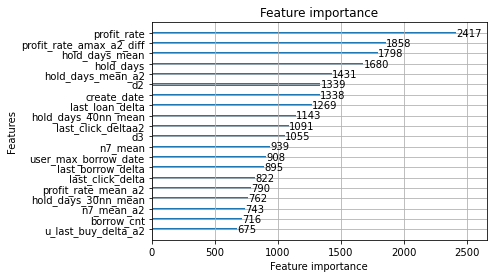

In [171]:
import lightgbm as lgb
lgb.plot_importance(clf.booster_,max_num_features=20)
booster = clf.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = clf.booster_.feature_name()
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
feature_importance = feature_importance.sort_values(by='importance',ascending=False).reset_index().drop(columns=['index'])

In [94]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
def lgb_f2_score(y_true, y_hat):
    y_hat = [1 if i >=0.072 else 0 for i in y_hat ]
    precision = precision_score(y_true,y_hat,zero_division=1)
    recall = recall_score(y_true,y_hat)
    f2 = 5*recall*precision/(4*precision+recall)
    return 'f2',f2,True
seed0=42
params_cat = {'iterations':1500,
                     'learning_rate':0.01,
                     'eval_metric':'AUC',
                     'l2_leaf_reg':0.1,}

params_cat2 = {"learning_rate":0.1,
            'task_type':"GPU",
              'random_seed':356,
            'iterations':3000,
        'eval_metric':'AUC',
        'l2_leaf_reg': 13,
        'scale_pos_weight': 0.9406780584846045,
        'depth': 4,
        'bootstrap_type':'Bernoulli',
        'subsample':0.22922161698463137}
params_xgb = {'n_estimators':540,
                     'learning_rate':0.01,
                     'verbose':-1,
                     'metrics':['auc'],
                     'reg_alpha':0.1,
                     'reg_lambda':0.1,
                     'min_child_weight':30,
                     'n_jobs':20}
params_xgb2 = {'n_estimators':450,
                     'learning_rate':0.1,
              'seed':42,
               'max_depth':5,
               'reg_alpha':16,
               'reg_lambda':0.8516218313773746,
               'colsample_bytree':0.7962234301287214,
               'gamma':5.524732779962722,
               'metrics':['auc'],
               'min_child_weight':6
              }

params_lgb = {'num_leaves':128,
                     'n_estimators':550,
                     'learning_rate':0.01,
                     'verbose':-1,
                     'metric':'auc',
                     'feature_fraction':0.8, 
                     'bagging_fraction':0.8,
                     'lambda_l1':0.1,
                     'lambda_l2':0.1,
                     'min_child_weight':30,
                     'n_jobs':20,
                     'random_state':356} # 42, 128, 356
params_lgb2 = {'n_estimators': 500, 
           'learning_rate': 0.04223859360499718, 
           'num_leaves': 96, 
           'max_depth': 6,
           'metric':'auc',
           'min_data_in_leaf': 1300,
           'lambda_l1': 0,
           'lambda_l2': 7, 
           'min_gain_to_split': 0.28816893721038017,
           'bagging_fraction': 0.5,
           'bagging_freq': 1,
           'feature_fraction': 0.8,
            'random_state':356}
def fold_5_clf(clf_name,params,threshold):
    fold = 0
    f2_scores = 0
    k = 5
    dataloader.setSample(0)
    tst_data = dataloader.get_test()
    dataloader.reset_pre()
    feature_imp = None
    for x_trn, x_val, y_trn, y_val in dataloader.get_k_fold_train_val_data(k=k):
        fold += 1
        print(f'{fold} starting ....')
        if clf_name=='lgbm':
            clf1 = LGBMClassifier(**params)
            clf1.fit(x_trn, y_trn,verbose=0)#,early_stopping_rounds=100,eval_set=[(x_val, y_val)],eval_metric=[lgb_f2_score])
        elif clf_name=='xgb':
            clf1 = XGBClassifier(tree_method='gpu_hist', gpu_id=0,**params)
            clf1.fit(x_trn, y_trn,eval_set=[(x_val, y_val)],eval_metric='auc',verbose=100,early_stopping_rounds=100)
        elif clf_name=='cat':
            clf1 = CatBoostClassifier(**params)
            clf1.fit(x_trn, y_trn,eval_set=[(x_val, y_val)],verbose=600,early_stopping_rounds=100)
        pred = clf1.predict_proba(x_val)[:, 1]
        score = f2_score(y_val, pred)[0]
        f2_scores += score
        # weight = (tst_data['a2'] != 2).astype(int)
        weight = None
        dataloader.set_pre(clf1.predict_proba(tst_data)[:, 1], weight, k=k)
        print('{} fold, auc: {}'.format(fold, roc_auc_score(y_val, pred)))
        #metrics_detail(y_val, pred, x_val['a2'].values, 0.03)
        if clf_name=='lgbm':
            booster = clf1.booster_
            importance = booster.feature_importance(importance_type='split')
            feature_name = clf1.booster_.feature_name()
            feature_importance = pd.DataFrame({'feature_name':feature_name,'importance{}'.format(fold):importance})
            if feature_imp is None:
                feature_imp = feature_importance
            else:
                feature_imp = feature_imp.merge(feature_importance,how='left',on='feature_name')
            
    print('the mean f2 score is: ', f2_scores / k)
    dataloader.save_res(f'lgb_{k}_fold', 0.03,threshold) #0.977  976 977  977 978
    return feature_imp

In [100]:
pred_df = pd.DataFrame()
pred_df['id'] = dataloader.rs['id']
dataloader.feature_columns= feature+pool
with timer('lgb'):
    fold_5_clf('lgbm',params_lgb2,0.072)
pred_df['lgb'] = dataloader.rs.loc[:,'prediction'].copy()
with timer('cat'):
    fold_5_clf('cat',params_cat2,0.072)
pred_df['cat'] = dataloader.rs.loc[:,'prediction'].copy()
dataloader.feature_columns= feature + pool_xgb
for i in ['min_profit_rate_amax_a2_diff','min_profit_rate_mean_a2_diff','f14']:
    dataloader.feature_columns.remove(i)
with timer('xgb'):
    fold_5_clf('xgb',params_xgb2,0.072)
pred_df['xgb'] = dataloader.rs.loc[:,'prediction'].copy()

1 starting ....


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.86945
[100]	validation_0-auc:0.97333
[200]	validation_0-auc:0.97564
[275]	validation_0-auc:0.97564
1 fold, auc: 0.9756353656857146
2 starting ....


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.92944
[100]	validation_0-auc:0.97304
[200]	validation_0-auc:0.97524
[273]	validation_0-auc:0.97524
2 fold, auc: 0.9752355030893397
3 starting ....


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.92234
[100]	validation_0-auc:0.97261
[200]	validation_0-auc:0.97484
[275]	validation_0-auc:0.97484
3 fold, auc: 0.9748410423974453
4 starting ....


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.92411
[100]	validation_0-auc:0.97188
[200]	validation_0-auc:0.97428
[275]	validation_0-auc:0.97428
4 fold, auc: 0.9742819721593504
5 starting ....


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.92241
[100]	validation_0-auc:0.97182
[200]	validation_0-auc:0.97413
[272]	validation_0-auc:0.97413
5 fold, auc: 0.9741289431965885
the mean f2 score is:  0.46356623247244794
     count      mean   sum
a2                        
1   232455  0.033254  7730
2   183505  0.003079   565
3    46174  0.110625  5108
4   124951  0.030324  3789
0.02928366420535357
save to  ./result/lgb_5_fold_2022-02-05.csv
1 starting ....
0:	learn: 0.8930647	test: 0.8958920	best: 0.8958920 (0)	total: 52.7ms	remaining: 2m 38s
100:	learn: 0.9616638	test: 0.9623079	best: 0.9623079 (100)	total: 3.81s	remaining: 1m

In [102]:
pred_df['y'] = (pred_df['lgb'] + pred_df['xgb']+pred_df['cat'])/3
pred_df['y'] = [1 if i>=0.072 else 0 for i in pred_df['y']]

In [114]:
re_df = pred_df[['id','y']]
re_df.to_csv('rrr.csv',index=False)
pred_df.y.value_counts()   #########记得保存csv先！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

0    569893
1     17192
Name: y, dtype: int64